# Wikipedia Stock Predictor
## Full Analysis Pipeline: Using Wikipedia Pageviews as Alternative Data

This notebook implements a complete pipeline for fetching daily Wikipedia pageviews data and using it as alternative data to predict stock returns.

### Companies Initially Tracked:
Apple, Amazon, Tesla, Meta, Netflix, Google, Target, Walmart, Nike
### Final Focus:
Based on data quality and initial results, analysis focuses on: Amazon, Netflix, and Walmart

---
## Module 1:
Configuration settings, company definitions, and utility functions.

In [4]:
# ============================================================================
# config.py - Configuration and Company Definitions
# ============================================================================

from dataclasses import dataclass
from pathlib import Path
from typing import List


@dataclass(frozen=True)
class CompanyConfig:
    """Configuration for a company to track Wikipedia pageviews."""
    name: str        # Friendly label (e.g., "Apple")
    ticker: str      # Stock ticker (e.g., "AAPL")
    wiki_title: str  # Wikipedia page title for API (e.g., "Apple_Inc.")


# List of companies to track
COMPANIES: List[CompanyConfig] = [
    CompanyConfig(name="Apple", ticker="AAPL", wiki_title="Apple_Inc."),
    CompanyConfig(name="Amazon", ticker="AMZN", wiki_title="Amazon_(company)"),
    CompanyConfig(name="Tesla", ticker="TSLA", wiki_title="Tesla,_Inc."),
    CompanyConfig(name="Meta", ticker="META", wiki_title="Meta_Platforms"),
    CompanyConfig(name="Netflix", ticker="NFLX", wiki_title="Netflix"),
    CompanyConfig(name="Google", ticker="GOOGL", wiki_title="Google"),
    CompanyConfig(name="Target", ticker="TGT", wiki_title="Target_Corporation"),
    CompanyConfig(name="Walmart", ticker="WMT", wiki_title="Walmart"),
    CompanyConfig(name="Nike", ticker="NKE", wiki_title="Nike,_Inc."),
]

# Wikimedia API Settings
WIKIMEDIA_API_BASE = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article"
WIKIMEDIA_PROJECT = "en.wikipedia.org"
WIKIMEDIA_ACCESS = "all-access"  # Options: all-access, desktop, mobile-app, mobile-web
WIKIMEDIA_AGENT = "user"         # Options: user, spider, automated, all-agents
WIKIMEDIA_GRANULARITY = "daily"  # Options: daily, monthly

# Data Directory Settings
DATA_DIR = Path("data/wikipedia_pageviews")


def ensure_data_dir() -> Path:
    """Create the data directory if it does not exist and return its path."""
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    return DATA_DIR


def get_company_by_ticker(ticker: str) -> CompanyConfig | None:
    """Look up a company by its ticker symbol."""
    for company in COMPANIES:
        if company.ticker.upper() == ticker.upper():
            return company
    return None


def get_company_by_name(name: str) -> CompanyConfig | None:
    """Look up a company by its name (case-insensitive)."""
    for company in COMPANIES:
        if company.name.lower() == name.lower():
            return company
    return None


print("✓ config.py loaded successfully")
print(f"  Tracking {len(COMPANIES)} companies")
print(f"  Data directory: {DATA_DIR}")

✓ config.py loaded successfully
  Tracking 9 companies
  Data directory: data/wikipedia_pageviews


---
## Module 2:
Data models for pageview records.

In [6]:
# ============================================================================
# models.py - Data Models
# ============================================================================

from dataclasses import dataclass, field
from datetime import date
from typing import List, Dict, Any


@dataclass
class PageviewRecord:
    """A single daily pageview record for a company's Wikipedia page."""
    company: str         # Company name (e.g., "Apple")
    ticker: str          # Stock ticker (e.g., "AAPL")
    wiki_title: str      # Wikipedia page title
    date: date           # Date of the pageview count
    views: int           # Number of pageviews on that date

    def to_dict(self) -> Dict[str, Any]:
        """Convert record to a dictionary for DataFrame creation."""
        return {
            "company": self.company,
            "ticker": self.ticker,
            "wiki_title": self.wiki_title,
            "date": self.date,
            "views": self.views,
        }


@dataclass
class FetchResult:
    """Result of a pageview fetch operation for a single company."""
    company: CompanyConfig
    records: List[PageviewRecord] = field(default_factory=list)
    success: bool = True
    error_message: str | None = None

    @property
    def record_count(self) -> int:
        """Number of records fetched."""
        return len(self.records)


print("✓ models.py loaded successfully")

✓ models.py loaded successfully


---
## Module 3:
HTTP utilities with retry logic and error handling.

In [8]:
# ============================================================================
# http_utils.py - HTTP Utilities with Retry Logic
# ============================================================================

import time
import logging
from typing import Dict, Any

import requests

# Configure module logger
logger = logging.getLogger(__name__)


class HTTPError(Exception):
    """Custom exception for HTTP errors."""
    def __init__(self, message: str, status_code: int | None = None):
        super().__init__(message)
        self.status_code = status_code


class RetryExhaustedError(Exception):
    """Raised when all retry attempts have been exhausted."""
    pass


def get_with_retries(
    url: str,
    params: Dict[str, Any] | None = None,
    max_retries: int = 5,
    backoff_factor: float = 1.0,
    timeout: float = 10.0,
    headers: Dict[str, str] | None = None,
) -> Dict[str, Any]:
    """
    Perform an HTTP GET request with retries on 429/5xx errors.
    
    Args:
        url: The URL to fetch.
        params: Optional query parameters.
        max_retries: Maximum number of retry attempts (default: 5).
        backoff_factor: Factor for exponential backoff (default: 1.0).
                       Wait time = backoff_factor * (2 ** attempt)
        timeout: Request timeout in seconds (default: 10.0).
        headers: Optional HTTP headers.
    
    Returns:
        Parsed JSON response as a dictionary.
    
    Raises:
        RetryExhaustedError: If all retry attempts fail.
        HTTPError: For non-retryable HTTP errors (4xx except 429).
        RuntimeError: For unexpected errors.
    """
    # Default headers for Wikimedia API
    default_headers = {
        "User-Agent": "CODS620-WikipediaPageviewsFetcher/1.0 (Educational Project)",
        "Accept": "application/json",
    }
    if headers:
        default_headers.update(headers)
    
    last_exception: Exception | None = None
    
    for attempt in range(max_retries):
        try:
            logger.debug(f"Attempt {attempt + 1}/{max_retries}: GET {url}")
            
            response = requests.get(
                url,
                params=params,
                headers=default_headers,
                timeout=timeout,
            )
            
            # Check for successful response
            if response.status_code == 200:
                return response.json()
            
            # Handle rate limiting (429) and server errors (5xx) with retry
            if response.status_code == 429 or response.status_code >= 500:
                wait_time = backoff_factor * (2 ** attempt)
                
                # Check for Retry-After header
                retry_after = response.headers.get("Retry-After")
                if retry_after:
                    try:
                        wait_time = max(wait_time, float(retry_after))
                    except ValueError:
                        pass
                
                logger.warning(
                    f"HTTP {response.status_code} received. "
                    f"Retrying in {wait_time:.1f}s (attempt {attempt + 1}/{max_retries})"
                )
                time.sleep(wait_time)
                last_exception = HTTPError(
                    f"HTTP {response.status_code}: {response.reason}",
                    status_code=response.status_code
                )
                continue
            
            # Non-retryable client errors (4xx except 429)
            error_msg = f"HTTP {response.status_code}: {response.reason}"
            try:
                error_detail = response.json()
                if "detail" in error_detail:
                    error_msg += f" - {error_detail['detail']}"
            except Exception:
                pass
            
            raise HTTPError(error_msg, status_code=response.status_code)
        
        except requests.exceptions.Timeout as e:
            wait_time = backoff_factor * (2 ** attempt)
            logger.warning(
                f"Request timed out. Retrying in {wait_time:.1f}s "
                f"(attempt {attempt + 1}/{max_retries})"
            )
            time.sleep(wait_time)
            last_exception = e
            continue
        
        except requests.exceptions.ConnectionError as e:
            wait_time = backoff_factor * (2 ** attempt)
            logger.warning(
                f"Connection error. Retrying in {wait_time:.1f}s "
                f"(attempt {attempt + 1}/{max_retries})"
            )
            time.sleep(wait_time)
            last_exception = e
            continue
        
        except requests.exceptions.RequestException as e:
            # Other request exceptions - don't retry
            raise RuntimeError(f"Request failed: {e}") from e
    
    # All retries exhausted
    raise RetryExhaustedError(
        f"All {max_retries} retry attempts failed for URL: {url}. "
        f"Last error: {last_exception}"
    )


print("✓ http_utils.py loaded successfully")

✓ http_utils.py loaded successfully


---
## Module 4:
Wikipedia Pageviews fetcher - core data fetching logic.

In [10]:
# ============================================================================
# wpv_fetcher.py - Wikipedia Pageviews Fetcher
# ============================================================================

import logging
from datetime import date, datetime
from typing import List, Dict, Any
from urllib.parse import quote

import pandas as pd

# Module logger
logger = logging.getLogger(__name__)


def parse_timestamp(timestamp: str) -> date:
    """
    Parse Wikimedia timestamp format (YYYYMMDD00) to datetime.date.
    
    Args:
        timestamp: Timestamp string in YYYYMMDD00 format.
    
    Returns:
        Parsed date object.
    """
    # Remove trailing "00" if present and parse
    date_str = timestamp[:8] if len(timestamp) >= 8 else timestamp
    return datetime.strptime(date_str, "%Y%m%d").date()


def build_pageview_url(
    wiki_title: str,
    start_date: date,
    end_date: date,
    project: str = WIKIMEDIA_PROJECT,
    access: str = WIKIMEDIA_ACCESS,
    agent: str = WIKIMEDIA_AGENT,
    granularity: str = WIKIMEDIA_GRANULARITY,
) -> str:
    """
    Build the Wikimedia Pageviews API URL.
    
    Args:
        wiki_title: Wikipedia page title.
        start_date: Start date for the query.
        end_date: End date for the query.
        project: Wikimedia project (default: en.wikipedia.org).
        access: Access type (default: all-access).
        agent: Agent type (default: user).
        granularity: Data granularity (default: daily).
    
    Returns:
        Complete API URL.
    """
    # URL-encode the article title
    encoded_title = quote(wiki_title, safe="")
    
    # Format dates as YYYYMMDD
    start_str = start_date.strftime("%Y%m%d")
    end_str = end_date.strftime("%Y%m%d")
    
    url = (
        f"{WIKIMEDIA_API_BASE}/{project}/{access}/{agent}/"
        f"{encoded_title}/{granularity}/{start_str}/{end_str}"
    )
    
    return url


def fetch_pageviews(
    company: CompanyConfig,
    start_date: date,
    end_date: date,
    max_retries: int = 5,
    backoff_factor: float = 1.0,
    timeout: float = 10.0,
) -> FetchResult:
    """
    Fetch Wikipedia pageviews for a single company.
    
    Args:
        company: Company configuration.
        start_date: Start date for the query.
        end_date: End date for the query.
        max_retries: Maximum retry attempts.
        backoff_factor: Exponential backoff factor.
        timeout: Request timeout in seconds.
    
    Returns:
        FetchResult containing pageview records or error information.
    """
    logger.info(f"Fetching pageviews for {company.name} ({company.ticker})")
    
    url = build_pageview_url(
        wiki_title=company.wiki_title,
        start_date=start_date,
        end_date=end_date,
    )
    
    try:
        response_data = get_with_retries(
            url=url,
            max_retries=max_retries,
            backoff_factor=backoff_factor,
            timeout=timeout,
        )
        
        # Parse the response
        records = []
        items = response_data.get("items", [])
        
        for item in items:
            try:
                record = PageviewRecord(
                    company=company.name,
                    ticker=company.ticker,
                    wiki_title=company.wiki_title,
                    date=parse_timestamp(item["timestamp"]),
                    views=int(item["views"]),
                )
                records.append(record)
            except (KeyError, ValueError) as e:
                logger.warning(f"Failed to parse item {item}: {e}")
                continue
        
        logger.info(f"  Retrieved {len(records)} records for {company.name}")
        
        return FetchResult(
            company=company,
            records=records,
            success=True,
        )
    
    except (HTTPError, RetryExhaustedError) as e:
        logger.error(f"Failed to fetch pageviews for {company.name}: {e}")
        return FetchResult(
            company=company,
            records=[],
            success=False,
            error_message=str(e),
        )
    except Exception as e:
        logger.error(f"Unexpected error fetching {company.name}: {e}")
        return FetchResult(
            company=company,
            records=[],
            success=False,
            error_message=f"Unexpected error: {e}",
        )


def fetch_all_companies(
    companies: List[CompanyConfig],
    start_date: date,
    end_date: date,
    delay_between_requests: float = 0.5,
    max_retries: int = 5,
    backoff_factor: float = 1.0,
    timeout: float = 10.0,
) -> List[FetchResult]:
    """
    Fetch Wikipedia pageviews for all companies.
    
    Args:
        companies: List of company configurations.
        start_date: Start date for the query.
        end_date: End date for the query.
        delay_between_requests: Delay between API calls to avoid rate limiting.
        max_retries: Maximum retry attempts per request.
        backoff_factor: Exponential backoff factor.
        timeout: Request timeout in seconds.
    
    Returns:
        List of FetchResult objects.
    """
    results = []
    
    for i, company in enumerate(companies):
        if i > 0 and delay_between_requests > 0:
            time.sleep(delay_between_requests)
        
        result = fetch_pageviews(
            company=company,
            start_date=start_date,
            end_date=end_date,
            max_retries=max_retries,
            backoff_factor=backoff_factor,
            timeout=timeout,
        )
        results.append(result)
    
    return results


def results_to_dataframe(results: List[FetchResult]) -> pd.DataFrame:
    """
    Convert fetch results to a pandas DataFrame.
    
    Args:
        results: List of FetchResult objects.
    
    Returns:
        DataFrame with all pageview records.
    """
    all_records = []
    for result in results:
        if result.success:
            for record in result.records:
                all_records.append(record.to_dict())
    
    if not all_records:
        return pd.DataFrame(columns=["company", "ticker", "wiki_title", "date", "views"])
    
    df = pd.DataFrame(all_records)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["company", "date"]).reset_index(drop=True)
    
    return df


def is_parquet_available() -> bool:
    """Check if parquet support is available (pyarrow or fastparquet installed)."""
    try:
        import pyarrow
        return True
    except ImportError:
        pass
    try:
        import fastparquet
        return True
    except ImportError:
        pass
    return False


# Check parquet availability at module load
PARQUET_AVAILABLE = is_parquet_available()


def save_dataframe(
    df: pd.DataFrame,
    output_dir: Path,
    filename_prefix: str = 'wikipedia_pageviews',
    save_csv: bool = True,
    save_parquet: bool = True,
) -> Dict[str, Path]:
    """
    Save DataFrame to CSV and/or Parquet format.
    
    Args:
        df: DataFrame to save.
        output_dir: Output directory path.
        filename_prefix: Prefix for output files.
        save_csv: Whether to save as CSV.
        save_parquet: Whether to save as Parquet (requires pyarrow or fastparquet).
    
    Returns:
        Dictionary mapping format to file path.
    
    Note:
        If parquet is requested but pyarrow/fastparquet is not installed,
        a warning is logged and parquet saving is skipped.
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    saved_files = {}
    
    if save_csv:
        csv_path = output_dir / f'{filename_prefix}.csv'
        df.to_csv(csv_path, index=False)
        saved_files['csv'] = csv_path
        logger.info(f'Saved CSV: {csv_path}')
    
    if save_parquet:
        if PARQUET_AVAILABLE:
            parquet_path = output_dir / f'{filename_prefix}.parquet'
            df.to_parquet(parquet_path, index=False)
            saved_files['parquet'] = parquet_path
            logger.info(f'Saved Parquet: {parquet_path}')
        else:
            logger.warning(
                'Parquet saving skipped: pyarrow or fastparquet not installed. '
                'Install with: pip install pyarrow'
            )
    
    return saved_files


print('✓ wpv_fetcher.py loaded successfully')
print(f'  Parquet support: {"available" if PARQUET_AVAILABLE else "NOT available (install pyarrow)"}')

✓ wpv_fetcher.py loaded successfully
  Parquet support: available


---
## Module 5:
Command-line interface and main execution logic.

In [12]:
# ============================================================================
# cli.py - Command Line Interface
# ============================================================================

import argparse
import logging
import sys
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from typing import Tuple


def setup_logging(verbose: bool = False, quiet: bool = False) -> None:
    """
    Configure logging for the application.
    
    Args:
        verbose: Enable debug-level logging.
        quiet: Suppress all but error messages.
    """
    if quiet:
        level = logging.ERROR
    elif verbose:
        level = logging.DEBUG
    else:
        level = logging.INFO
    
    logging.basicConfig(
        level=level,
        format="%(asctime)s | %(levelname)-8s | %(name)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )


def compute_default_date_range() -> Tuple[date, date]:
    """
    Compute the default date range (last 3 years).
    
    Returns:
        Tuple of (start_date, end_date).
        end_date = today - 2 days (to avoid incomplete data)
        start_date = end_date - 3 years
    """
    today = date.today()
    end_date = today - timedelta(days=2)
    start_date = end_date - relativedelta(years=3)
    
    return start_date, end_date


def parse_date(date_str: str) -> date:
    """
    Parse an ISO format date string (YYYY-MM-DD).
    
    Args:
        date_str: Date string in ISO format.
    
    Returns:
        Parsed date object.
    
    Raises:
        ValueError: If the date string is invalid.
    """
    try:
        return date.fromisoformat(date_str)
    except ValueError as e:
        raise ValueError(
            f"Invalid date format: '{date_str}'. Expected YYYY-MM-DD."
        ) from e


def create_argument_parser() -> argparse.ArgumentParser:
    """
    Create and configure the argument parser.
    
    Returns:
        Configured ArgumentParser.
    """
    default_start, default_end = compute_default_date_range()
    
    parser = argparse.ArgumentParser(
        prog="wpv_fetcher",
        description="Fetch Wikipedia pageviews for company research.",
        formatter_class=argparse.RawDescriptionHelpFormatter,
        epilog="""
Examples:
  # Fetch last 3 years of data (default)
  python -m wpv_fetcher
  
  # Fetch specific date range
  python -m wpv_fetcher --start-date 2023-01-01 --end-date 2023-12-31
  
  # Save only CSV (no Parquet)
  python -m wpv_fetcher --no-parquet
  
  # Verbose output
  python -m wpv_fetcher -v
"""
    )
    
    # Date range arguments
    parser.add_argument(
        "--start-date",
        type=str,
        default=None,
        help=f"Start date in ISO format (YYYY-MM-DD). Default: {default_start}",
    )
    parser.add_argument(
        "--end-date",
        type=str,
        default=None,
        help=f"End date in ISO format (YYYY-MM-DD). Default: {default_end}",
    )
    
    # Output options
    parser.add_argument(
        "--output-dir",
        type=str,
        default=str(DATA_DIR),
        help=f"Output directory for data files. Default: {DATA_DIR}",
    )
    parser.add_argument(
        "--no-csv",
        action="store_true",
        help="Do not save CSV output.",
    )
    parser.add_argument(
        "--no-parquet",
        action="store_true",
        help="Do not save Parquet output.",
    )
    
    # Request options
    parser.add_argument(
        "--max-retries",
        type=int,
        default=5,
        help="Maximum number of retry attempts per request. Default: 5",
    )
    parser.add_argument(
        "--delay",
        type=float,
        default=0.5,
        help="Delay between requests in seconds. Default: 0.5",
    )
    parser.add_argument(
        "--timeout",
        type=float,
        default=10.0,
        help="Request timeout in seconds. Default: 10.0",
    )
    
    # Logging options
    log_group = parser.add_mutually_exclusive_group()
    log_group.add_argument(
        "-v", "--verbose",
        action="store_true",
        help="Enable verbose (debug) output.",
    )
    log_group.add_argument(
        "-q", "--quiet",
        action="store_true",
        help="Suppress all but error messages.",
    )
    
    return parser


def run_cli(args: argparse.Namespace) -> int:
    """
    Execute the main CLI logic.
    
    Args:
        args: Parsed command-line arguments.
    
    Returns:
        Exit code (0 for success, non-zero for failure).
    """
    logger = logging.getLogger(__name__)
    
    # Parse dates
    default_start, default_end = compute_default_date_range()
    
    try:
        start_date = parse_date(args.start_date) if args.start_date else default_start
        end_date = parse_date(args.end_date) if args.end_date else default_end
    except ValueError as e:
        logger.error(str(e))
        return 1
    
    # Validate date range
    if start_date > end_date:
        logger.error(f"Start date ({start_date}) must be before end date ({end_date})")
        return 1
    
    # Check output format
    if args.no_csv and args.no_parquet:
        logger.error("At least one output format (CSV or Parquet) must be enabled")
        return 1
    
    output_dir = Path(args.output_dir)
    
    logger.info("="*60)
    logger.info("Wikipedia Pageviews Fetcher")
    logger.info("="*60)
    logger.info(f"Date range: {start_date} to {end_date}")
    logger.info(f"Companies: {len(COMPANIES)}")
    logger.info(f"Output directory: {output_dir}")
    logger.info("="*60)
    
    # Fetch pageviews
    results = fetch_all_companies(
        companies=COMPANIES,
        start_date=start_date,
        end_date=end_date,
        delay_between_requests=args.delay,
        max_retries=args.max_retries,
        timeout=args.timeout,
    )
    
    # Summarize results
    successful = sum(1 for r in results if r.success)
    failed = len(results) - successful
    total_records = sum(r.record_count for r in results if r.success)
    
    logger.info("="*60)
    logger.info("Fetch Summary")
    logger.info("="*60)
    logger.info(f"Successful: {successful}/{len(results)} companies")
    logger.info(f"Total records: {total_records:,}")
    
    if failed > 0:
        logger.warning(f"Failed: {failed} companies")
        for r in results:
            if not r.success:
                logger.warning(f"  - {r.company.name}: {r.error_message}")
    
    # Convert to DataFrame and save
    df = results_to_dataframe(results)
    
    if df.empty:
        logger.error("No data was fetched. Check the errors above.")
        return 1
    
    # Generate filename with date range
    filename_prefix = f"wikipedia_pageviews_{start_date}_{end_date}"
    
    saved_files = save_dataframe(
        df=df,
        output_dir=output_dir,
        filename_prefix=filename_prefix,
        save_csv=not args.no_csv,
        save_parquet=not args.no_parquet,
    )
    
    logger.info("="*60)
    logger.info("Output Files")
    logger.info("="*60)
    for fmt, path in saved_files.items():
        logger.info(f"{fmt.upper()}: {path}")
    
    logger.info("="*60)
    logger.info("Done!")
    
    return 0


def main() -> int:
    """
    Main entry point for CLI.
    
    Returns:
        Exit code.
    """
    parser = create_argument_parser()
    args = parser.parse_args()
    
    setup_logging(verbose=args.verbose, quiet=args.quiet)
    
    return run_cli(args)


print("✓ cli.py loaded successfully")

✓ cli.py loaded successfully


---
## Module 6:
Entry point for running as a module.

In [14]:
# ============================================================================
# __main__.py - Module Entry Point
# ============================================================================

# This would normally be in __main__.py for running as:
# python -m wpv_fetcher

def is_notebook() -> bool:
    """Check if we're running in a Jupyter notebook environment."""
    try:
        from IPython import get_ipython
        shell = get_ipython()
        if shell is None:
            return False
        shell_name = shell.__class__.__name__
        if shell_name == 'ZMQInteractiveShell':  # Jupyter notebook/lab
            return True
        return False
    except (ImportError, NameError):
        return False


def main_notebook(
    start_date: str | None = None,
    end_date: str | None = None,
    output_dir: str | None = None,
    no_csv: bool = False,
    no_parquet: bool = False,
    max_retries: int = 5,
    delay: float = 0.5,
    timeout: float = 10.0,
    verbose: bool = False,
    quiet: bool = False,
) -> int:
    """
    Main function for notebook usage (bypasses argparse).
    
    Args:
        start_date: Start date in ISO format (YYYY-MM-DD). Defaults to 3 years ago.
        end_date: End date in ISO format (YYYY-MM-DD). Defaults to 2 days ago.
        output_dir: Output directory for data files.
        no_csv: Do not save CSV output.
        no_parquet: Do not save Parquet output.
        max_retries: Maximum retry attempts per request.
        delay: Delay between requests in seconds.
        timeout: Request timeout in seconds.
        verbose: Enable verbose output.
        quiet: Suppress all but error messages.
    
    Returns:
        Exit code (0 for success, non-zero for failure).
    """
    class Args:
        pass
    
    args = Args()
    args.start_date = start_date
    args.end_date = end_date
    args.output_dir = output_dir or str(DATA_DIR)
    args.no_csv = no_csv
    args.no_parquet = no_parquet
    args.max_retries = max_retries
    args.delay = delay
    args.timeout = timeout
    args.verbose = verbose
    args.quiet = quiet
    
    setup_logging(verbose=verbose, quiet=quiet)
    return run_cli(args)


# Only run CLI main() when executed as a script, NOT in Jupyter
if __name__ == '__main__' and not is_notebook():
    sys.exit(main())

print('✓ __main__.py loaded successfully')
print('  Note: In notebooks, use main_notebook() instead of CLI')

✓ __main__.py loaded successfully
  Note: In notebooks, use main_notebook() instead of CLI


---
##  Usage

Fetcher

In [16]:
# ============================================================================
# ISetup
# ============================================================================

# Set up logging for interactive use
setup_logging(verbose=False)

# Ensure data directory exists
data_dir = ensure_data_dir()
print(f"Data directory: {data_dir}")

# Compute default date range
default_start, default_end = compute_default_date_range()
print(f"Default date range: {default_start} to {default_end}")
print(f"Days covered: {(default_end - default_start).days}")

Data directory: data/wikipedia_pageviews
Default date range: 2022-12-05 to 2025-12-05
Days covered: 1096


In [17]:
# ============================================================================
# List Companies
# ============================================================================

print("Companies to fetch:")
print("-" * 50)
for company in COMPANIES:
    print(f"{company.name:12} | {company.ticker:5} | {company.wiki_title}")

Companies to fetch:
--------------------------------------------------
Apple        | AAPL  | Apple_Inc.
Amazon       | AMZN  | Amazon_(company)
Tesla        | TSLA  | Tesla,_Inc.
Meta         | META  | Meta_Platforms
Netflix      | NFLX  | Netflix
Google       | GOOGL | Google
Target       | TGT   | Target_Corporation
Walmart      | WMT   | Walmart
Nike         | NKE   | Nike,_Inc.


In [18]:
# ============================================================================
#  Fetch Single Company (Quick Test)
# ============================================================================

# Fetch just one company for a short period to test
from datetime import date, timedelta

test_company = COMPANIES[0]  # Apple
test_end = date.today() - timedelta(days=2)
test_start = test_end - timedelta(days=7)  # Just 1 week for quick test

print(f"Testing with {test_company.name}...")
print(f"Date range: {test_start} to {test_end}")

test_result = fetch_pageviews(
    company=test_company,
    start_date=test_start,
    end_date=test_end,
)

if test_result.success:
    print(f"\n✓ Success! Retrieved {test_result.record_count} records")
    print("\nSample records:")
    for record in test_result.records[:3]:
        print(f"  {record.date}: {record.views:,} views")
else:
    print(f"\n✗ Failed: {test_result.error_message}")

2025-12-07 23:26:01 | INFO     | __main__ | Fetching pageviews for Apple (AAPL)


Testing with Apple...
Date range: 2025-11-28 to 2025-12-05


2025-12-07 23:26:01 | INFO     | __main__ |   Retrieved 8 records for Apple



✓ Success! Retrieved 8 records

Sample records:
  2025-11-28: 5,766 views
  2025-11-29: 5,274 views
  2025-11-30: 5,410 views


In [19]:
# ============================================================================
# Interactive Demo - Fetch All Companies (Full Run)
# ============================================================================

# Use shorter date range for demo (30 days instead of 3 years)
demo_end = date.today() - timedelta(days=2)
demo_start = demo_end - timedelta(days=30)  # 30 days for demo

print(f"Fetching pageviews for all {len(COMPANIES)} companies...")
print(f"Date range: {demo_start} to {demo_end}")
print()

# Fetch all companies
all_results = fetch_all_companies(
    companies=COMPANIES,
    start_date=demo_start,
    end_date=demo_end,
    delay_between_requests=0.3,  # Be nice to the API
)

# Summary
print("\n" + "="*50)
print("Fetch Summary")
print("="*50)
for result in all_results:
    status = "✓" if result.success else "✗"
    count = result.record_count if result.success else "FAILED"
    print(f"{status} {result.company.name:12} | {count:>6} records")

2025-12-07 23:26:01 | INFO     | __main__ | Fetching pageviews for Apple (AAPL)


Fetching pageviews for all 9 companies...
Date range: 2025-11-05 to 2025-12-05



2025-12-07 23:26:02 | INFO     | __main__ |   Retrieved 31 records for Apple
2025-12-07 23:26:02 | INFO     | __main__ | Fetching pageviews for Amazon (AMZN)
2025-12-07 23:26:02 | INFO     | __main__ |   Retrieved 31 records for Amazon
2025-12-07 23:26:03 | INFO     | __main__ | Fetching pageviews for Tesla (TSLA)
2025-12-07 23:26:04 | INFO     | __main__ |   Retrieved 31 records for Tesla
2025-12-07 23:26:05 | INFO     | __main__ | Fetching pageviews for Meta (META)
2025-12-07 23:26:05 | INFO     | __main__ |   Retrieved 31 records for Meta
2025-12-07 23:26:05 | INFO     | __main__ | Fetching pageviews for Netflix (NFLX)
2025-12-07 23:26:06 | INFO     | __main__ |   Retrieved 31 records for Netflix
2025-12-07 23:26:06 | INFO     | __main__ | Fetching pageviews for Google (GOOGL)
2025-12-07 23:26:07 | INFO     | __main__ |   Retrieved 31 records for Google
2025-12-07 23:26:07 | INFO     | __main__ | Fetching pageviews for Target (TGT)
2025-12-07 23:26:07 | INFO     | __main__ |   Retri


Fetch Summary
✓ Apple        |     31 records
✓ Amazon       |     31 records
✓ Tesla        |     31 records
✓ Meta         |     31 records
✓ Netflix      |     31 records
✓ Google       |     31 records
✓ Target       |     31 records
✓ Walmart      |     31 records
✓ Nike         |     31 records


In [20]:
# ============================================================================
# Interactive Demo - Create DataFrame
# ============================================================================

# Convert results to DataFrame
df = results_to_dataframe(all_results)

print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nDate range in data: {df['date'].min()} to {df['date'].max()}")
print(f"Companies in data: {df['company'].nunique()}")
print()
display(df.head(10))

DataFrame shape: (279, 5)
Columns: ['company', 'ticker', 'wiki_title', 'date', 'views']

Date range in data: 2025-11-05 00:00:00 to 2025-12-05 00:00:00
Companies in data: 9



company ticker        wiki_title       date  views
0  Amazon   AMZN  Amazon_(company) 2025-11-05   7697
1  Amazon   AMZN  Amazon_(company) 2025-11-06   8059
2  Amazon   AMZN  Amazon_(company) 2025-11-07   6835
3  Amazon   AMZN  Amazon_(company) 2025-11-08   5858
4  Amazon   AMZN  Amazon_(company) 2025-11-09   5958
5  Amazon   AMZN  Amazon_(company) 2025-11-10   7533
6  Amazon   AMZN  Amazon_(company) 2025-11-11   7732
7  Amazon   AMZN  Amazon_(company) 2025-11-12   7787
8  Amazon   AMZN  Amazon_(company) 2025-11-13   7150
9  Amazon   AMZN  Amazon_(company) 2025-11-14   6841

In [21]:
# ============================================================================
# Interactive Demo - Basic Statistics
# ============================================================================

print("Pageview Statistics by Company")
print("="*60)

stats = df.groupby('company')['views'].agg(['mean', 'std', 'min', 'max', 'sum'])
stats.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'Total']
stats = stats.round(0).astype(int)
display(stats.sort_values('Total', ascending=False))

Pageview Statistics by Company


Mean  Std Dev    Min    Max   Total
company                                      
Google   24567     2699  19820  31384  761572
Netflix  10538     9836   7974  63373  326671
Amazon    7185      797   5362   8725  222727
Apple     6247      480   5274   6988  193643
Tesla     4167     1579   2821  11597  129162
Walmart   3888      369   3353   5373  120529
Meta      3783      496   3001   5384  117262
Nike      2729      185   2455   3351   84601
Target    1834      245   1398   2329   56840

In [22]:
# ============================================================================
# Interactive Demo - Save Data
# ============================================================================

# Save the data
output_dir = ensure_data_dir()
filename_prefix = f"wikipedia_pageviews_{demo_start}_{demo_end}"

saved_files = save_dataframe(
    df=df,
    output_dir=output_dir,
    filename_prefix=filename_prefix,
    save_csv=True,
    save_parquet=True,
)

print("\nSaved files:")
for fmt, path in saved_files.items():
    file_size = path.stat().st_size / 1024  # KB
    print(f"  {fmt.upper()}: {path} ({file_size:.1f} KB)")

2025-12-07 23:26:09 | INFO     | __main__ | Saved CSV: data/wikipedia_pageviews/wikipedia_pageviews_2025-11-05_2025-12-05.csv
2025-12-07 23:26:12 | INFO     | __main__ | Saved Parquet: data/wikipedia_pageviews/wikipedia_pageviews_2025-11-05_2025-12-05.parquet



Saved files:
  CSV: data/wikipedia_pageviews/wikipedia_pageviews_2025-11-05_2025-12-05.csv (10.9 KB)
  PARQUET: data/wikipedia_pageviews/wikipedia_pageviews_2025-11-05_2025-12-05.parquet (5.3 KB)


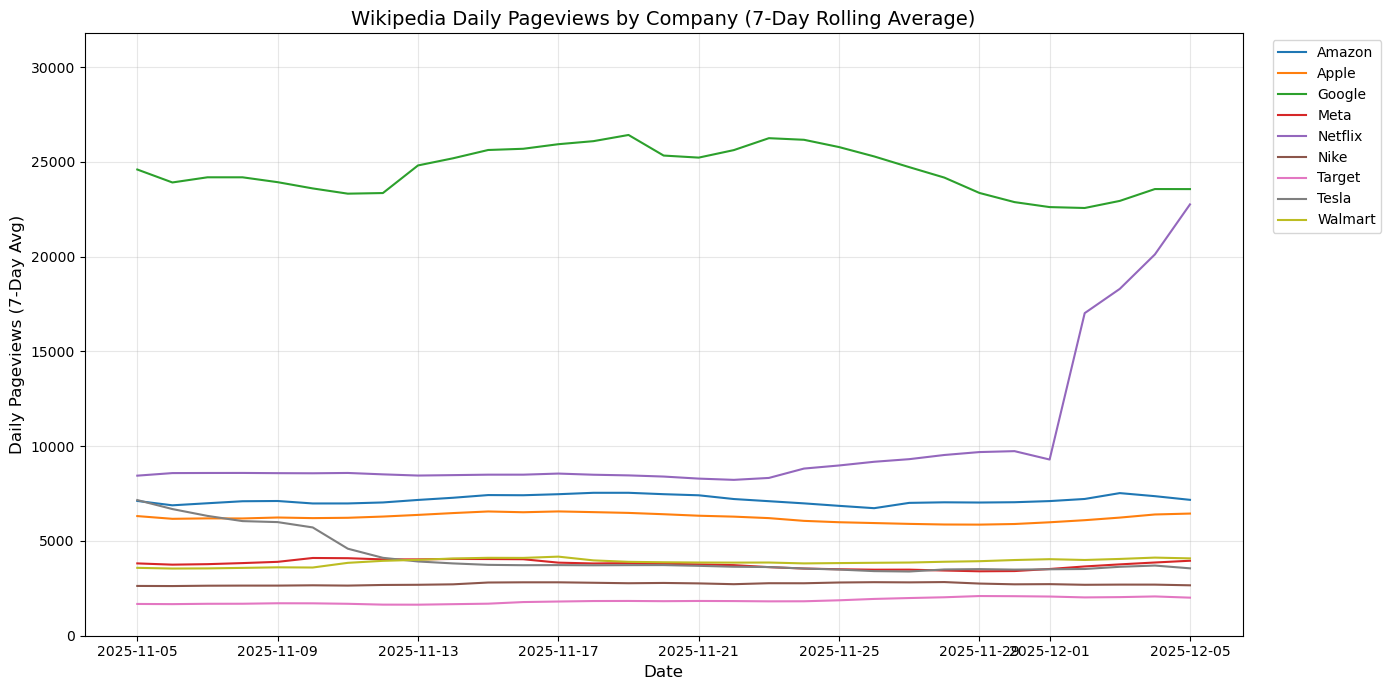

In [23]:
# ============================================================================
# Interactive Demo - Simple Visualization
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Plot pageviews over time - Using 7-day rolling average to reduce noise and outlier impact
fig, ax = plt.subplots(figsize=(14, 7))

for company in df['company'].unique():
    company_data = df[df['company'] == company].sort_values('date').copy()
    # Apply 7-day rolling average for smoother, clearer visualization
    company_data['views_smooth'] = company_data['views'].rolling(window=7, center=True, min_periods=1).mean()
    ax.plot(company_data['date'], company_data['views_smooth'], label=company, linewidth=1.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Pageviews (7-Day Avg)', fontsize=12)
ax.set_title('Wikipedia Daily Pageviews by Company (7-Day Rolling Average)', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.grid(True, alpha=0.3)

# Clip y-axis to 99th percentile to handle outliers
all_views = df['views'].values
y_upper = np.percentile(all_views, 99)
ax.set_ylim(0, y_upper * 1.1)

plt.tight_layout()
plt.show()

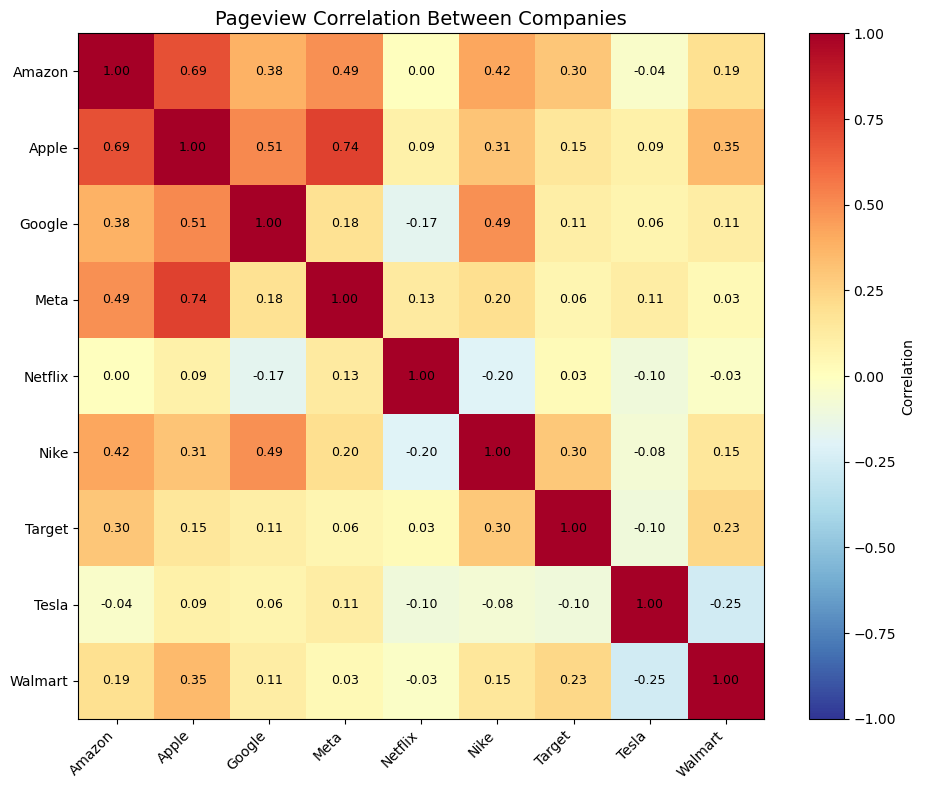

In [24]:
# ============================================================================
# Interactive Demo - Correlation Analysis
# ============================================================================

# Pivot to wide format for correlation analysis
df_pivot = df.pivot(index='date', columns='company', values='views')

# Calculate correlation matrix
corr_matrix = df_pivot.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)

# Add labels
companies = corr_matrix.columns
ax.set_xticks(range(len(companies)))
ax.set_yticks(range(len(companies)))
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.set_yticklabels(companies)

# Add correlation values
for i in range(len(companies)):
    for j in range(len(companies)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', fontsize=9)

ax.set_title('Pageview Correlation Between Companies', fontsize=14)
fig.colorbar(im, ax=ax, label='Correlation')

plt.tight_layout()
plt.show()

---
## Full 3-Year Fetch

In [26]:
# ============================================================================
#  Full 3-Year Fetch
# ============================================================================


#Get default 3-year date range
start_date, end_date = compute_default_date_range()

print(f"Starting full fetch...")
print(f"Date range: {start_date} to {end_date}")
print(f"Expected records per company: ~{(end_date - start_date).days}")
print()

# Fetch all data
full_results = fetch_all_companies(
    companies=COMPANIES,
    start_date=start_date,
    end_date=end_date,
    delay_between_requests=0.5,  # Be respectful to the API
    max_retries=5,
)

# Create DataFrame
full_df = results_to_dataframe(full_results)

# Save to files
output_dir = ensure_data_dir()
filename_prefix = f"wikipedia_pageviews_{start_date}_{end_date}"

saved_files = save_dataframe(
    df=full_df,
    output_dir=output_dir,
    filename_prefix=filename_prefix,
)

print(f"\n✓ Complete! Saved {len(full_df):,} records.")
for fmt, path in saved_files.items():
    print(f"  {fmt.upper()}: {path}")


2025-12-07 23:26:13 | INFO     | __main__ | Fetching pageviews for Apple (AAPL)


Starting full fetch...
Date range: 2022-12-05 to 2025-12-05
Expected records per company: ~1096



2025-12-07 23:26:13 | INFO     | __main__ |   Retrieved 1097 records for Apple
2025-12-07 23:26:14 | INFO     | __main__ | Fetching pageviews for Amazon (AMZN)
2025-12-07 23:26:14 | INFO     | __main__ |   Retrieved 1097 records for Amazon
2025-12-07 23:26:15 | INFO     | __main__ | Fetching pageviews for Tesla (TSLA)
2025-12-07 23:26:15 | INFO     | __main__ |   Retrieved 1097 records for Tesla
2025-12-07 23:26:15 | INFO     | __main__ | Fetching pageviews for Meta (META)
2025-12-07 23:26:16 | INFO     | __main__ |   Retrieved 1097 records for Meta
2025-12-07 23:26:16 | INFO     | __main__ | Fetching pageviews for Netflix (NFLX)
2025-12-07 23:26:17 | INFO     | __main__ |   Retrieved 1097 records for Netflix
2025-12-07 23:26:17 | INFO     | __main__ | Fetching pageviews for Google (GOOGL)
2025-12-07 23:26:18 | INFO     | __main__ |   Retrieved 1097 records for Google
2025-12-07 23:26:18 | INFO     | __main__ | Fetching pageviews for Target (TGT)
2025-12-07 23:26:19 | INFO     | __main


✓ Complete! Saved 9,873 records.
  CSV: data/wikipedia_pageviews/wikipedia_pageviews_2022-12-05_2025-12-05.csv
  PARQUET: data/wikipedia_pageviews/wikipedia_pageviews_2022-12-05_2025-12-05.parquet


---
## EXPLORATORY DATA ANALYSIS

**Objective:** Comprehensive analysis of Wikipedia pageview data to determine:
- Data quality and completeness
- Temporal patterns (trends, seasonality, cycles)
- Anomalies and event detection
- Signal vs. noise characteristics
- Cross-company dynamics

This analysis will inform feature engineering and modeling strategies.


### 📊 SECTION 1: DATA QUALITY & COMPLETENESS

**Goal:** Understand data coverage, missing values, and magnitude differences across companies.


In [29]:
# ============================================================================
# DATA QUALITY ANALYSIS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("DATA QUALITY & COMPLETENESS ANALYSIS")
print("="*70)

# 1. BASIC INFO
print(f"\n📦 DATASET OVERVIEW")
print(f"{'─'*70}")
print(f"Total records: {len(full_df):,}")
print(f"Companies tracked: {full_df['company'].nunique()}")
print(f"Date range: {full_df['date'].min().date()} to {full_df['date'].max().date()}")
print(f"Total days covered: {(full_df['date'].max() - full_df['date'].min()).days + 1}")

# 2. COMPLETENESS BY COMPANY
print(f"\n📅 DATA COMPLETENESS BY COMPANY")
print(f"{'─'*70}")

# Calculate expected vs actual days
total_days = (full_df['date'].max() - full_df['date'].min()).days + 1

completeness_data = []
for company in sorted(full_df['company'].unique()):
    company_data = full_df[full_df['company'] == company]
    actual_days = len(company_data)
    pct_present = (actual_days / total_days) * 100
    
    completeness_data.append({
        'Company': company,
        'Days_Present': actual_days,
        'Days_Expected': total_days,
        'Pct_Present': pct_present,
        'Missing_Days': total_days - actual_days
    })

completeness_df = pd.DataFrame(completeness_data)
print(completeness_df.to_string(index=False))

# Check for gaps (missing dates within the range)
print(f"\n🔍 GAP DETECTION (Missing dates within range)")
print(f"{'─'*70}")

# Create a complete date range
date_range = pd.date_range(start=full_df['date'].min(), end=full_df['date'].max(), freq='D')

gaps_found = False
for company in sorted(full_df['company'].unique()):
    company_data = full_df[full_df['company'] == company].copy()
    company_dates = set(company_data['date'].dt.date)
    expected_dates = set(date_range.date)
    missing_dates = expected_dates - company_dates
    
    if missing_dates:
        gaps_found = True
        print(f"\n{company}: {len(missing_dates)} missing dates")
        if len(missing_dates) <= 10:
            print(f"  Missing: {sorted(missing_dates)}")
        else:
            missing_sorted = sorted(missing_dates)
            print(f"  First 5: {missing_sorted[:5]}")
            print(f"  Last 5: {missing_sorted[-5:]}")

if not gaps_found:
    print("✅ No gaps detected! All companies have complete daily data.")

# 3. SUMMARY STATISTICS
print(f"\n📈 PAGEVIEW STATISTICS BY COMPANY")
print(f"{'─'*70}")

stats_df = full_df.groupby('company')['views'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std_Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Total', 'sum')
]).round(0).astype(int)

stats_df = stats_df.sort_values('Mean', ascending=False)
print(stats_df.to_string())

# 4. MAGNITUDE COMPARISON
print(f"\n🔢 MAGNITUDE COMPARISON (Average Daily Views)")
print(f"{'─'*70}")

magnitude_df = full_df.groupby('company')['views'].mean().sort_values(ascending=False)
for company, avg_views in magnitude_df.items():
    bar = '█' * int(avg_views / 1000)
    print(f"{company:12} | {avg_views:>8,.0f} views/day | {bar}")

print(f"\n{'='*70}")
print("✅ DATA QUALITY CHECK COMPLETE")
print(f"{'='*70}")


DATA QUALITY & COMPLETENESS ANALYSIS

📦 DATASET OVERVIEW
──────────────────────────────────────────────────────────────────────
Total records: 9,873
Companies tracked: 9
Date range: 2022-12-05 to 2025-12-05
Total days covered: 1097

📅 DATA COMPLETENESS BY COMPANY
──────────────────────────────────────────────────────────────────────
Company  Days_Present  Days_Expected  Pct_Present  Missing_Days
 Amazon          1097           1097        100.0             0
  Apple          1097           1097        100.0             0
 Google          1097           1097        100.0             0
   Meta          1097           1097        100.0             0
Netflix          1097           1097        100.0             0
   Nike          1097           1097        100.0             0
 Target          1097           1097        100.0             0
  Tesla          1097           1097        100.0             0
Walmart          1097           1097        100.0             0

🔍 GAP DETECTION (Missing

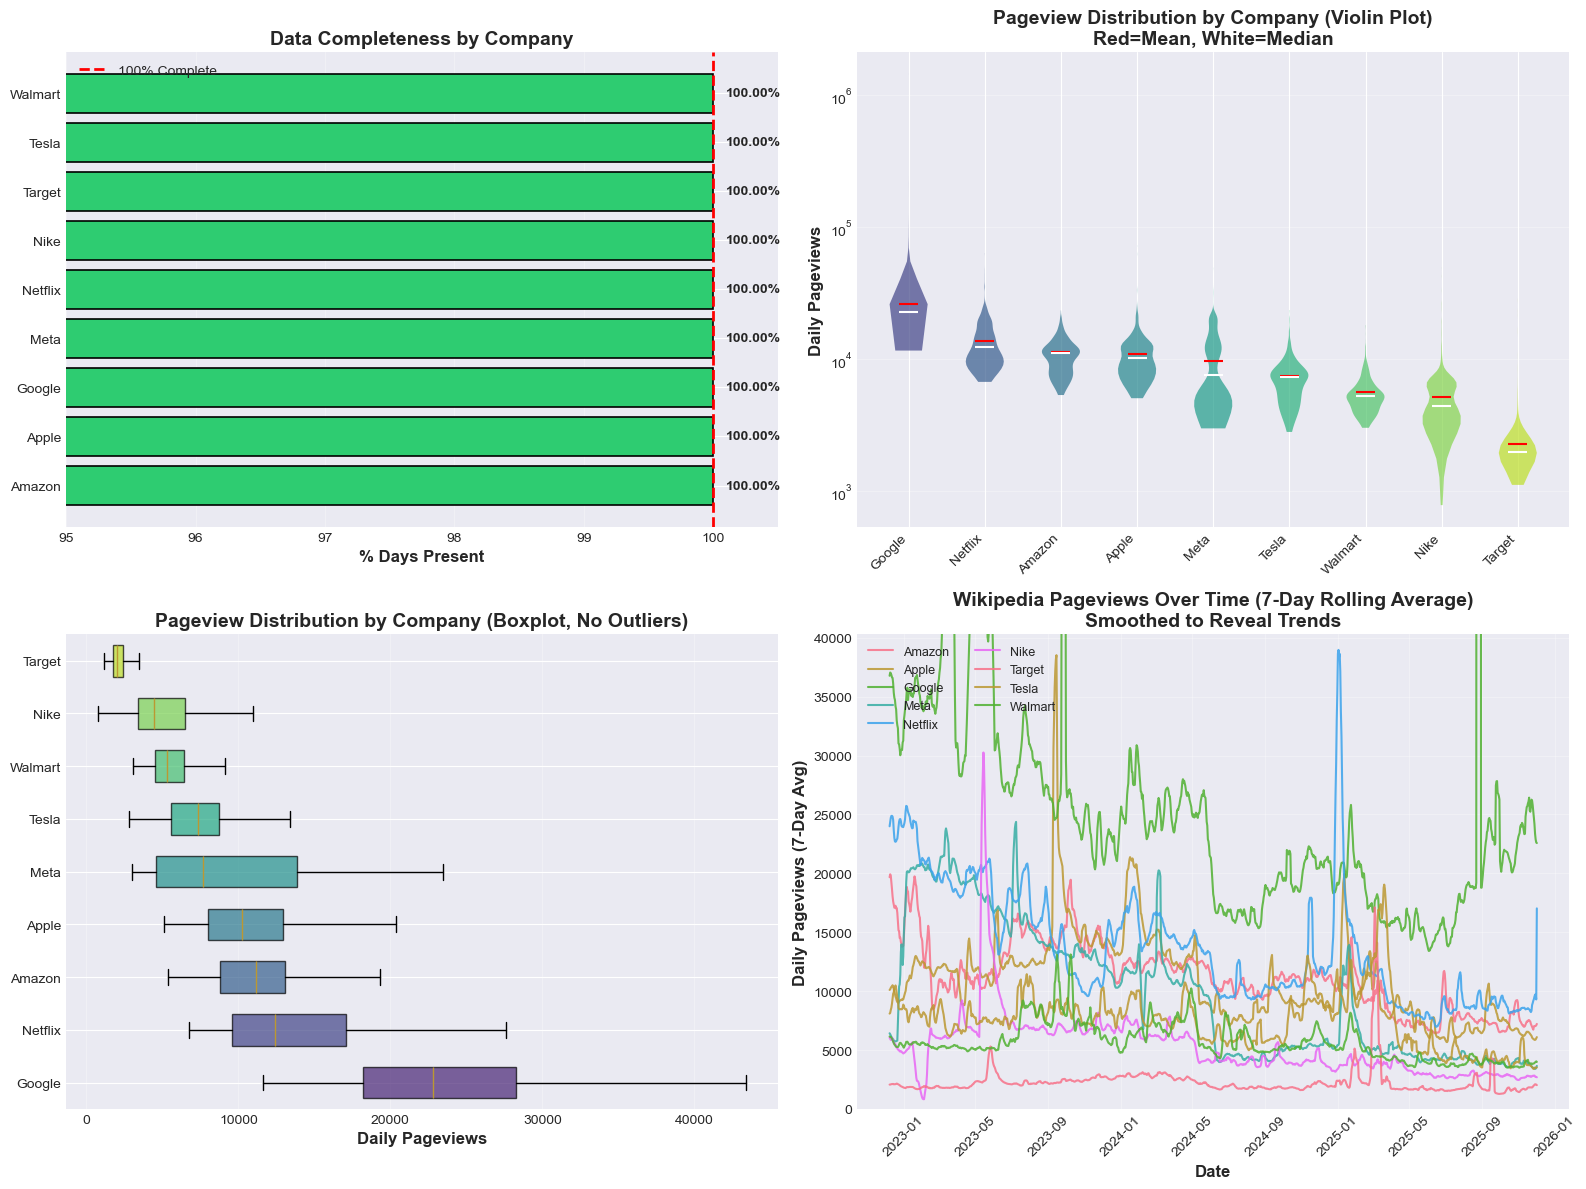


✅ Data quality visualizations complete.


In [30]:
# ============================================================================
# VISUALIZATION: DATA QUALITY
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. COMPLETENESS BAR CHART
ax1 = axes[0, 0]
companies = completeness_df['Company']
pct_present = completeness_df['Pct_Present']
colors = ['#2ecc71' if p >= 99.5 else '#e74c3c' for p in pct_present]

bars = ax1.barh(companies, pct_present, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('% Days Present', fontsize=12, fontweight='bold')
ax1.set_title('Data Completeness by Company', fontsize=14, fontweight='bold')
ax1.set_xlim(95, 100.5)
ax1.axvline(x=100, color='red', linestyle='--', linewidth=2, label='100% Complete')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, pct_present)):
    ax1.text(pct + 0.1, bar.get_y() + bar.get_height()/2, f'{pct:.2f}%', 
             va='center', fontsize=10, fontweight='bold')

# 2. DISTRIBUTION - VIOLIN PLOT (MUCH MORE INSIGHTFUL THAN OVERLAPPING HISTOGRAMS)
ax2 = axes[0, 1]
companies_by_median = full_df.groupby('company')['views'].median().sort_values(ascending=False).index.tolist()
violin_data = [full_df[full_df['company'] == c]['views'].values for c in companies_by_median]

parts = ax2.violinplot(violin_data, positions=range(len(companies_by_median)), 
                       showmeans=True, showmedians=True, showextrema=False)

# Color the violins
colors_violin = plt.cm.viridis(np.linspace(0.2, 0.9, len(companies_by_median)))
for idx, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors_violin[idx])
    pc.set_alpha(0.7)
parts['cmeans'].set_color('red')
parts['cmedians'].set_color('white')

ax2.set_xticks(range(len(companies_by_median)))
ax2.set_xticklabels(companies_by_median, rotation=45, ha='right')
ax2.set_ylabel('Daily Pageviews', fontsize=12, fontweight='bold')
ax2.set_title('Pageview Distribution by Company (Violin Plot)\nRed=Mean, White=Median', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')  # Log scale reveals the full distribution

# 3. BOXPLOT COMPARISON (Keep as is - it's useful)
ax3 = axes[1, 0]
companies_sorted = stats_df.index.tolist()
data_for_box = [full_df[full_df['company'] == c]['views'].values for c in companies_sorted]

bp = ax3.boxplot(data_for_box, labels=companies_sorted, patch_artist=True, vert=False,
                 showfliers=False, widths=0.6)

# Color boxes
colors_gradient = sns.color_palette('viridis', len(companies_sorted))
for patch, color in zip(bp['boxes'], colors_gradient):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_xlabel('Daily Pageviews', fontsize=12, fontweight='bold')
ax3.set_title('Pageview Distribution by Company (Boxplot, No Outliers)', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. TIME SERIES - SMOOTHED WITH ROLLING AVERAGE (FIXES OUTLIER ISSUE)
ax4 = axes[1, 1]

# Use 7-day rolling average to smooth out daily noise and reduce outlier impact
rolling_window = 7  # Weekly smoothing

for company in sorted(full_df['company'].unique()):
    company_data = full_df[full_df['company'] == company].sort_values('date').copy()
    company_data['views_smooth'] = company_data['views'].rolling(window=rolling_window, center=True).mean()
    ax4.plot(company_data['date'], company_data['views_smooth'], label=company, linewidth=1.5, alpha=0.85)

ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
ax4.set_ylabel('Daily Pageviews (7-Day Avg)', fontsize=12, fontweight='bold')
ax4.set_title('Wikipedia Pageviews Over Time (7-Day Rolling Average)\nSmoothed to Reveal Trends', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9, ncol=2)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Set y-axis limits based on percentiles to handle outliers better
all_smoothed = full_df.groupby('company').apply(
    lambda x: x.sort_values('date')['views'].rolling(window=rolling_window, center=True).mean()
).dropna()
y_upper = np.percentile(all_smoothed, 99)  # Cap at 99th percentile
ax4.set_ylim(0, y_upper * 1.1)

plt.tight_layout()
plt.show()

print("\n✅ Data quality visualizations complete.")


### 🔍 SECTION 1b: DETAILED COMPANY ANALYSIS

**Goal:** Visualize each company individually for clearer insight into trends and patterns.


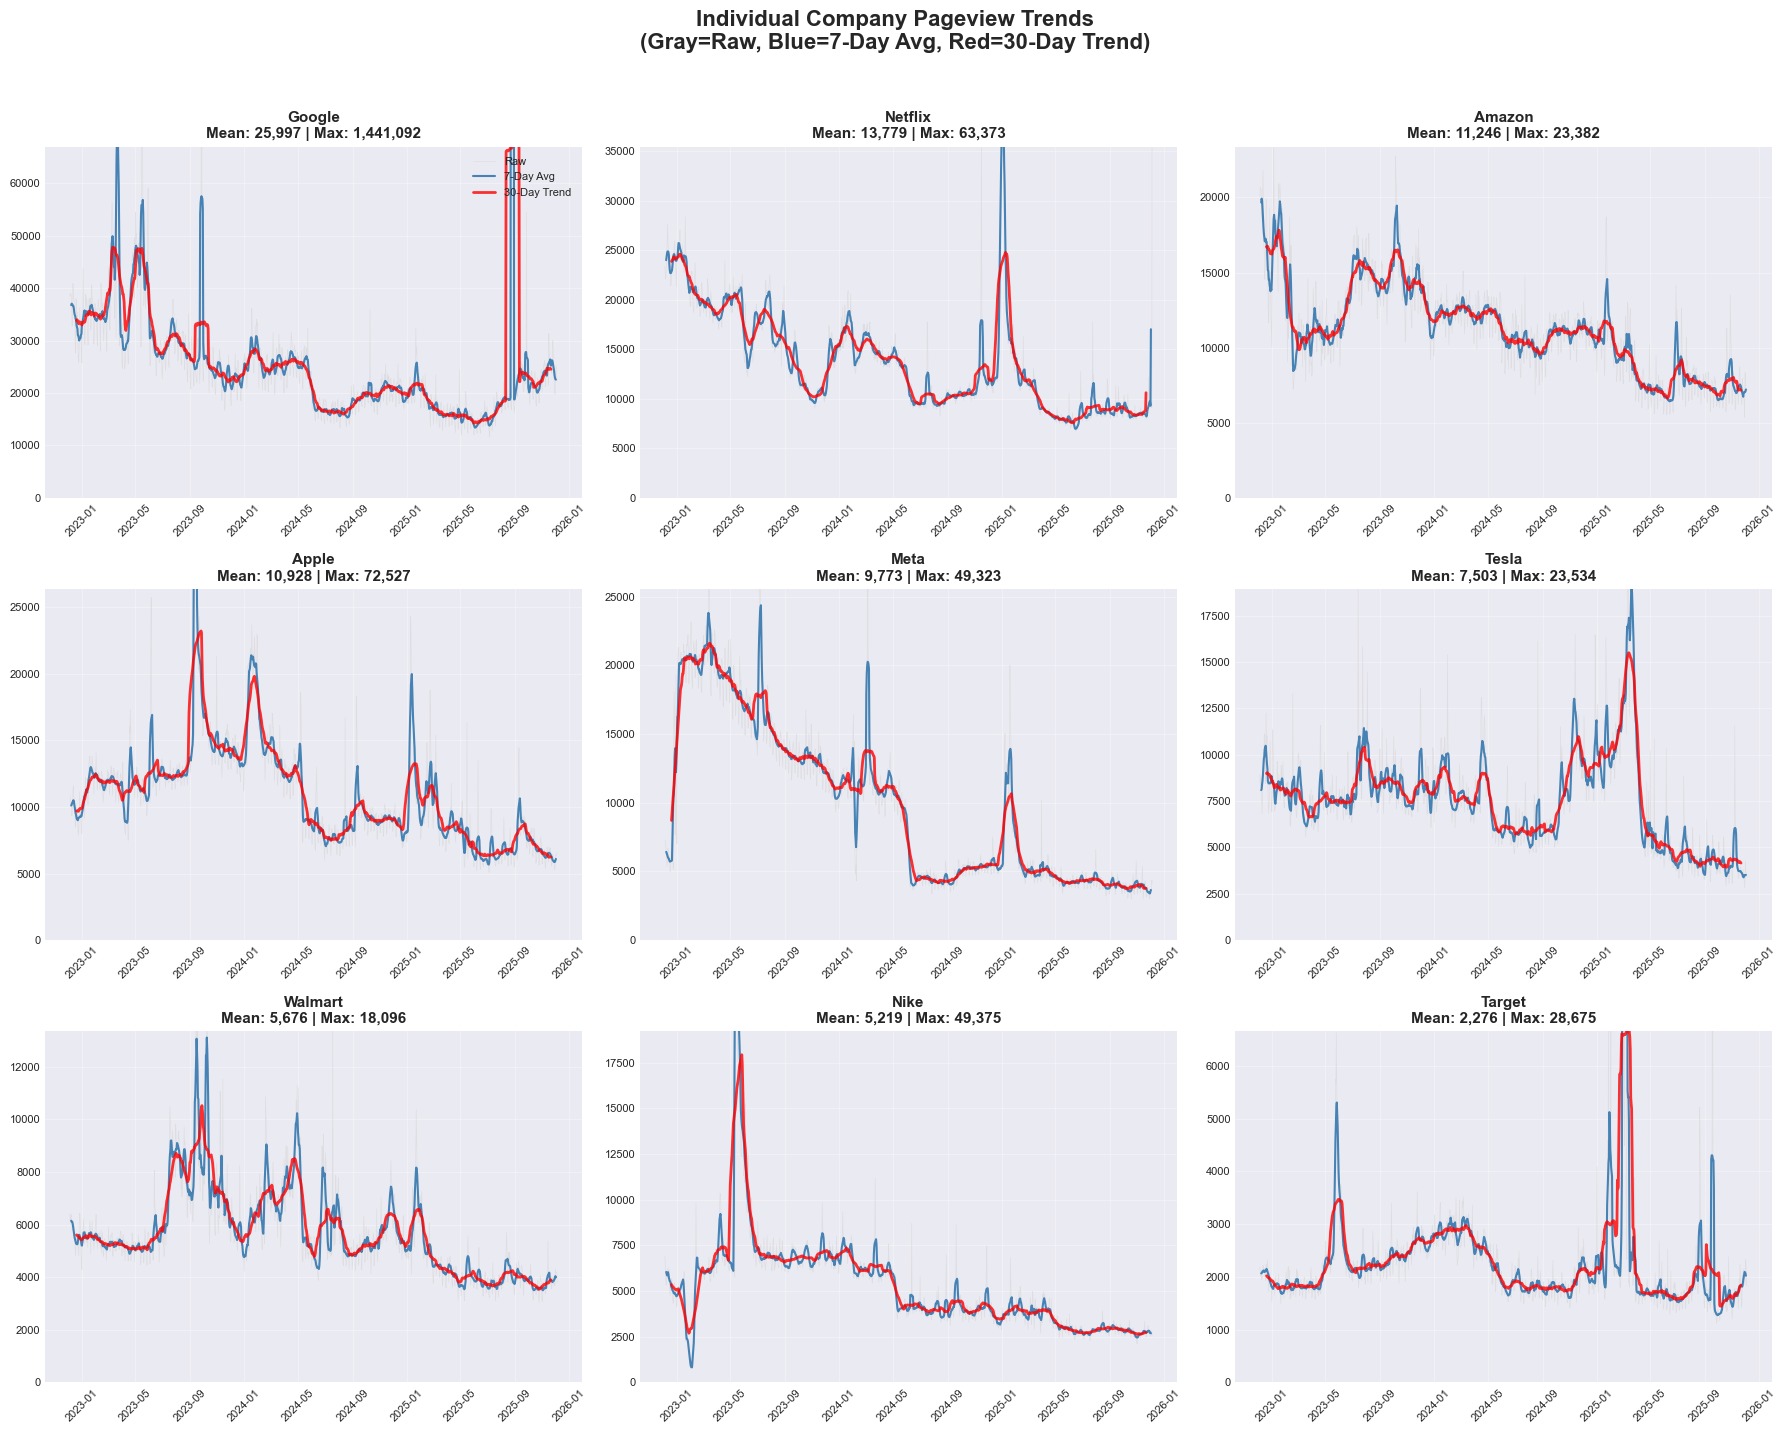


✅ Individual company time series complete.


In [32]:
# ============================================================================
# ENHANCED VISUALIZATIONS: INDIVIDUAL COMPANY TIME SERIES
# ============================================================================

# Create a 3x3 grid for individual company time series
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

companies_by_views = full_df.groupby('company')['views'].mean().sort_values(ascending=False).index.tolist()
rolling_window = 7

for idx, company in enumerate(companies_by_views):
    ax = axes[idx]
    company_data = full_df[full_df['company'] == company].sort_values('date').copy()
    
    # Raw data (faint)
    ax.plot(company_data['date'], company_data['views'], 
            color='lightgray', linewidth=0.5, alpha=0.5, label='Raw')
    
    # 7-day rolling average
    company_data['views_7d'] = company_data['views'].rolling(window=7, center=True).mean()
    ax.plot(company_data['date'], company_data['views_7d'], 
            color='steelblue', linewidth=1.5, label='7-Day Avg')
    
    # 30-day rolling average for trend
    company_data['views_30d'] = company_data['views'].rolling(window=30, center=True).mean()
    ax.plot(company_data['date'], company_data['views_30d'], 
            color='red', linewidth=2, alpha=0.8, label='30-Day Trend')
    
    # Statistics
    mean_views = company_data['views'].mean()
    max_views = company_data['views'].max()
    
    ax.set_title(f"{company}\nMean: {mean_views:,.0f} | Max: {max_views:,.0f}", 
                 fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    
    # Set y-limits using percentiles to handle outliers
    y_upper = np.percentile(company_data['views'], 99)
    ax.set_ylim(0, y_upper * 1.15)
    
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Individual Company Pageview Trends\n(Gray=Raw, Blue=7-Day Avg, Red=30-Day Trend)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Individual company time series complete.")


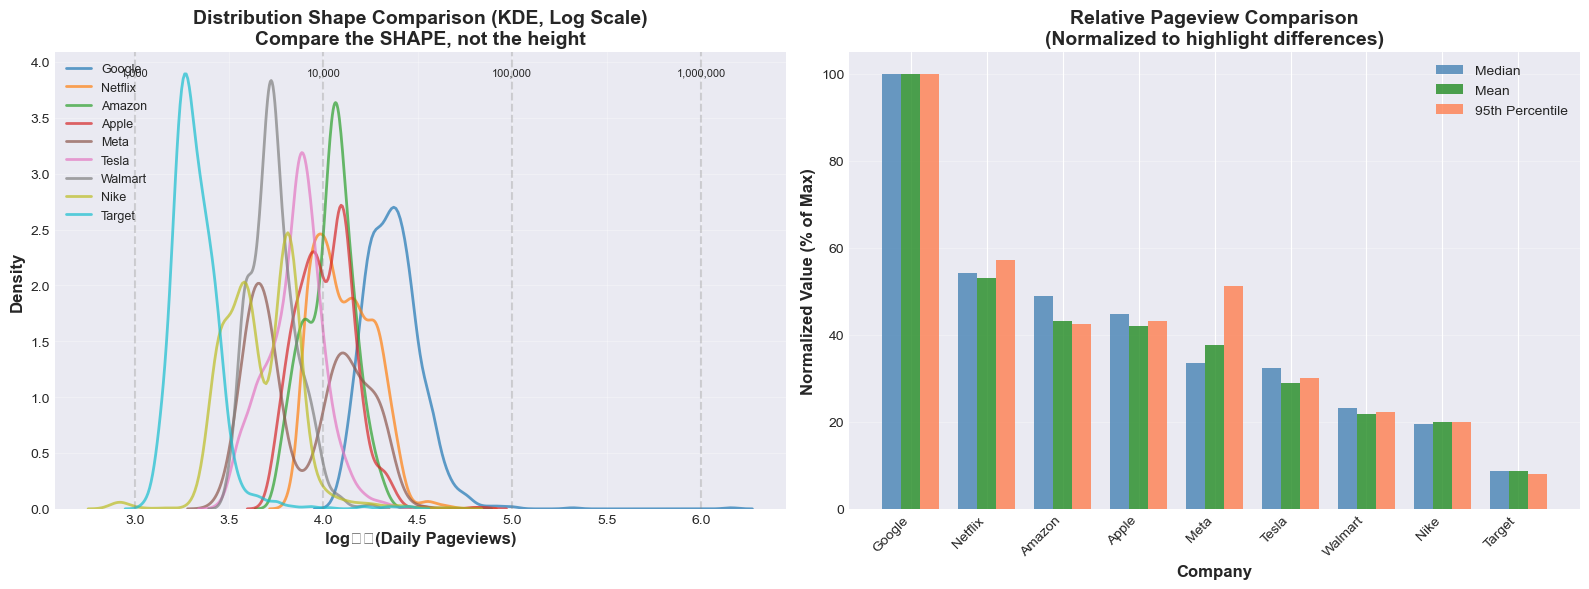


📊 VOLATILITY COMPARISON (Coefficient of Variation):
──────────────────────────────────────────────────
Google       | CV: 169.6% | █████████████████████████████████
Target       | CV:  74.3% | ██████████████
Meta         | CV:  61.4% | ████████████
Nike         | CV:  61.1% | ████████████
Apple        | CV:  40.9% | ████████
Netflix      | CV:  39.9% | ███████
Tesla        | CV:  36.0% | ███████
Walmart      | CV:  31.5% | ██████
Amazon       | CV:  28.2% | █████

✅ Distribution comparison complete.


In [33]:
# ============================================================================
# ENHANCED VISUALIZATIONS: DISTRIBUTION COMPARISON (KDE)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. KDE PLOT - NORMALIZED (Shows shape of distribution, not absolute scale)
ax1 = axes[0]
companies_by_views = full_df.groupby('company')['views'].mean().sort_values(ascending=False).index.tolist()
colors_kde = plt.cm.tab10(np.linspace(0, 1, len(companies_by_views)))

for idx, company in enumerate(companies_by_views):
    company_views = full_df[full_df['company'] == company]['views']
    # Use log-transformed data for better visualization
    log_views = np.log10(company_views + 1)
    sns.kdeplot(log_views, ax=ax1, label=company, color=colors_kde[idx], linewidth=2, alpha=0.7)

ax1.set_xlabel('log₁₀(Daily Pageviews)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Distribution Shape Comparison (KDE, Log Scale)\nCompare the SHAPE, not the height', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Add reference lines for scale
for exp in [3, 4, 5, 6]:  # 1K, 10K, 100K, 1M
    ax1.axvline(x=exp, color='gray', linestyle='--', alpha=0.3)
    ax1.text(exp, ax1.get_ylim()[1]*0.95, f'{10**exp:,.0f}', fontsize=8, ha='center')

# 2. COMPARATIVE BAR CHART - Key Statistics
ax2 = axes[1]

# Compute normalized statistics
compare_data = []
for company in companies_by_views:
    company_views = full_df[full_df['company'] == company]['views']
    compare_data.append({
        'Company': company,
        'Median': company_views.median(),
        'Mean': company_views.mean(),
        '95th Pct': company_views.quantile(0.95),
        'CV': company_views.std() / company_views.mean() * 100  # Coefficient of variation
    })

compare_df = pd.DataFrame(compare_data)

x = np.arange(len(companies_by_views))
width = 0.25

# Normalize to max for comparison
median_norm = compare_df['Median'] / compare_df['Median'].max() * 100
mean_norm = compare_df['Mean'] / compare_df['Mean'].max() * 100
p95_norm = compare_df['95th Pct'] / compare_df['95th Pct'].max() * 100

bars1 = ax2.bar(x - width, median_norm, width, label='Median', color='steelblue', alpha=0.8)
bars2 = ax2.bar(x, mean_norm, width, label='Mean', color='forestgreen', alpha=0.8)
bars3 = ax2.bar(x + width, p95_norm, width, label='95th Percentile', color='coral', alpha=0.8)

ax2.set_xlabel('Company', fontsize=12, fontweight='bold')
ax2.set_ylabel('Normalized Value (% of Max)', fontsize=12, fontweight='bold')
ax2.set_title('Relative Pageview Comparison\n(Normalized to highlight differences)', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(companies_by_views, rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print coefficient of variation (higher = more volatile)
print("\n📊 VOLATILITY COMPARISON (Coefficient of Variation):")
print(f"{'─'*50}")
for _, row in compare_df.sort_values('CV', ascending=False).iterrows():
    vol_bar = '█' * int(row['CV'] / 5)
    print(f"{row['Company']:12} | CV: {row['CV']:5.1f}% | {vol_bar}")

print("\n✅ Distribution comparison complete.")


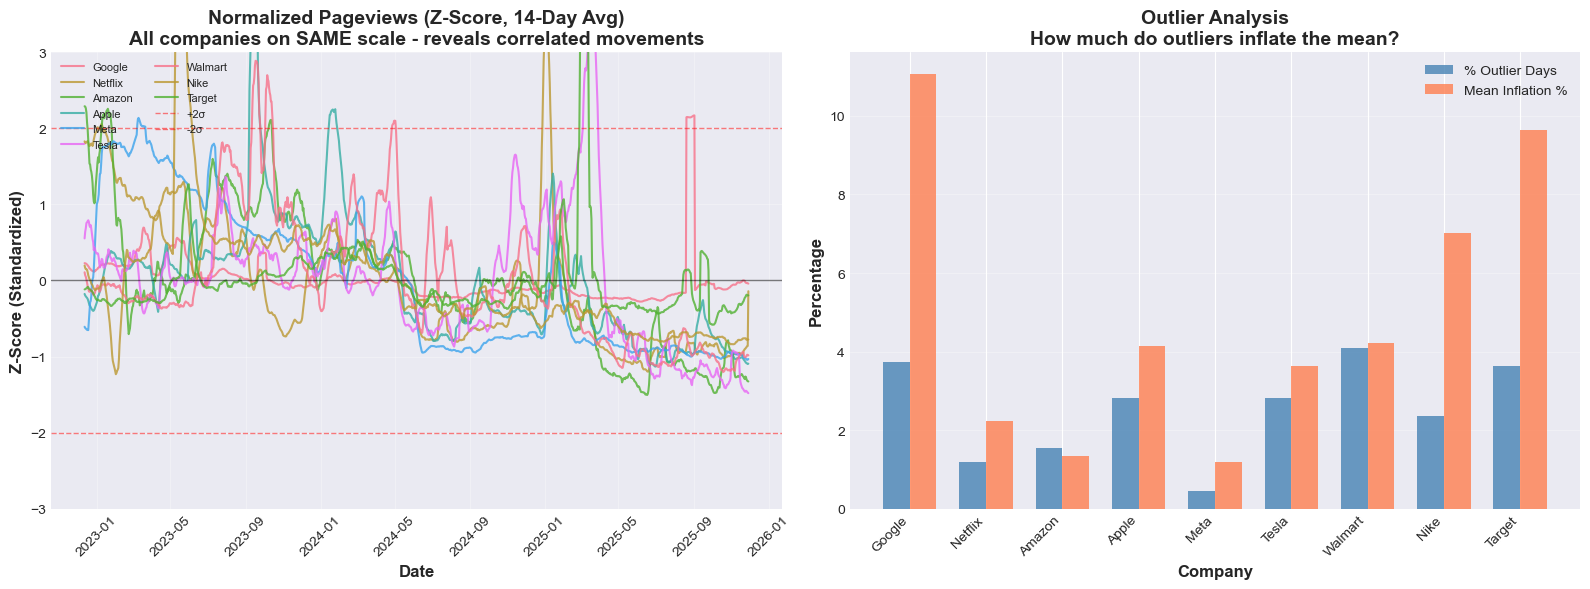


📊 OUTLIER IMPACT SUMMARY:
────────────────────────────────────────────────────────────
Google       |   3.7% outliers | Mean inflated by  11.1%
Netflix      |   1.2% outliers | Mean inflated by   2.2%
Amazon       |   1.5% outliers | Mean inflated by   1.4%
Apple        |   2.8% outliers | Mean inflated by   4.1%
Meta         |   0.5% outliers | Mean inflated by   1.2%
Tesla        |   2.8% outliers | Mean inflated by   3.6%
Walmart      |   4.1% outliers | Mean inflated by   4.2%
Nike         |   2.4% outliers | Mean inflated by   7.0%
Target       |   3.6% outliers | Mean inflated by   9.6%

✅ Outlier analysis complete.


In [34]:
# ============================================================================
# ENHANCED VISUALIZATIONS: OUTLIER ANALYSIS & NORMALIZED COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Z-SCORE NORMALIZED TIME SERIES (All companies on same scale)
ax1 = axes[0]

companies_by_views = full_df.groupby('company')['views'].mean().sort_values(ascending=False).index.tolist()

for company in companies_by_views:
    company_data = full_df[full_df['company'] == company].sort_values('date').copy()
    # Z-score normalization
    mean_v = company_data['views'].mean()
    std_v = company_data['views'].std()
    company_data['z_score'] = (company_data['views'] - mean_v) / std_v
    # Smooth
    company_data['z_smooth'] = company_data['z_score'].rolling(window=14, center=True).mean()
    ax1.plot(company_data['date'], company_data['z_smooth'], label=company, linewidth=1.5, alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.axhline(y=2, color='red', linestyle='--', linewidth=1, alpha=0.5, label='+2σ')
ax1.axhline(y=-2, color='red', linestyle='--', linewidth=1, alpha=0.5, label='-2σ')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Z-Score (Standardized)', fontsize=12, fontweight='bold')
ax1.set_title('Normalized Pageviews (Z-Score, 14-Day Avg)\nAll companies on SAME scale - reveals correlated movements', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(-3, 3)

# 2. OUTLIER IMPACT ANALYSIS
ax2 = axes[1]

outlier_analysis = []
for company in companies_by_views:
    company_views = full_df[full_df['company'] == company]['views']
    q1 = company_views.quantile(0.25)
    q3 = company_views.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = company_views[(company_views < lower_bound) | (company_views > upper_bound)]
    outlier_pct = len(outliers) / len(company_views) * 100
    
    # Impact: How much do outliers affect the mean?
    mean_all = company_views.mean()
    mean_no_outliers = company_views[(company_views >= lower_bound) & (company_views <= upper_bound)].mean()
    impact = ((mean_all - mean_no_outliers) / mean_no_outliers) * 100
    
    outlier_analysis.append({
        'Company': company,
        'Outlier %': outlier_pct,
        'Mean Impact %': impact
    })

outlier_df = pd.DataFrame(outlier_analysis)

x = np.arange(len(outlier_df))
width = 0.35

bars1 = ax2.bar(x - width/2, outlier_df['Outlier %'], width, label='% Outlier Days', 
               color='steelblue', alpha=0.8)
bars2 = ax2.bar(x + width/2, outlier_df['Mean Impact %'], width, label='Mean Inflation %', 
               color='coral', alpha=0.8)

ax2.set_xlabel('Company', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage', fontsize=12, fontweight='bold')
ax2.set_title('Outlier Analysis\nHow much do outliers inflate the mean?', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(outlier_df['Company'], rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 OUTLIER IMPACT SUMMARY:")
print(f"{'─'*60}")
for _, row in outlier_df.iterrows():
    print(f"{row['Company']:12} | {row['Outlier %']:5.1f}% outliers | Mean inflated by {row['Mean Impact %']:5.1f}%")

print("\n✅ Outlier analysis complete.")


### 📈 SECTION 2: SEASONALITY & TRENDS

**Goal:** Identify weekly cycles, seasonal patterns, and long-term trends that affect predictive features.


In [36]:
# ============================================================================
# SEASONALITY & TRENDS ANALYSIS
# ============================================================================

from statsmodels.tsa.seasonal import seasonal_decompose

print("="*70)
print("SEASONALITY & TRENDS ANALYSIS")
print("="*70)

# Add temporal features to dataframe
analysis_df = full_df.copy()
analysis_df['dayofweek'] = analysis_df['date'].dt.dayofweek  # Monday=0, Sunday=6
analysis_df['day_name'] = analysis_df['date'].dt.day_name()
analysis_df['month'] = analysis_df['date'].dt.month
analysis_df['month_name'] = analysis_df['date'].dt.month_name()
analysis_df['year'] = analysis_df['date'].dt.year
analysis_df['quarter'] = analysis_df['date'].dt.quarter
analysis_df['is_weekend'] = analysis_df['dayofweek'].isin([5, 6]).astype(int)

# 1. WEEKLY PATTERNS
print(f"\n📅 WEEKLY PATTERNS (Day of Week Effect)")
print(f"{'─'*70}")

dow_stats = analysis_df.groupby('day_name')['views'].agg(['mean', 'median', 'std']).round(0)
# Reorder by actual day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = dow_stats.reindex(day_order)
print(dow_stats.to_string())

# Weekend vs Weekday comparison
weekday_avg = analysis_df[analysis_df['is_weekend'] == 0]['views'].mean()
weekend_avg = analysis_df[analysis_df['is_weekend'] == 1]['views'].mean()
weekend_diff_pct = ((weekend_avg - weekday_avg) / weekday_avg) * 100

print(f"\n  Weekday average: {weekday_avg:,.0f} views")
print(f"  Weekend average: {weekend_avg:,.0f} views")
print(f"  Weekend effect: {weekend_diff_pct:+.1f}% {'📉' if weekend_diff_pct < 0 else '📈'}")

# 2. MONTHLY PATTERNS
print(f"\n📆 MONTHLY PATTERNS (Seasonality)")
print(f"{'─'*70}")

monthly_stats = analysis_df.groupby('month_name')['views'].agg(['mean', 'median', 'std']).round(0)
# Reorder by actual month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_stats = monthly_stats.reindex(month_order)
print(monthly_stats.to_string())

# 3. LONG-TERM TRENDS
print(f"\n📊 LONG-TERM TRENDS (Year-over-Year)")
print(f"{'─'*70}")

yearly_stats = analysis_df.groupby(['year', 'company'])['views'].mean().reset_index()
yearly_pivot = yearly_stats.pivot(index='year', columns='company', values='views').round(0)
print(yearly_pivot.to_string())

# Calculate YoY growth rates
print(f"\n📈 YEAR-OVER-YEAR GROWTH RATES (%)")
print(f"{'─'*70}")

yoy_growth = yearly_pivot.pct_change() * 100
print(yoy_growth.round(1).to_string())

# 4. ROLLING AVERAGES (SMOOTHING)
print(f"\n🔄 CALCULATING ROLLING AVERAGES (7-day, 30-day, 90-day)")
print(f"{'─'*70}")

# Sort by company and date for rolling calculations
analysis_df = analysis_df.sort_values(['company', 'date'])

# Calculate rolling averages for each company
for company in analysis_df['company'].unique():
    mask = analysis_df['company'] == company
    analysis_df.loc[mask, 'views_7d_ma'] = analysis_df.loc[mask, 'views'].rolling(window=7, min_periods=1).mean()
    analysis_df.loc[mask, 'views_30d_ma'] = analysis_df.loc[mask, 'views'].rolling(window=30, min_periods=1).mean()
    analysis_df.loc[mask, 'views_90d_ma'] = analysis_df.loc[mask, 'views'].rolling(window=90, min_periods=1).mean()

print("✅ Rolling averages calculated successfully.")

# 5. VOLATILITY BY COMPANY
print(f"\n📉 VOLATILITY COMPARISON (Coefficient of Variation)")
print(f"{'─'*70}")

volatility_df = full_df.groupby('company')['views'].agg([
    ('mean', 'mean'),
    ('std', 'std')
])
volatility_df['cv'] = (volatility_df['std'] / volatility_df['mean']) * 100  # Coefficient of Variation
volatility_df = volatility_df.sort_values('cv', ascending=False)

for company, row in volatility_df.iterrows():
    stability = "🔴 High Noise" if row['cv'] > 30 else "🟢 Stable" if row['cv'] < 20 else "🟡 Moderate"
    print(f"{company:12} | CV: {row['cv']:5.1f}% | {stability}")

print(f"\n{'='*70}")
print("✅ SEASONALITY & TRENDS ANALYSIS COMPLETE")
print(f"{'='*70}")


SEASONALITY & TRENDS ANALYSIS

📅 WEEKLY PATTERNS (Day of Week Effect)
──────────────────────────────────────────────────────────────────────
              mean  median      std
day_name                           
Monday     10378.0  8250.0   7745.0
Tuesday    11651.0  8328.0  38976.0
Wednesday  10586.0  8302.0   9706.0
Thursday   10461.0  8308.0   8053.0
Friday     10046.0  8072.0   7679.0
Saturday    9334.0  7359.0   7111.0
Sunday      9398.0  7684.0   6823.0

  Weekday average: 10,624 views
  Weekend average: 9,366 views
  Weekend effect: -11.8% 📉

📆 MONTHLY PATTERNS (Seasonality)
──────────────────────────────────────────────────────────────────────
               mean   median      std
month_name                           
January     12661.0  10826.0   8755.0
February    11101.0   9665.0   7556.0
March       11670.0   9639.0   9930.0
April       10429.0   8482.0   7613.0
May         10630.0   7601.0   9758.0
June         8655.0   6981.0   6128.0
July         9113.0   7327.0   6681

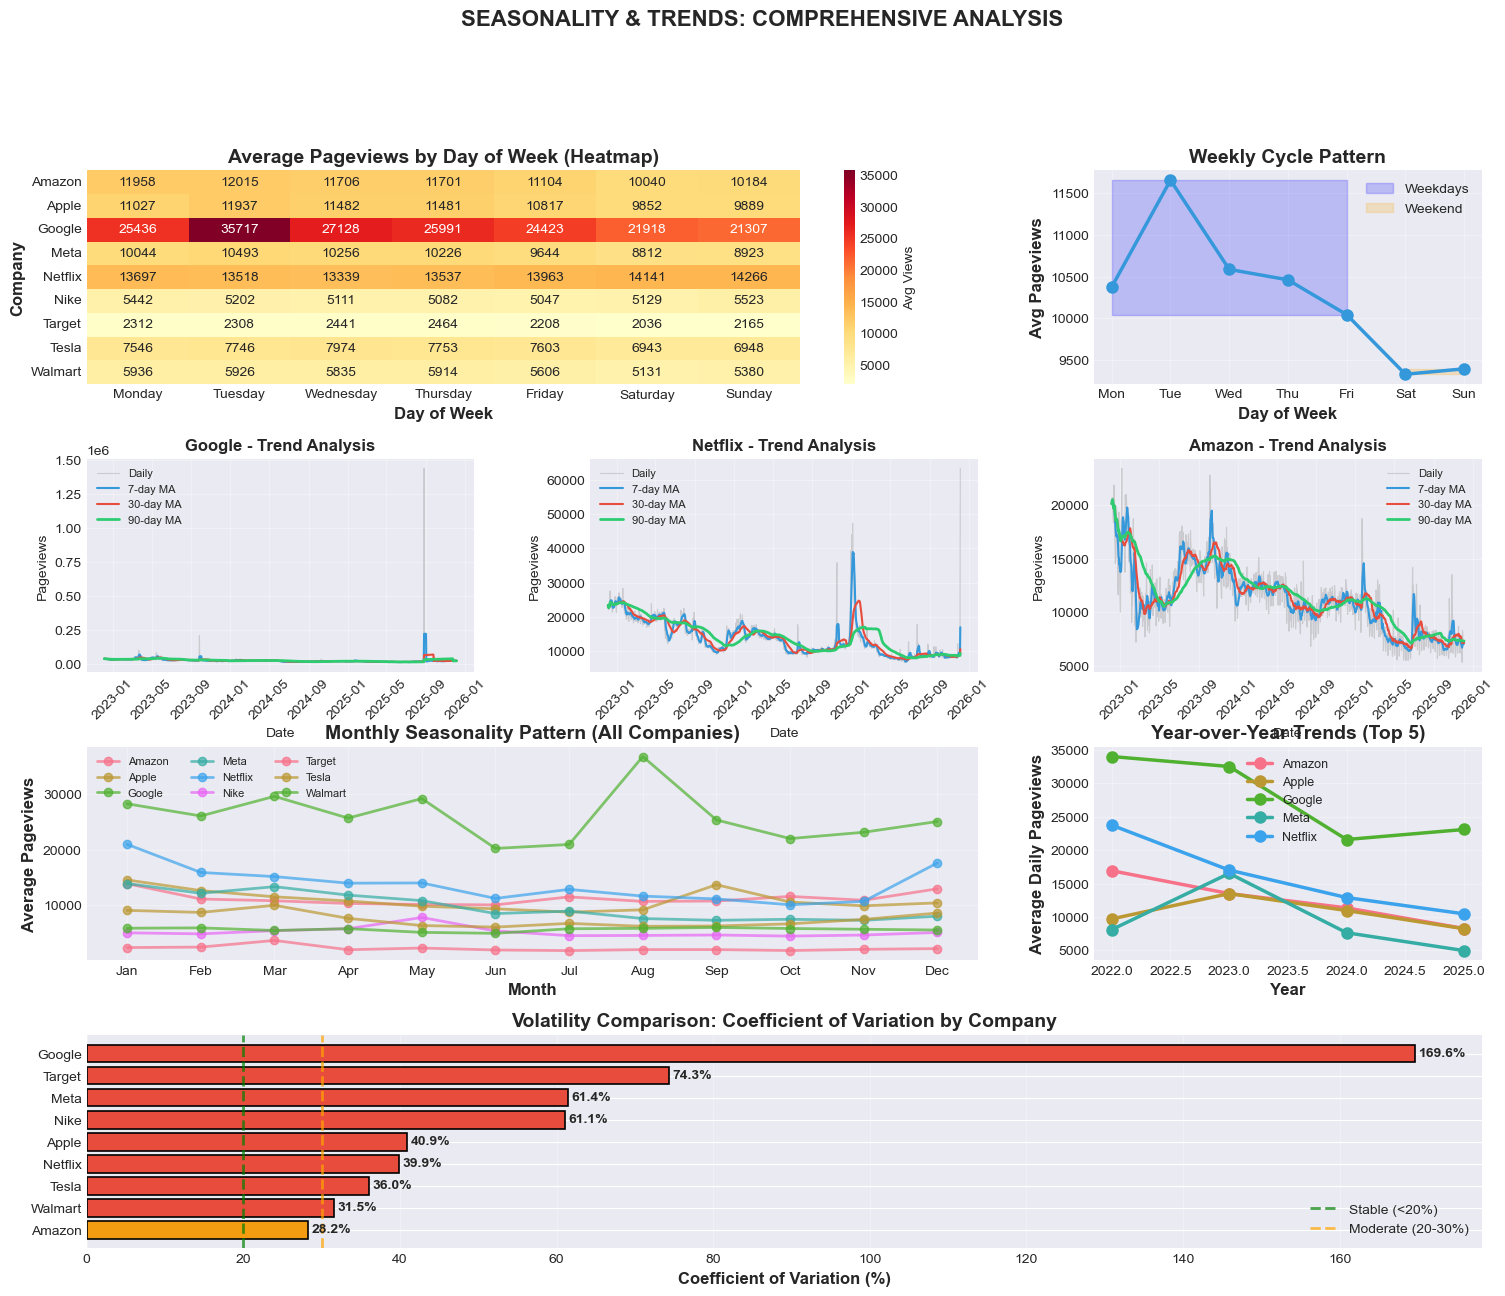


✅ Seasonality & trends visualizations complete.


In [37]:
# ============================================================================
# VISUALIZATION: SEASONALITY & TRENDS
# ============================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. DAY OF WEEK HEATMAP
ax1 = fig.add_subplot(gs[0, :2])
dow_pivot = analysis_df.groupby(['company', 'day_name'])['views'].mean().reset_index()
dow_pivot = dow_pivot.pivot(index='company', columns='day_name', values='views')
dow_pivot = dow_pivot[day_order]  # Reorder columns

sns.heatmap(dow_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Avg Views'})
ax1.set_title('Average Pageviews by Day of Week (Heatmap)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_ylabel('Company', fontsize=12, fontweight='bold')

# 2. WEEKLY CYCLE PLOT
ax2 = fig.add_subplot(gs[0, 2])
dow_avg = analysis_df.groupby('dayofweek')['views'].mean()
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax2.plot(range(7), dow_avg.values, marker='o', linewidth=2.5, markersize=8, color='#3498db')
ax2.fill_between(range(5), dow_avg.values[:5].min(), dow_avg.values[:5].max(), alpha=0.2, color='blue', label='Weekdays')
ax2.fill_between(range(5, 7), dow_avg.values[5:7].min(), dow_avg.values[5:7].max(), alpha=0.2, color='orange', label='Weekend')
ax2.set_xticks(range(7))
ax2.set_xticklabels(days_labels)
ax2.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax2.set_ylabel('Avg Pageviews', fontsize=12, fontweight='bold')
ax2.set_title('Weekly Cycle Pattern', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3-5. ROLLING AVERAGES FOR TOP 3 COMPANIES BY VIEWS
top_3_companies = stats_df.head(3).index.tolist()

for idx, company in enumerate(top_3_companies):
    ax = fig.add_subplot(gs[1, idx])
    company_data = analysis_df[analysis_df['company'] == company].sort_values('date')
    
    ax.plot(company_data['date'], company_data['views'], alpha=0.3, linewidth=0.8, color='gray', label='Daily')
    ax.plot(company_data['date'], company_data['views_7d_ma'], linewidth=1.5, label='7-day MA', color='#3498db')
    ax.plot(company_data['date'], company_data['views_30d_ma'], linewidth=1.5, label='30-day MA', color='#e74c3c')
    ax.plot(company_data['date'], company_data['views_90d_ma'], linewidth=2, label='90-day MA', color='#2ecc71')
    
    ax.set_title(f'{company} - Trend Analysis', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Pageviews', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# 6. MONTHLY SEASONALITY
ax6 = fig.add_subplot(gs[2, :2])
monthly_pivot = analysis_df.groupby(['month', 'company'])['views'].mean().reset_index()
for company in sorted(analysis_df['company'].unique()):
    company_monthly = monthly_pivot[monthly_pivot['company'] == company]
    ax6.plot(company_monthly['month'], company_monthly['views'], marker='o', label=company, linewidth=2, alpha=0.7)

ax6.set_xticks(range(1, 13))
ax6.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax6.set_xlabel('Month', fontsize=12, fontweight='bold')
ax6.set_ylabel('Average Pageviews', fontsize=12, fontweight='bold')
ax6.set_title('Monthly Seasonality Pattern (All Companies)', fontsize=14, fontweight='bold')
ax6.legend(loc='upper left', fontsize=8, ncol=3)
ax6.grid(True, alpha=0.3)

# 7. YEAR-OVER-YEAR TRENDS
ax7 = fig.add_subplot(gs[2, 2])
for company in yearly_pivot.columns[:5]:  # Top 5 companies to avoid clutter
    ax7.plot(yearly_pivot.index, yearly_pivot[company], marker='o', label=company, linewidth=2.5, markersize=8)

ax7.set_xlabel('Year', fontsize=12, fontweight='bold')
ax7.set_ylabel('Average Daily Pageviews', fontsize=12, fontweight='bold')
ax7.set_title('Year-over-Year Trends (Top 5)', fontsize=14, fontweight='bold')
ax7.legend(loc='best', fontsize=9)
ax7.grid(True, alpha=0.3)

# 8. VOLATILITY COMPARISON
ax8 = fig.add_subplot(gs[3, :])
volatility_sorted = volatility_df.sort_values('cv', ascending=True)
colors_vol = ['#2ecc71' if cv < 20 else '#f39c12' if cv < 30 else '#e74c3c' for cv in volatility_sorted['cv']]

bars = ax8.barh(volatility_sorted.index, volatility_sorted['cv'], color=colors_vol, edgecolor='black', linewidth=1.2)
ax8.set_xlabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax8.set_title('Volatility Comparison: Coefficient of Variation by Company', fontsize=14, fontweight='bold')
ax8.axvline(x=20, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Stable (<20%)')
ax8.axvline(x=30, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Moderate (20-30%)')
ax8.legend(loc='lower right')
ax8.grid(axis='x', alpha=0.3)

# Add value labels
for bar, cv in zip(bars, volatility_sorted['cv']):
    ax8.text(cv + 0.5, bar.get_y() + bar.get_height()/2, f'{cv:.1f}%', 
             va='center', fontsize=10, fontweight='bold')

plt.suptitle('SEASONALITY & TRENDS: COMPREHENSIVE ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Seasonality & trends visualizations complete.")


### 🚨 SECTION 3: SPIKES & ANOMALY DETECTION

**Goal:** Identify significant pageview spikes that may correlate with news events, earnings, or market-moving events.


In [39]:
# ============================================================================
# SPIKE DETECTION & ANOMALY ANALYSIS
# ============================================================================

print("="*70)
print("SPIKE DETECTION & ANOMALY ANALYSIS")
print("="*70)

# Calculate z-scores for each company (normalized spikes)
spike_analysis_df = analysis_df.copy()

for company in spike_analysis_df['company'].unique():
    mask = spike_analysis_df['company'] == company
    company_views = spike_analysis_df.loc[mask, 'views']
    
    # Calculate z-score
    mean_views = company_views.mean()
    std_views = company_views.std()
    spike_analysis_df.loc[mask, 'z_score'] = (company_views - mean_views) / std_views
    
    # Flag spikes (±3 sigma)
    spike_analysis_df.loc[mask, 'is_spike'] = (spike_analysis_df.loc[mask, 'z_score'].abs() >= 3).astype(int)

# Identify all spikes
spikes = spike_analysis_df[spike_analysis_df['is_spike'] == 1].copy()
spikes = spikes.sort_values('z_score', ascending=False)

print(f"\n🔍 SPIKE SUMMARY")
print(f"{'─'*70}")
print(f"Total spikes detected (±3σ): {len(spikes)}")
print(f"Positive spikes (>3σ): {len(spikes[spikes['z_score'] > 0])}")
print(f"Negative spikes (<-3σ): {len(spikes[spikes['z_score'] < 0])}")
print(f"\nSpikes by company:")

spike_counts = spikes.groupby('company').size().sort_values(ascending=False)
for company, count in spike_counts.items():
    pct_of_days = (count / len(analysis_df[analysis_df['company'] == company])) * 100
    print(f"  {company:12} | {count:3d} spikes ({pct_of_days:.2f}% of days)")

# Top 10 spikes per company
print(f"\n📊 TOP 10 LARGEST SPIKES PER COMPANY")
print(f"{'─'*70}")

top_spikes_all = []

for company in sorted(spike_analysis_df['company'].unique()):
    company_data = spike_analysis_df[spike_analysis_df['company'] == company].copy()
    top_spikes = company_data.nlargest(10, 'z_score')[['date', 'views', 'z_score']]
    
    print(f"\n{company}:")
    print(f"{'Date':<12} | {'Views':>8} | {'Z-Score':>8}")
    print(f"{'-'*35}")
    
    for _, row in top_spikes.iterrows():
        top_spikes_all.append({
            'company': company,
            'date': row['date'],
            'views': row['views'],
            'z_score': row['z_score']
        })
        print(f"{row['date'].strftime('%Y-%m-%d'):<12} | {row['views']:>8,.0f} | {row['z_score']:>8.2f}")

# Create DataFrame of all top spikes
top_spikes_df = pd.DataFrame(top_spikes_all)

print(f"\n{'='*70}")
print("✅ SPIKE DETECTION COMPLETE")
print(f"{'='*70}")



SPIKE DETECTION & ANOMALY ANALYSIS

🔍 SPIKE SUMMARY
──────────────────────────────────────────────────────────────────────
Total spikes detected (±3σ): 90
Positive spikes (>3σ): 90
Negative spikes (<-3σ): 0

Spikes by company:
  Tesla        |  17 spikes (1.55% of days)
  Nike         |  16 spikes (1.46% of days)
  Walmart      |  16 spikes (1.46% of days)
  Netflix      |  12 spikes (1.09% of days)
  Target       |   9 spikes (0.82% of days)
  Amazon       |   7 spikes (0.64% of days)
  Apple        |   6 spikes (0.55% of days)
  Meta         |   5 spikes (0.46% of days)
  Google       |   2 spikes (0.18% of days)

📊 TOP 10 LARGEST SPIKES PER COMPANY
──────────────────────────────────────────────────────────────────────

Amazon:
Date         |    Views |  Z-Score
-----------------------------------
2023-01-05   |   23,382 |     3.82
2023-10-06   |   22,763 |     3.63
2022-12-12   |   21,817 |     3.33
2023-10-07   |   21,274 |     3.16
2023-01-19   |   20,957 |     3.06
2023-01-16   |

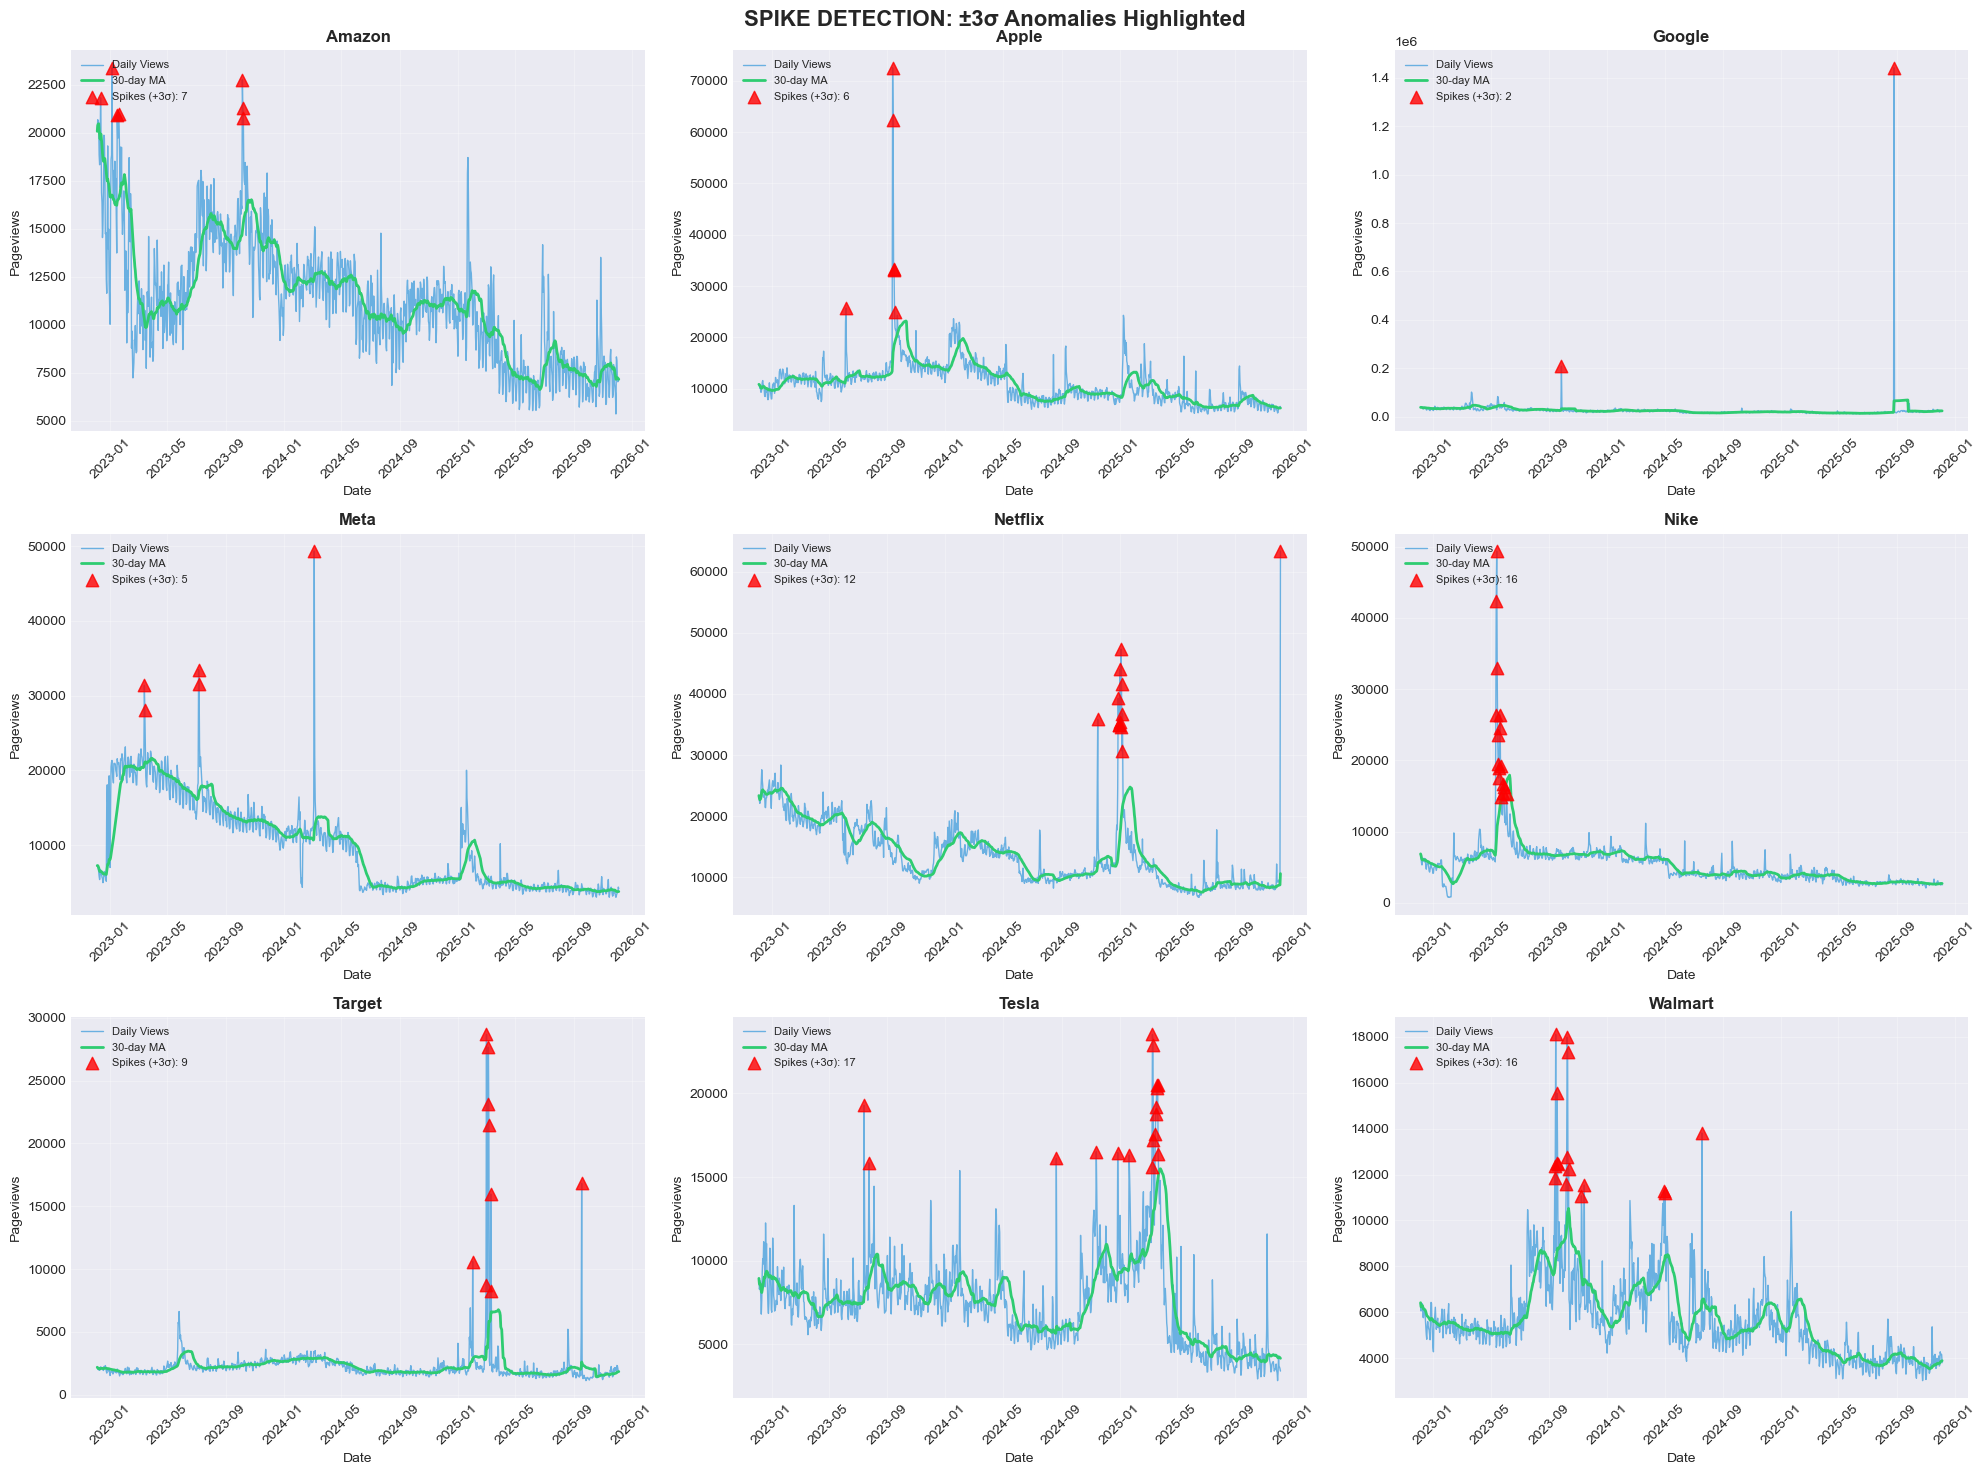


✅ Spike detection visualizations complete.


In [40]:
# ============================================================================
# VISUALIZATION: SPIKE DETECTION
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# Plot time series with highlighted spikes for each company
for idx, company in enumerate(sorted(spike_analysis_df['company'].unique())):
    ax = axes[idx]
    company_data = spike_analysis_df[spike_analysis_df['company'] == company].sort_values('date')
    
    # Plot base time series
    ax.plot(company_data['date'], company_data['views'], linewidth=1, color='#3498db', alpha=0.7, label='Daily Views')
    ax.plot(company_data['date'], company_data['views_30d_ma'], linewidth=2, color='#2ecc71', label='30-day MA')
    
    # Highlight spikes
    spikes_company = company_data[company_data['is_spike'] == 1]
    positive_spikes = spikes_company[spikes_company['z_score'] > 0]
    negative_spikes = spikes_company[spikes_company['z_score'] < 0]
    
    ax.scatter(positive_spikes['date'], positive_spikes['views'], 
              color='red', s=80, marker='^', zorder=5, label=f'Spikes (+3σ): {len(positive_spikes)}', alpha=0.8)
    
    if len(negative_spikes) > 0:
        ax.scatter(negative_spikes['date'], negative_spikes['views'], 
                  color='purple', s=80, marker='v', zorder=5, label=f'Spikes (-3σ): {len(negative_spikes)}', alpha=0.8)
    
    ax.set_title(f'{company}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Pageviews', fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('SPIKE DETECTION: ±3σ Anomalies Highlighted', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Spike detection visualizations complete.")


### 🔬 SECTION 4: STABILITY VS NOISE (Autocorrelation Analysis)

**Goal:** Determine signal quality through autocorrelation, persistence, and mean reversion characteristics.


In [42]:
# ============================================================================
# AUTOCORRELATION & STABILITY ANALYSIS
# ============================================================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

print("="*70)
print("AUTOCORRELATION & STABILITY ANALYSIS")
print("="*70)

# 1. AUTOCORRELATION AT VARIOUS LAGS
print(f"\n📊 AUTOCORRELATION COEFFICIENTS (Selected Lags)")
print(f"{'─'*70}")
print(f"{'Company':12} | {'Lag-1':>7} | {'Lag-7':>7} | {'Lag-30':>7} | {'Lag-90':>7}")
print(f"{'-'*60}")

autocorr_results = []

for company in sorted(analysis_df['company'].unique()):
    company_data = analysis_df[analysis_df['company'] == company].sort_values('date')
    views_series = company_data['views']
    
    # Calculate autocorrelations at specific lags
    acf_1 = views_series.autocorr(lag=1)
    acf_7 = views_series.autocorr(lag=7)
    acf_30 = views_series.autocorr(lag=30)
    acf_90 = views_series.autocorr(lag=90)
    
    autocorr_results.append({
        'Company': company,
        'ACF_1': acf_1,
        'ACF_7': acf_7,
        'ACF_30': acf_30,
        'ACF_90': acf_90
    })
    
    print(f"{company:12} | {acf_1:>7.3f} | {acf_7:>7.3f} | {acf_30:>7.3f} | {acf_90:>7.3f}")

autocorr_df = pd.DataFrame(autocorr_results)

# 2. STATIONARITY TEST (Augmented Dickey-Fuller)
print(f"\n📉 STATIONARITY TEST (Augmented Dickey-Fuller)")
print(f"{'─'*70}")
print(f"{'Company':12} | {'ADF Stat':>10} | {'P-Value':>10} | {'Stationary?':>12}")
print(f"{'-'*50}")

stationarity_results = []

for company in sorted(analysis_df['company'].unique()):
    company_data = analysis_df[analysis_df['company'] == company].sort_values('date')
    views_series = company_data['views'].dropna()
    
    # Perform ADF test
    adf_result = adfuller(views_series, autolag='AIC')
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    is_stationary = p_value < 0.05
    
    stationarity_results.append({
        'Company': company,
        'ADF_Stat': adf_stat,
        'P_Value': p_value,
        'Stationary': is_stationary
    })
    
    status = "✅ Yes" if is_stationary else "❌ No"
    print(f"{company:12} | {adf_stat:>10.3f} | {p_value:>10.4f} | {status:>12}")

stationarity_df = pd.DataFrame(stationarity_results)

# 3. PERSISTENCE VS MEAN REVERSION
print(f"\n🔄 PERSISTENCE CHARACTERISTICS")
print(f"{'─'*70}")

for company in sorted(analysis_df['company'].unique()):
    company_data = analysis_df[analysis_df['company'] == company].sort_values('date')
    
    # Calculate half-life of mean reversion (if mean-reverting)
    views_series = company_data['views']
    views_diff = views_series.diff().dropna()
    
    # Simple persistence measure: ACF(1)
    persistence = views_series.autocorr(lag=1)
    
    # Categorize
    if persistence > 0.9:
        category = "🔴 Highly Persistent (Trending)"
    elif persistence > 0.7:
        category = "🟡 Moderately Persistent"
    elif persistence > 0.5:
        category = "🟢 Balanced"
    else:
        category = "🔵 Mean Reverting"
    
    print(f"{company:12} | ACF(1)={persistence:.3f} | {category}")

print(f"\n{'='*70}")
print("✅ AUTOCORRELATION ANALYSIS COMPLETE")
print(f"{'='*70}")


AUTOCORRELATION & STABILITY ANALYSIS

📊 AUTOCORRELATION COEFFICIENTS (Selected Lags)
──────────────────────────────────────────────────────────────────────
Company      |   Lag-1 |   Lag-7 |  Lag-30 |  Lag-90
------------------------------------------------------------
Amazon       |   0.899 |   0.816 |   0.606 |   0.467
Apple        |   0.861 |   0.613 |   0.406 |   0.344
Google       |   0.038 |   0.026 |   0.016 |   0.015
Meta         |   0.950 |   0.897 |   0.798 |   0.709
Netflix      |   0.908 |   0.775 |   0.564 |   0.308
Nike         |   0.926 |   0.663 |   0.384 |   0.287
Target       |   0.595 |   0.153 |   0.049 |  -0.013
Tesla        |   0.879 |   0.711 |   0.410 |   0.157
Walmart      |   0.861 |   0.653 |   0.482 |   0.249

📉 STATIONARITY TEST (Augmented Dickey-Fuller)
──────────────────────────────────────────────────────────────────────
Company      |   ADF Stat |    P-Value |  Stationary?
--------------------------------------------------
Amazon       |     -2.146 |   

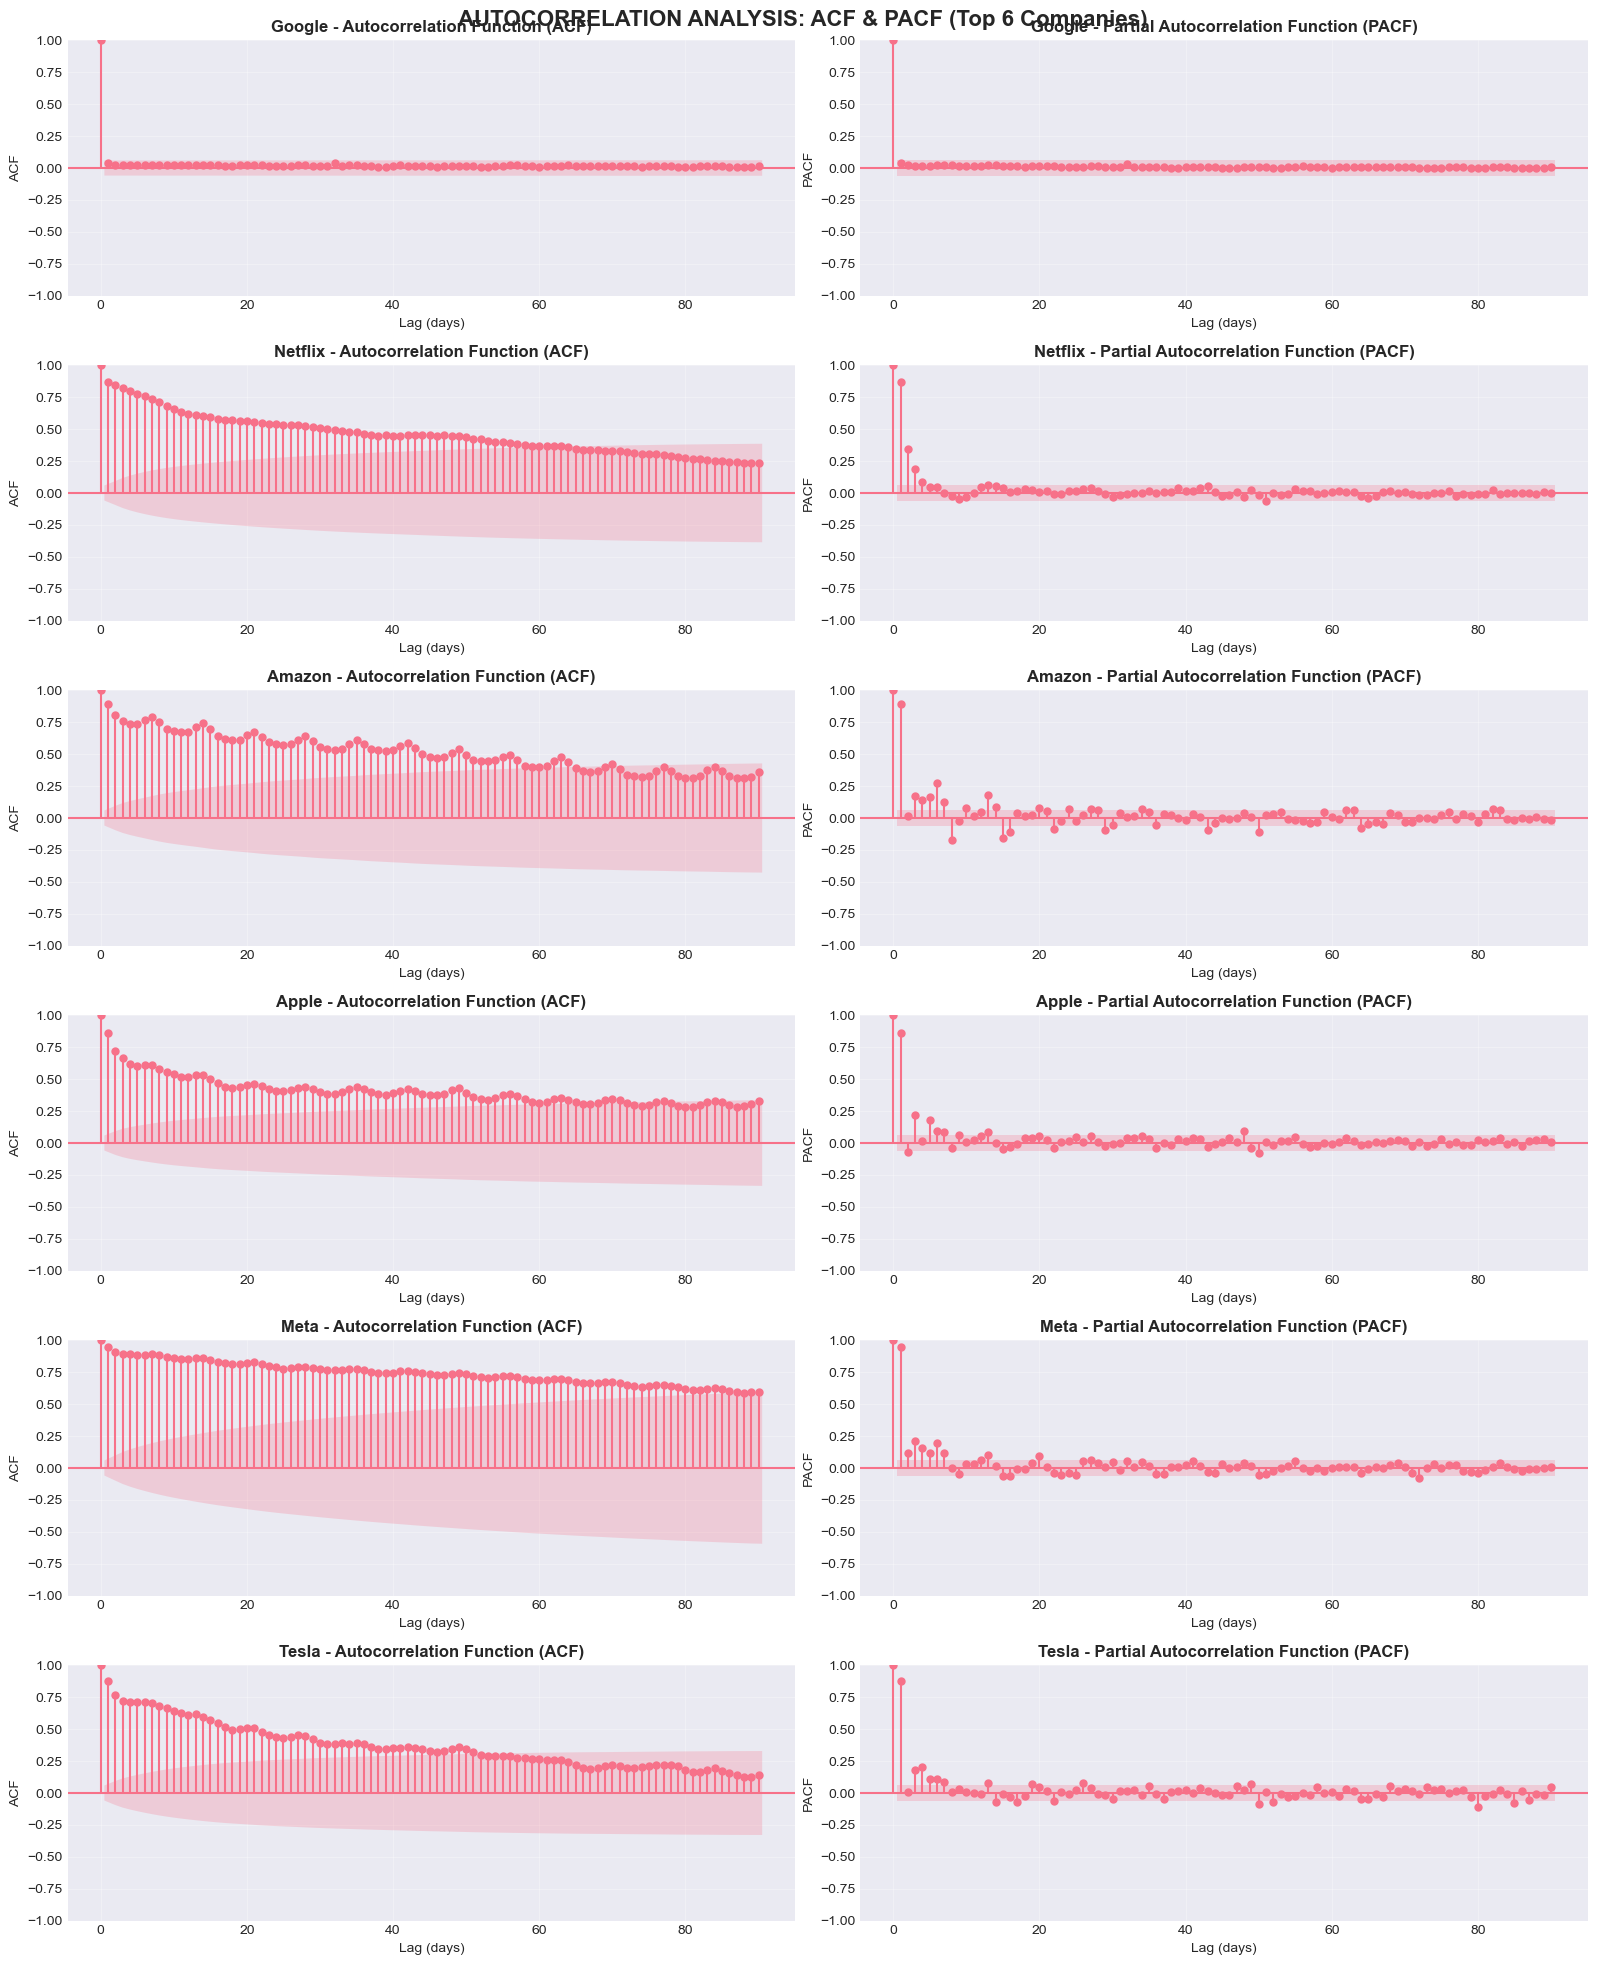


✅ ACF/PACF visualizations complete.


In [43]:
# ============================================================================
# VISUALIZATION: ACF & PACF PLOTS
# ============================================================================

# Select top 6 companies by average views for ACF/PACF analysis
top_6_companies = stats_df.head(6).index.tolist()

fig, axes = plt.subplots(6, 2, figsize=(16, 20))

for idx, company in enumerate(top_6_companies):
    company_data = analysis_df[analysis_df['company'] == company].sort_values('date')
    views_series = company_data['views'].dropna()
    
    # ACF Plot
    ax_acf = axes[idx, 0]
    plot_acf(views_series, lags=90, ax=ax_acf, alpha=0.05)
    ax_acf.set_title(f'{company} - Autocorrelation Function (ACF)', fontweight='bold')
    ax_acf.set_xlabel('Lag (days)')
    ax_acf.set_ylabel('ACF')
    ax_acf.grid(True, alpha=0.3)
    
    # PACF Plot
    ax_pacf = axes[idx, 1]
    plot_pacf(views_series, lags=90, ax=ax_pacf, alpha=0.05, method='ywm')
    ax_pacf.set_title(f'{company} - Partial Autocorrelation Function (PACF)', fontweight='bold')
    ax_pacf.set_xlabel('Lag (days)')
    ax_pacf.set_ylabel('PACF')
    ax_pacf.grid(True, alpha=0.3)

plt.suptitle('AUTOCORRELATION ANALYSIS: ACF & PACF (Top 6 Companies)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ ACF/PACF visualizations complete.")


### 🔗 SECTION 5: CROSS-COMPANY COMPARISON

**Goal:** Analyze correlation patterns, sector effects, and relative stability across companies.


In [45]:
# ============================================================================
# CROSS-COMPANY CORRELATION ANALYSIS
# ============================================================================

print("="*70)
print("CROSS-COMPANY CORRELATION ANALYSIS")
print("="*70)

# Pivot data to wide format (companies as columns)
pageviews_wide = analysis_df.pivot(index='date', columns='company', values='views')

# 1. CORRELATION MATRIX
print(f"\n📊 PAGEVIEW CORRELATION MATRIX")
print(f"{'─'*70}")

correlation_matrix = pageviews_wide.corr()
print(correlation_matrix.round(3).to_string())

# 2. IDENTIFY STRONG CORRELATIONS
print(f"\n🔗 STRONG CORRELATIONS (|r| > 0.7)")
print(f"{'─'*70}")

strong_corrs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            strong_corrs.append({
                'Company_1': correlation_matrix.columns[i],
                'Company_2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if strong_corrs:
    strong_corrs_df = pd.DataFrame(strong_corrs).sort_values('Correlation', ascending=False)
    print(strong_corrs_df.to_string(index=False))
else:
    print("No strong correlations found (all |r| < 0.7)")

# 3. AVERAGE CORRELATION BY COMPANY
print(f"\n📈 AVERAGE CORRELATION WITH OTHER COMPANIES")
print(f"{'─'*70}")

avg_corrs = []
for company in correlation_matrix.columns:
    # Exclude self-correlation
    other_corrs = correlation_matrix[company].drop(company)
    avg_corr = other_corrs.mean()
    avg_corrs.append({'Company': company, 'Avg_Correlation': avg_corr})

avg_corrs_df = pd.DataFrame(avg_corrs).sort_values('Avg_Correlation', ascending=False)
print(avg_corrs_df.to_string(index=False))

# 4. STABILITY RANKING
print(f"\n🏆 COMPANY RANKING BY SIGNAL QUALITY")
print(f"{'─'*70}")
print(f"Combining: Low Volatility + High Persistence + Moderate Correlation")
print()

# Create composite score
ranking_df = pd.DataFrame({
    'Company': volatility_df.index,
    'CV': volatility_df['cv'].values,  # Lower is better
    'ACF_1': [autocorr_df[autocorr_df['Company'] == c]['ACF_1'].values[0] for c in volatility_df.index],  # Higher is better
    'Avg_Corr': [avg_corrs_df[avg_corrs_df['Company'] == c]['Avg_Correlation'].values[0] for c in volatility_df.index]  # Moderate is best
})

# Normalize and create score (simple approach)
# Lower CV is better: score = 1 - (CV / max_CV)
# Higher ACF_1 is better: score = ACF_1
# Moderate Avg_Corr is better: score = 1 - |Avg_Corr - 0.5|

ranking_df['CV_Score'] = 1 - (ranking_df['CV'] / ranking_df['CV'].max())
ranking_df['ACF_Score'] = ranking_df['ACF_1']
ranking_df['Corr_Score'] = 1 - abs(ranking_df['Avg_Corr'] - 0.5)

# Composite score (equal weighting)
ranking_df['Composite_Score'] = (ranking_df['CV_Score'] + ranking_df['ACF_Score'] + ranking_df['Corr_Score']) / 3
ranking_df = ranking_df.sort_values('Composite_Score', ascending=False)

print(f"{'Rank':>4} | {'Company':12} | {'CV%':>6} | {'ACF(1)':>7} | {'AvgCorr':>8} | {'Score':>6}")
print(f"{'-'*65}")

for rank, (_, row) in enumerate(ranking_df.iterrows(), 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{medal} {rank:>2} | {row['Company']:12} | {row['CV']:>6.1f} | {row['ACF_1']:>7.3f} | {row['Avg_Corr']:>8.3f} | {row['Composite_Score']:>6.3f}")

print(f"\n💡 INTERPRETATION:")
print(f"  - Top-ranked companies have best signal quality for prediction")
print(f"  - We will use top 3 companies as primary features")
print(f"  - Bottom-ranked companies may add noise rather than signal")

print(f"\n{'='*70}")
print("✅ CROSS-COMPANY ANALYSIS COMPLETE")
print(f"{'='*70}")


CROSS-COMPANY CORRELATION ANALYSIS

📊 PAGEVIEW CORRELATION MATRIX
──────────────────────────────────────────────────────────────────────
company  Amazon  Apple  Google   Meta  Netflix   Nike  Target  Tesla  Walmart
company                                                                      
Amazon    1.000  0.482   0.063  0.560    0.474  0.294   0.097  0.405    0.609
Apple     0.482  1.000   0.047  0.476    0.264  0.322   0.137  0.316    0.547
Google    0.063  0.047   1.000  0.123    0.104  0.076   0.009 -0.006    0.023
Meta      0.560  0.476   0.123  1.000    0.593  0.476   0.037  0.236    0.366
Netflix   0.474  0.264   0.104  0.593    1.000  0.317   0.033  0.312    0.202
Nike      0.294  0.322   0.076  0.476    0.317  1.000   0.104  0.164    0.254
Target    0.097  0.137   0.009  0.037    0.033  0.104   1.000  0.294    0.071
Tesla     0.405  0.316  -0.006  0.236    0.312  0.164   0.294  1.000    0.321
Walmart   0.609  0.547   0.023  0.366    0.202  0.254   0.071  0.321    1.000

🔗 ST

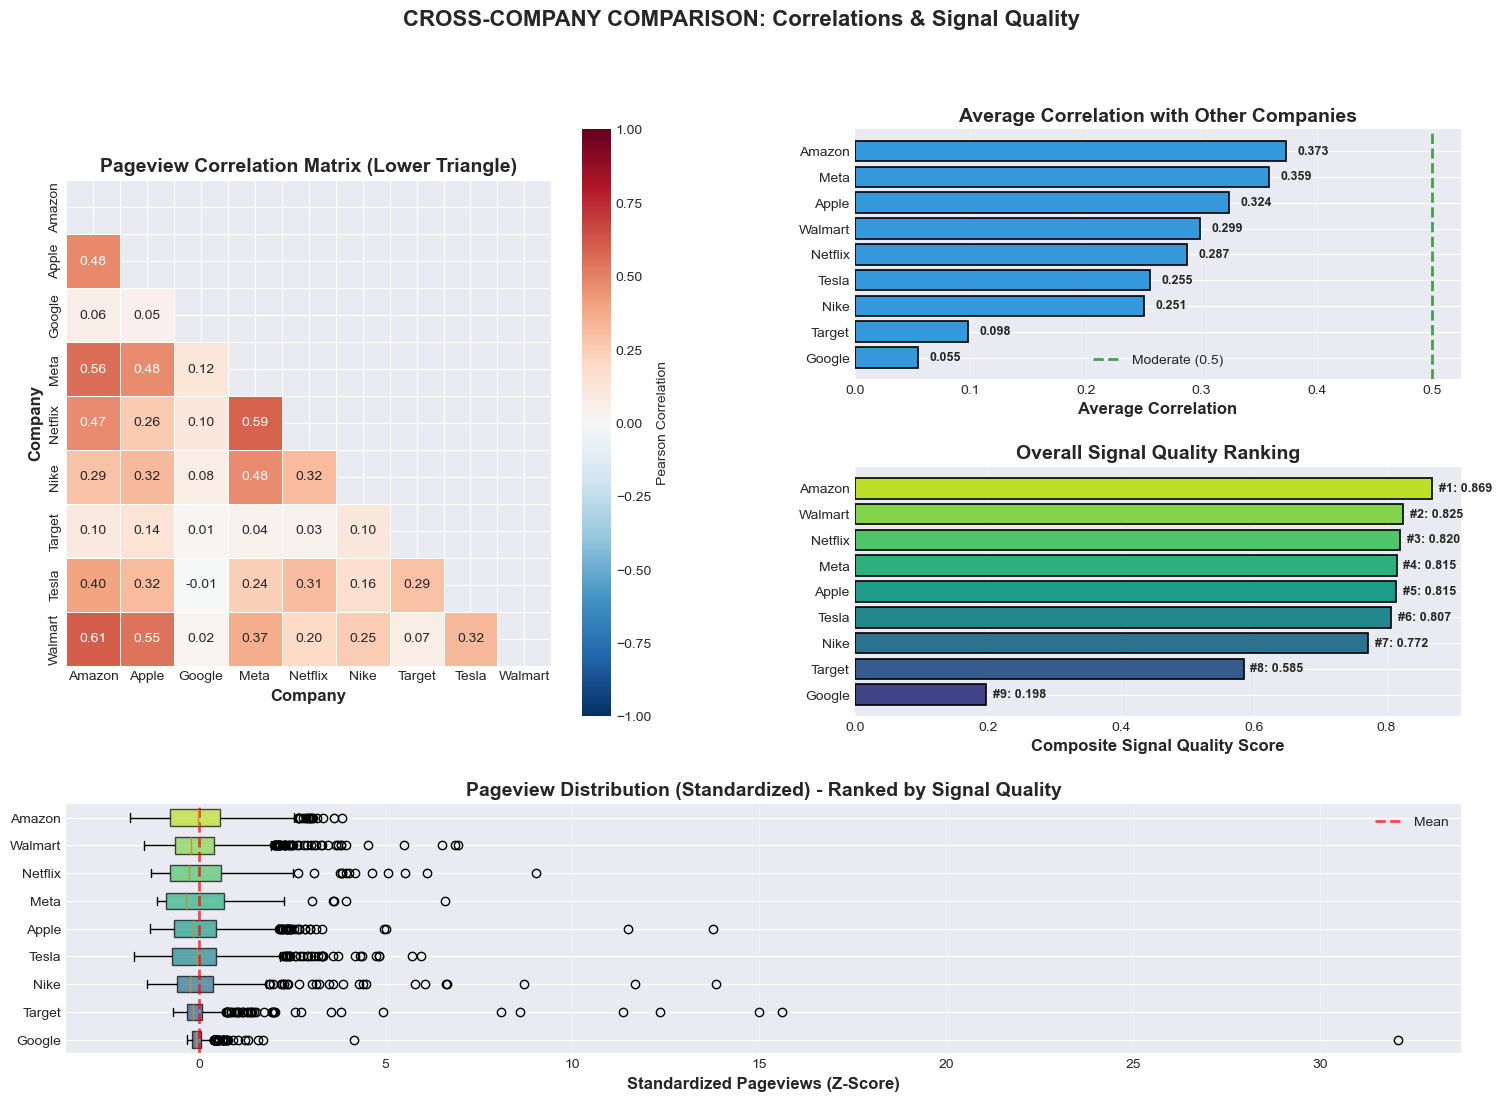


✅ Cross-company comparison visualizations complete.


In [46]:
# ============================================================================
# VISUALIZATION: CROSS-COMPANY COMPARISON
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. CORRELATION HEATMAP
ax1 = fig.add_subplot(gs[0:2, 0])
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True, ax=ax1, 
            cbar_kws={'label': 'Pearson Correlation'}, linewidths=0.5)
ax1.set_title('Pageview Correlation Matrix (Lower Triangle)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Company', fontsize=12, fontweight='bold')
ax1.set_ylabel('Company', fontsize=12, fontweight='bold')

# 2. AVERAGE CORRELATION RANKING
ax2 = fig.add_subplot(gs[0, 1])
avg_corrs_sorted = avg_corrs_df.sort_values('Avg_Correlation', ascending=True)
colors_corr = ['#2ecc71' if c > 0.4 and c < 0.6 else '#f39c12' if c >= 0.6 else '#3498db' 
               for c in avg_corrs_sorted['Avg_Correlation']]

bars = ax2.barh(avg_corrs_sorted['Company'], avg_corrs_sorted['Avg_Correlation'], 
                color=colors_corr, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Average Correlation', fontsize=12, fontweight='bold')
ax2.set_title('Average Correlation with Other Companies', fontsize=14, fontweight='bold')
ax2.axvline(x=0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Moderate (0.5)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars, avg_corrs_sorted['Avg_Correlation']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9, fontweight='bold')

# 3. SIGNAL QUALITY RANKING
ax3 = fig.add_subplot(gs[1, 1])
ranking_sorted = ranking_df.sort_values('Composite_Score', ascending=True)
colors_rank = plt.cm.viridis(np.linspace(0.2, 0.9, len(ranking_sorted)))

bars_rank = ax3.barh(ranking_sorted['Company'], ranking_sorted['Composite_Score'], 
                     color=colors_rank, edgecolor='black', linewidth=1.2)
ax3.set_xlabel('Composite Signal Quality Score', fontsize=12, fontweight='bold')
ax3.set_title('Overall Signal Quality Ranking', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Add rank labels
for rank, (bar, score) in enumerate(zip(bars_rank, ranking_sorted['Composite_Score']), 1):
    label = f'#{len(ranking_sorted) - rank + 1}: {score:.3f}'
    ax3.text(score + 0.01, bar.get_y() + bar.get_height()/2, label, 
             va='center', fontsize=9, fontweight='bold')

# 4. BOXPLOT COMPARISON (Standardized)
ax4 = fig.add_subplot(gs[2, :])

# Standardize pageviews for fair comparison (z-score)
pageviews_standardized = pageviews_wide.copy()
for col in pageviews_standardized.columns:
    pageviews_standardized[col] = (pageviews_standardized[col] - pageviews_standardized[col].mean()) / pageviews_standardized[col].std()

companies_ranked = ranking_sorted['Company'].tolist()
data_for_box_std = [pageviews_standardized[c].values for c in companies_ranked]

bp = ax4.boxplot(data_for_box_std, labels=companies_ranked, patch_artist=True, vert=False,
                 showfliers=True, widths=0.6)

# Color boxes by rank
for patch, color in zip(bp['boxes'], colors_rank):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_xlabel('Standardized Pageviews (Z-Score)', fontsize=12, fontweight='bold')
ax4.set_title('Pageview Distribution (Standardized) - Ranked by Signal Quality', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('CROSS-COMPANY COMPARISON: Correlations & Signal Quality', fontsize=16, fontweight='bold')
plt.show()

print("\n✅ Cross-company comparison visualizations complete.")


### 📋 SECTION 6: EDA SUMMARY & RECOMMENDATIONS

**Goal:** Synthesize all findings and provide actionable recommendations for modeling.


In [48]:
# ============================================================================
# COMPREHENSIVE EDA SUMMARY & RECOMMENDATIONS
# ============================================================================

print("="*80)
print(" " * 20 + "COMPREHENSIVE EDA SUMMARY")
print("="*80)

print(f"\n🎯 RESEARCH OBJECTIVE")
print(f"{'─'*80}")
print(f"Evaluate Wikipedia pageview data as a predictive feature for stock market returns.")
print(f"Dataset: {len(full_df):,} records, {full_df['company'].nunique()} companies, {total_days} days")
print(f"Date range: {full_df['date'].min().date()} to {full_df['date'].max().date()}")

# KEY FINDINGS
print(f"\n\n📊 KEY FINDINGS")
print(f"{'='*80}")

print(f"\n1️⃣ DATA QUALITY: {'✅ EXCELLENT' if completeness_df['Pct_Present'].min() > 99 else '⚠️ NEEDS ATTENTION'}")
print(f"{'─'*80}")
print(f"  • Data completeness: {completeness_df['Pct_Present'].min():.2f}% - {completeness_df['Pct_Present'].max():.2f}%")
print(f"  • Missing days: {completeness_df['Missing_Days'].sum()} total across all companies")
print(f"  • Magnitude range: {stats_df['Mean'].min():,.0f} - {stats_df['Mean'].max():,.0f} views/day")
print(f"  ✅ Assessment: Data is complete and ready for modeling")

print(f"\n2️⃣ SEASONALITY & TRENDS")
print(f"{'─'*80}")
print(f"  • Weekend effect: {weekend_diff_pct:+.1f}% change vs weekdays")
print(f"  • Weekly cycles: {'SIGNIFICANT' if abs(weekend_diff_pct) > 5 else 'MINIMAL'}")
print(f"  • Long-term trends: Mixed (see YoY growth rates)")
print(f"  • Volatility: CV ranges from {volatility_df['cv'].min():.1f}% to {volatility_df['cv'].max():.1f}%")
print(f"  ✅ Assessment: Clear temporal patterns exist → Feature engineering needed")

print(f"\n3️⃣ ANOMALIES & SPIKES")
print(f"{'─'*80}")
print(f"  • Total spikes detected (±3σ): {len(spikes)}")
print(f"  • Spike rate: {(len(spikes) / len(full_df) * 100):.2f}% of all observations")
print(f"  • Most volatile company: {spike_counts.index[0]} ({spike_counts.iloc[0]} spikes)")
print(f"  • Least volatile company: {spike_counts.index[-1]} ({spike_counts.iloc[-1]} spikes)")
print(f"  ✅ Assessment: Spikes likely correlate with events → Further investigation needed")

print(f"\n4️⃣ SIGNAL CHARACTERISTICS")
print(f"{'─'*80}")
print(f"  • Stationarity: {stationarity_df['Stationary'].sum()}/{len(stationarity_df)} companies stationary")
print(f"  • Persistence (ACF-1): {autocorr_df['ACF_1'].min():.3f} - {autocorr_df['ACF_1'].max():.3f}")
print(f"  • Highly persistent companies: {(autocorr_df['ACF_1'] > 0.9).sum()}")
print(f"  • Mean-reverting companies: {(autocorr_df['ACF_1'] < 0.5).sum()}")
print(f"  ✅ Assessment: Strong persistence → Lagged features will be valuable")

print(f"\n5️⃣ CROSS-COMPANY DYNAMICS")
print(f"{'─'*80}")
print(f"  • Average inter-company correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")
print(f"  • Strong correlations (|r|>0.7): {len(strong_corrs) if strong_corrs else 0} pairs")
print(f"  • Top signal quality: {ranking_df.iloc[0]['Company']} (score: {ranking_df.iloc[0]['Composite_Score']:.3f})")
print(f"  • Weakest signal: {ranking_df.iloc[-1]['Company']} (score: {ranking_df.iloc[-1]['Composite_Score']:.3f})")
print(f"  ✅ Assessment: Moderate correlations → Companies provide complementary signals")

# RECOMMENDATIONS
print(f"\n\n💡 ACTIONABLE RECOMMENDATIONS FOR MODELING")
print(f"{'='*80}")

print(f"\n🔧 FEATURE ENGINEERING STRATEGY")
print(f"{'─'*80}")
print(f"1. TEMPORAL FEATURES:")
print(f"   • Use 7-day, 30-day, and 90-day moving averages (already calculated)")
print(f"   • Add day-of-week dummies to capture weekly cycles")
print(f"   • Create month-of-year features for seasonal effects")
print(f"   • Include YoY growth rates to capture long-term trends")

print(f"\n2. DERIVED FEATURES:")
print(f"   • Momentum: views_pct_change (1-day, 7-day, 30-day)")
print(f"   • Acceleration: second difference of pageviews")
print(f"   • Volatility: rolling standard deviation (7d, 30d)")
print(f"   • Spikes: binary flags for ±2σ and ±3σ events")
print(f"   • Z-scores: standardized pageviews within each company")

print(f"\n3. LAG STRUCTURE:")
print(f"   • Use lags 1, 3, 5, 7, 14, 30 days")
print(f"   • Test lead-lag relationships between WPV and returns")
print(f"   • Consider asymmetric effects (positive vs negative changes)")

print(f"\n4. COMPANY SELECTION:")
top_3_ranked = ranking_df.head(3)['Company'].tolist()
print(f"   • PRIMARY: {', '.join(top_3_ranked)} (top signal quality)")
print(f"   • SECONDARY: Remaining companies as diversification")
print(f"   • EXCLUDE: Consider removing companies with CV > 40% or ACF < 0.3")

print(f"\n📈 MODELING STRATEGY")
print(f"{'─'*80}")
print(f"1. START SIMPLE:")
print(f"   • Linear regression with lagged WPV features")
print(f"   • Ridge/Lasso for feature selection")
print(f"   • Evaluate R², direction accuracy, and economic significance")

print(f"\n2. ADD COMPLEXITY:")
print(f"   • Random Forest / Gradient Boosting for non-linearities")
print(f"   • XGBoost with early stopping")
print(f"   • LSTM/RNN if sequence modeling improves results")

print(f"\n3. VALIDATION:")
print(f"   • Time series cross-validation (expanding window)")
print(f"   • Hold out last 20% for final out-of-sample test")
print(f"   • Test for regime stability (bull vs bear markets)")

print(f"\n4. ECONOMIC SIGNIFICANCE:")
print(f"   • Backtest trading strategy with realistic costs")
print(f"   • Calculate Sharpe ratio, max drawdown")
print(f"   • Compare to buy-and-hold and other benchmarks")

print(f"\n⚠️ CRITICAL CONSIDERATIONS")
print(f"{'─'*80}")
print(f"• LOOK-AHEAD BIAS: Ensure all features use only past data")
print(f"• OVERFITTING: With {full_df['company'].nunique()} companies and many lags, feature space is large")
print(f"• REGIME CHANGES: Test model stability across different market conditions")
print(f"• CAUSALITY: WPV → Returns or Returns → WPV? Test with Granger causality")
print(f"• EXTERNAL FACTORS: Consider adding market-wide features (VIX, rates, etc.)")

print(f"\n🎓 NEXT STEPS (PHASE 3: MODELING)")

                    COMPREHENSIVE EDA SUMMARY

🎯 RESEARCH OBJECTIVE
────────────────────────────────────────────────────────────────────────────────
Evaluate Wikipedia pageview data as a predictive feature for stock market returns.
Dataset: 9,873 records, 9 companies, 1097 days
Date range: 2022-12-05 to 2025-12-05


📊 KEY FINDINGS

1️⃣ DATA QUALITY: ✅ EXCELLENT
────────────────────────────────────────────────────────────────────────────────
  • Data completeness: 100.00% - 100.00%
  • Missing days: 0 total across all companies
  • Magnitude range: 2,276 - 25,997 views/day
  ✅ Assessment: Data is complete and ready for modeling

2️⃣ SEASONALITY & TRENDS
────────────────────────────────────────────────────────────────────────────────
  • Weekend effect: -11.8% change vs weekdays
  • Weekly cycles: SIGNIFICANT
  • Long-term trends: Mixed (see YoY growth rates)
  • Volatility: CV ranges from 28.2% to 169.6%
  ✅ Assessment: Clear temporal patterns exist → Feature engineering needed

3️⃣ ANO

In [49]:
# ============================================================================
# EXPORT ENRICHED DATASET FOR MODELING
# ============================================================================

print("="*70)
print("EXPORTING ENRICHED DATASET FOR MODELING PHASE")
print("="*70)

# Save the enriched analysis DataFrame with all calculated features
output_path = DATA_DIR / "wikipedia_pageviews_ENRICHED.csv"

# Select key columns to export
export_df = spike_analysis_df[[
    'company', 'ticker', 'date', 'views',
    'dayofweek', 'day_name', 'month', 'year', 'quarter', 'is_weekend',
    'views_7d_ma', 'views_30d_ma', 'views_90d_ma',
    'z_score', 'is_spike'
]].copy()

# Add additional derived features for modeling
for company in export_df['company'].unique():
    mask = export_df['company'] == company
    
    # Momentum features
    export_df.loc[mask, 'views_pct_change_1d'] = export_df.loc[mask, 'views'].pct_change(1)
    export_df.loc[mask, 'views_pct_change_7d'] = export_df.loc[mask, 'views'].pct_change(7)
    export_df.loc[mask, 'views_pct_change_30d'] = export_df.loc[mask, 'views'].pct_change(30)
    
    # Acceleration
    export_df.loc[mask, 'views_acceleration'] = export_df.loc[mask, 'views'].diff().diff()
    
    # Volatility
    export_df.loc[mask, 'views_volatility_7d'] = export_df.loc[mask, 'views'].rolling(7).std()
    export_df.loc[mask, 'views_volatility_30d'] = export_df.loc[mask, 'views'].rolling(30).std()
    
    # Lagged features (for predictive modeling)
    for lag in [1, 3, 5, 7, 14, 30]:
        export_df.loc[mask, f'views_lag_{lag}d'] = export_df.loc[mask, 'views'].shift(lag)
        export_df.loc[mask, f'views_pct_change_lag_{lag}d'] = export_df.loc[mask, 'views_pct_change_1d'].shift(lag)

# Save to CSV
export_df.to_csv(output_path, index=False)

print(f"\n✅ Enriched dataset exported:")
print(f"   Path: {output_path}")
print(f"   Shape: {export_df.shape}")
print(f"   Features: {export_df.shape[1]} columns")
print(f"   Records: {len(export_df):,} rows")

# Display sample
print(f"\n📊 Sample of enriched data (first 5 rows):")
display(export_df.head())

# Feature summary
print(f"\n📋 FEATURE INVENTORY:")
print(f"{'─'*70}")
feature_categories = {
    'Identifiers': ['company', 'ticker', 'date'],
    'Raw Data': ['views'],
    'Temporal': ['dayofweek', 'day_name', 'month', 'year', 'quarter', 'is_weekend'],
    'Smoothed': ['views_7d_ma', 'views_30d_ma', 'views_90d_ma'],
    'Anomaly': ['z_score', 'is_spike'],
    'Momentum': ['views_pct_change_1d', 'views_pct_change_7d', 'views_pct_change_30d'],
    'Derived': ['views_acceleration', 'views_volatility_7d', 'views_volatility_30d'],
    'Lags': [f'views_lag_{lag}d' for lag in [1, 3, 5, 7, 14, 30]] + 
            [f'views_pct_change_lag_{lag}d' for lag in [1, 3, 5, 7, 14, 30]]
}

for category, features in feature_categories.items():
    available = [f for f in features if f in export_df.columns]
    print(f"{category:15} ({len(available):>2}): {', '.join(available[:5])}" + 
          (f"... (+{len(available)-5} more)" if len(available) > 5 else ""))

print(f"\n{'='*70}")
print(f"✅ Dataset ready for predictive modeling!")
print(f"{'='*70}")


EXPORTING ENRICHED DATASET FOR MODELING PHASE

✅ Enriched dataset exported:
   Path: data/wikipedia_pageviews/wikipedia_pageviews_ENRICHED.csv
   Shape: (9873, 33)
   Features: 33 columns
   Records: 9,873 rows

📊 Sample of enriched data (first 5 rows):


company ticker       date  views  dayofweek   day_name  month  year  \
0  Amazon   AMZN 2022-12-05  20074          0     Monday     12  2022   
1  Amazon   AMZN 2022-12-06  20678          1    Tuesday     12  2022   
2  Amazon   AMZN 2022-12-07  20607          2  Wednesday     12  2022   
3  Amazon   AMZN 2022-12-08  20505          3   Thursday     12  2022   
4  Amazon   AMZN 2022-12-09  18845          4     Friday     12  2022   

   quarter  is_weekend  ...  views_lag_3d  views_pct_change_lag_3d  \
0        4           0  ...           NaN                      NaN   
1        4           0  ...           NaN                      NaN   
2        4           0  ...           NaN                      NaN   
3        4           0  ...       20074.0                      NaN   
4        4           0  ...       20678.0                 0.030089   

   views_lag_5d  views_pct_change_lag_5d  views_lag_7d  \
0           NaN                      NaN           NaN   
1           NaN                      NaN           NaN   
2           NaN                      NaN           NaN   
3           NaN                      NaN           NaN   
4           NaN                      NaN           NaN   

   views_pct_change_lag_7d  views_lag_14d  views_pct_change_lag_14d  \
0                      NaN            NaN                       NaN   
1                      NaN            NaN                       NaN   
2                      NaN            NaN                       NaN   
3                      NaN            NaN                       NaN   
4                      NaN            NaN                       NaN   

   views_lag_30d  views_pct_change_lag_30d  
0            NaN                       NaN  
1            NaN                       NaN  
2            NaN                       NaN  
3            NaN                       NaN  
4            NaN                       NaN  

[5 rows x 33 columns]


📋 FEATURE INVENTORY:
──────────────────────────────────────────────────────────────────────
Identifiers     ( 3): company, ticker, date
Raw Data        ( 1): views
Temporal        ( 6): dayofweek, day_name, month, year, quarter... (+1 more)
Smoothed        ( 3): views_7d_ma, views_30d_ma, views_90d_ma
Anomaly         ( 2): z_score, is_spike
Momentum        ( 3): views_pct_change_1d, views_pct_change_7d, views_pct_change_30d
Derived         ( 3): views_acceleration, views_volatility_7d, views_volatility_30d
Lags            (12): views_lag_1d, views_lag_3d, views_lag_5d, views_lag_7d, views_lag_14d... (+7 more)

✅ Dataset ready for predictive modeling!


---
---

# PART 2: MODEL-READY DATASET CONSTRUCTION

## Building a Dataset for Stock Return Prediction

Based on EDA results, we now focus on **3 selected companies**:
- **Amazon** (AMZN)
- **Walmart** (WMT)  
- **Netflix** (NFLX)

This section will:
1. Filter WPV data to selected companies
2. Fetch stock price data using `yfinance`
3. Compute forward returns (1-day and 5-day)
4. Engineer WPV-based predictive features
5. Align data in a **point-in-time safe** manner
6. Produce a single model-ready dataset

---
## 📦 Section 7: Setup & Configuration

In [52]:
# ============================================================================
# MODEL-READY DATASET: CONFIGURATION
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

# Selected companies based on EDA results
SELECTED_COMPANIES = {
    'Amazon': 'AMZN',
    'Walmart': 'WMT',
    'Netflix': 'NFLX'
}

# Feature engineering parameters
FEATURE_CONFIG = {
    'lag_days': [1, 2, 3, 5, 7, 14, 21, 30],           # Days to lag WPV
    'rolling_windows': [7, 14, 30],                    # Rolling mean windows
    'momentum_windows': [7, 14, 30],                   # Momentum calculation windows
    'forward_return_days': [1, 5],                     # Prediction horizons
}

print('=' * 70)
print('MODEL-READY DATASET CONSTRUCTION')
print('=' * 70)
print(f'\n📊 SELECTED COMPANIES:')
for name, ticker in SELECTED_COMPANIES.items():
    print(f'   • {name} ({ticker})')

print(f'\n⚙️ FEATURE CONFIGURATION:')
print(f'   • Lag days: {FEATURE_CONFIG["lag_days"]}')
print(f'   • Rolling windows: {FEATURE_CONFIG["rolling_windows"]}')
print(f'   • Momentum windows: {FEATURE_CONFIG["momentum_windows"]}')
print(f'   • Forward return horizons: {FEATURE_CONFIG["forward_return_days"]} days')

print('\n✅ Configuration loaded.')

MODEL-READY DATASET CONSTRUCTION

📊 SELECTED COMPANIES:
   • Amazon (AMZN)
   • Walmart (WMT)
   • Netflix (NFLX)

⚙️ FEATURE CONFIGURATION:
   • Lag days: [1, 2, 3, 5, 7, 14, 21, 30]
   • Rolling windows: [7, 14, 30]
   • Momentum windows: [7, 14, 30]
   • Forward return horizons: [1, 5] days

✅ Configuration loaded.


---
## 📥 Section 8: Load & Filter WPV Data

In [54]:
# ============================================================================
# STEP 1: LOAD AND FILTER WPV DATA TO SELECTED COMPANIES
# ============================================================================

print('=' * 70)
print('STEP 1: FILTERING WPV DATA')
print('=' * 70)

# Use the existing full_df from previous analysis
# Filter to only selected companies
selected_tickers = list(SELECTED_COMPANIES.values())
selected_names = list(SELECTED_COMPANIES.keys())

wpv_filtered = full_df[full_df['company'].isin(selected_names)].copy()

# Ensure date is datetime
wpv_filtered['date'] = pd.to_datetime(wpv_filtered['date'])

# Sort by company and date
wpv_filtered = wpv_filtered.sort_values(['company', 'date']).reset_index(drop=True)

print(f'\n📊 FILTERED WPV DATA SUMMARY:')
print(f'{'─' * 50}')
print(f'Total records: {len(wpv_filtered):,}')
print(f'Companies: {wpv_filtered["company"].nunique()}')
print(f'Date range: {wpv_filtered["date"].min().date()} to {wpv_filtered["date"].max().date()}')

print(f'\n📈 RECORDS PER COMPANY:')
for company in selected_names:
    count = len(wpv_filtered[wpv_filtered['company'] == company])
    print(f'   • {company}: {count:,} days')

# Display sample
print(f'\n📋 SAMPLE DATA:')
display(wpv_filtered.head(10))

print('\n✅ WPV data filtered successfully.')

STEP 1: FILTERING WPV DATA

📊 FILTERED WPV DATA SUMMARY:
──────────────────────────────────────────────────
Total records: 3,291
Companies: 3
Date range: 2022-12-05 to 2025-12-05

📈 RECORDS PER COMPANY:
   • Amazon: 1,097 days
   • Walmart: 1,097 days
   • Netflix: 1,097 days

📋 SAMPLE DATA:


company ticker        wiki_title       date  views
0  Amazon   AMZN  Amazon_(company) 2022-12-05  20074
1  Amazon   AMZN  Amazon_(company) 2022-12-06  20678
2  Amazon   AMZN  Amazon_(company) 2022-12-07  20607
3  Amazon   AMZN  Amazon_(company) 2022-12-08  20505
4  Amazon   AMZN  Amazon_(company) 2022-12-09  18845
5  Amazon   AMZN  Amazon_(company) 2022-12-10  18335
6  Amazon   AMZN  Amazon_(company) 2022-12-11  18640
7  Amazon   AMZN  Amazon_(company) 2022-12-12  21817
8  Amazon   AMZN  Amazon_(company) 2022-12-13  19787
9  Amazon   AMZN  Amazon_(company) 2022-12-14  16890


✅ WPV data filtered successfully.


---
## 📈 Section 9: Fetch Stock Price Data

In [56]:
# ============================================================================
# STEP 2: FETCH STOCK PRICE DATA USING YFINANCE
# ============================================================================

import yfinance as yf

print('=' * 70)
print('STEP 2: FETCHING STOCK PRICE DATA')
print('=' * 70)

# Get date range from WPV data (with buffer for forward returns)
start_date = wpv_filtered['date'].min() - pd.Timedelta(days=7)  # Buffer for alignment
end_date = wpv_filtered['date'].max() + pd.Timedelta(days=10)   # Buffer for forward returns

print(f'\n📅 Fetching data from {start_date.date()} to {end_date.date()}')


def fetch_stock_data_robust(ticker, company_name, start, end):
    """
    Robustly fetch stock data from yfinance, handling various column formats.
    
    yfinance can return columns in different formats:
    - Single ticker: 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
    - Multi-ticker or newer versions: MultiIndex or different naming
    - Some versions may not have 'Adj Close'
    
    This function handles all these cases.
    """
    try:
        # Download data
        raw = yf.download(
            ticker, 
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            progress=False,
            auto_adjust=False  # Keep both Close and Adj Close if available
        )
        
        if raw is None or len(raw) == 0:
            return None, 'No data returned'
        
        # Reset index to get date as column
        stock = raw.reset_index()
        
        # Handle MultiIndex columns (happens with some yfinance versions)
        if isinstance(stock.columns, pd.MultiIndex):
            # Flatten: take first level, or join if both are meaningful
            new_cols = []
            for col in stock.columns:
                if col[1] == '' or col[1] == ticker:
                    new_cols.append(col[0])
                else:
                    new_cols.append(col[0])
            stock.columns = new_cols
        
        # Convert column names to lowercase for consistent handling
        stock.columns = [str(c).lower().replace(' ', '_') for c in stock.columns]
        
        # Map various possible column names to standard names
        column_mappings = {
            'date': ['date', 'datetime', 'index'],
            'open': ['open', 'open_price'],
            'high': ['high', 'high_price'],
            'low': ['low', 'low_price'],
            'close': ['close', 'close_price'],
            'adj_close': ['adj_close', 'adj close', 'adjusted_close', 'adjclose'],
            'volume': ['volume', 'vol']
        }
        
        # Find and rename columns
        rename_dict = {}
        for target, possible_names in column_mappings.items():
            for name in possible_names:
                if name in stock.columns:
                    rename_dict[name] = target
                    break
        
        stock = stock.rename(columns=rename_dict)
        
        # If adj_close doesn't exist, use close as fallback
        if 'adj_close' not in stock.columns:
            if 'close' in stock.columns:
                stock['adj_close'] = stock['close']
                print(f'      ⚠️ Using Close as Adj Close (not available)')
            else:
                return None, 'No close price found'
        
        # Ensure required columns exist
        required_cols = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
        missing_cols = [c for c in required_cols if c not in stock.columns]
        
        if missing_cols:
            # Try to fill missing with NaN rather than failing
            for col in missing_cols:
                if col != 'date':  # date is critical
                    stock[col] = np.nan
                    print(f'      ⚠️ Column {col} not found, filled with NaN')
                else:
                    return None, f'Missing critical column: {col}'
        
        # Add company info
        stock['ticker'] = ticker
        stock['company'] = company_name
        
        # Select and order columns
        final_cols = ['date', 'ticker', 'company', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
        stock = stock[final_cols]
        
        # Ensure date is datetime
        stock['date'] = pd.to_datetime(stock['date'])
        
        # Remove any rows with NaN in critical columns
        stock = stock.dropna(subset=['date', 'close'])
        
        return stock, None
        
    except Exception as e:
        return None, str(e)


# Fetch stock data for all selected tickers
stock_data_list = []
fetch_errors = []

for company_name, ticker in SELECTED_COMPANIES.items():
    print(f'\n   Fetching {ticker} ({company_name})...')
    
    stock, error = fetch_stock_data_robust(ticker, company_name, start_date, end_date)
    
    if stock is not None and len(stock) > 0:
        stock_data_list.append(stock)
        print(f'      ✅ Retrieved {len(stock):,} trading days')
    else:
        error_msg = error or 'Unknown error'
        fetch_errors.append((ticker, error_msg))
        print(f'      ❌ Error: {error_msg}')

# Check if we have any data
if len(stock_data_list) == 0:
    print('\n' + '!' * 70)
    print('ERROR: No stock data could be fetched!')
    print('!' * 70)
    print('\nPossible causes:')
    print('   1. Network connectivity issues')
    print('   2. yfinance API changes or rate limiting')
    print('   3. Invalid date range')
    print('\nErrors encountered:')
    for ticker, err in fetch_errors:
        print(f'   • {ticker}: {err}')
    print('\n⚠️ Please check your internet connection and try again.')
    raise RuntimeError('Failed to fetch any stock data. Cannot proceed.')

# Combine all stock data
stock_df = pd.concat(stock_data_list, ignore_index=True)
stock_df['date'] = pd.to_datetime(stock_df['date'])

print(f'\n📊 STOCK DATA SUMMARY:')
print(f'{'─' * 50}')
print(f'Total records: {len(stock_df):,}')
print(f'Tickers fetched: {stock_df["ticker"].nunique()} / {len(SELECTED_COMPANIES)}')
print(f'Date range: {stock_df["date"].min().date()} to {stock_df["date"].max().date()}')

if fetch_errors:
    print(f'\n⚠️ WARNINGS: {len(fetch_errors)} ticker(s) had issues:')
    for ticker, err in fetch_errors:
        print(f'   • {ticker}: {err}')

# Display sample
print(f'\n📋 SAMPLE STOCK DATA:')
display(stock_df.head(10))

# Verify adj_close is present and valid
print(f'\n📋 COLUMN VERIFICATION:')
for col in ['open', 'high', 'low', 'close', 'adj_close', 'volume']:
    non_null = stock_df[col].notna().sum()
    pct = non_null / len(stock_df) * 100
    status = '✅' if pct > 99 else '⚠️' if pct > 90 else '❌'
    print(f'   {status} {col}: {non_null:,} values ({pct:.1f}% complete)')

print('\n✅ Stock price data fetched successfully.')

STEP 2: FETCHING STOCK PRICE DATA

📅 Fetching data from 2022-11-28 to 2025-12-15

   Fetching AMZN (Amazon)...
      ✅ Retrieved 759 trading days

   Fetching WMT (Walmart)...
      ✅ Retrieved 759 trading days

   Fetching NFLX (Netflix)...
      ✅ Retrieved 759 trading days

📊 STOCK DATA SUMMARY:
──────────────────────────────────────────────────
Total records: 2,277
Tickers fetched: 3 / 3
Date range: 2022-11-28 to 2025-12-05

📋 SAMPLE STOCK DATA:


date ticker company       open       high        low      close  \
0 2022-11-28   AMZN  Amazon  93.930000  96.400002  93.430000  93.949997   
1 2022-11-29   AMZN  Amazon  94.040001  94.410004  91.440002  92.419998   
2 2022-11-30   AMZN  Amazon  92.470001  96.540001  91.529999  96.540001   
3 2022-12-01   AMZN  Amazon  96.989998  97.230003  94.919998  95.500000   
4 2022-12-02   AMZN  Amazon  94.480003  95.360001  93.779999  94.129997   
5 2022-12-05   AMZN  Amazon  93.050003  94.059998  90.820000  91.010002   
6 2022-12-06   AMZN  Amazon  90.500000  91.040001  87.900002  88.250000   
7 2022-12-07   AMZN  Amazon  88.339996  89.889999  87.480003  88.459999   
8 2022-12-08   AMZN  Amazon  89.239998  90.860001  87.879997  90.349998   
9 2022-12-09   AMZN  Amazon  88.900002  90.300003  88.629997  89.089996   

   adj_close     volume  
0  93.949997   74943100  
1  92.419998   65567300  
2  96.540001  102805800  
3  95.500000   68488000  
4  94.129997   72496400  
5  91.010002   71535500  
6  88.250000   75503600  
7  88.459999   68086900  
8  90.349998   73305900  
9  89.089996   67398500


📋 COLUMN VERIFICATION:
   ✅ open: 2,277 values (100.0% complete)
   ✅ high: 2,277 values (100.0% complete)
   ✅ low: 2,277 values (100.0% complete)
   ✅ close: 2,277 values (100.0% complete)
   ✅ adj_close: 2,277 values (100.0% complete)
   ✅ volume: 2,277 values (100.0% complete)

✅ Stock price data fetched successfully.


---
## 💹 Section 10: Compute Returns

In [58]:
# ============================================================================
# STEP 3: COMPUTE DAILY AND FORWARD RETURNS
# ============================================================================

print('=' * 70)
print('STEP 3: COMPUTING RETURNS')
print('=' * 70)

def compute_returns(df, price_col='adj_close', forward_days=[1, 5]):
    """
    Compute daily returns and forward returns for a stock DataFrame.
    
    Forward returns are computed as:
        forward_return_Nd = (price[t+N] - price[t]) / price[t]
    
    This represents the return you would earn if you bought at close on day t
    and sold at close on day t+N.
    """
    df = df.copy().sort_values('date')
    
    # Daily return (close-to-close)
    df['daily_return'] = df[price_col].pct_change()
    
    # Forward returns (shift price backward to align with decision date)
    for n in forward_days:
        # Forward price n days ahead
        future_price = df[price_col].shift(-n)
        # Forward return
        df[f'forward_return_{n}d'] = (future_price - df[price_col]) / df[price_col]
        # Binary direction label (1 = up, 0 = down)
        df[f'forward_direction_{n}d'] = (df[f'forward_return_{n}d'] > 0).astype(int)
    
    return df

# Apply return computation per ticker
stock_with_returns = stock_df.groupby('ticker', group_keys=False).apply(
    lambda x: compute_returns(x, forward_days=FEATURE_CONFIG['forward_return_days'])
).reset_index(drop=True)

print(f'\n📊 RETURNS COMPUTED:')
print(f'{'─' * 50}')

# Summary statistics
return_cols = ['daily_return'] + [f'forward_return_{n}d' for n in FEATURE_CONFIG['forward_return_days']]

for ticker in selected_tickers:
    ticker_data = stock_with_returns[stock_with_returns['ticker'] == ticker]
    print(f'\n{ticker}:')
    for col in return_cols:
        mean_ret = ticker_data[col].mean() * 100
        std_ret = ticker_data[col].std() * 100
        print(f'   • {col:20}: mean={mean_ret:+.3f}%, std={std_ret:.3f}%')

# Direction balance
print(f'\n📈 FORWARD DIRECTION BALANCE (5-day):')
for ticker in selected_tickers:
    ticker_data = stock_with_returns[stock_with_returns['ticker'] == ticker]
    up_pct = ticker_data['forward_direction_5d'].mean() * 100
    print(f'   • {ticker}: {up_pct:.1f}% up days, {100-up_pct:.1f}% down days')

# Display sample
print(f'\n📋 SAMPLE DATA WITH RETURNS:')
display(stock_with_returns[['date', 'ticker', 'adj_close', 'daily_return', 
                            'forward_return_1d', 'forward_return_5d', 
                            'forward_direction_5d']].head(15))

print('\n✅ Returns computed successfully.')

STEP 3: COMPUTING RETURNS

📊 RETURNS COMPUTED:
──────────────────────────────────────────────────

AMZN:
   • daily_return        : mean=+0.139%, std=2.037%
   • forward_return_1d   : mean=+0.139%, std=2.037%
   • forward_return_5d   : mean=+0.684%, std=4.176%

WMT:
   • daily_return        : mean=+0.120%, std=1.251%
   • forward_return_1d   : mean=+0.120%, std=1.251%
   • forward_return_5d   : mean=+0.596%, std=2.781%

NFLX:
   • daily_return        : mean=+0.192%, std=2.189%
   • forward_return_1d   : mean=+0.192%, std=2.189%
   • forward_return_5d   : mean=+0.948%, std=4.835%

📈 FORWARD DIRECTION BALANCE (5-day):
   • AMZN: 57.8% up days, 42.2% down days
   • WMT: 58.8% up days, 41.2% down days
   • NFLX: 56.4% up days, 43.6% down days

📋 SAMPLE DATA WITH RETURNS:


date ticker  adj_close  daily_return  forward_return_1d  \
0  2022-11-28   AMZN  93.949997           NaN          -0.016285   
1  2022-11-29   AMZN  92.419998     -0.016285           0.044579   
2  2022-11-30   AMZN  96.540001      0.044579          -0.010773   
3  2022-12-01   AMZN  95.500000     -0.010773          -0.014346   
4  2022-12-02   AMZN  94.129997     -0.014346          -0.033146   
5  2022-12-05   AMZN  91.010002     -0.033146          -0.030326   
6  2022-12-06   AMZN  88.250000     -0.030326           0.002380   
7  2022-12-07   AMZN  88.459999      0.002380           0.021366   
8  2022-12-08   AMZN  90.349998      0.021366          -0.013946   
9  2022-12-09   AMZN  89.089996     -0.013946           0.016388   
10 2022-12-12   AMZN  90.550003      0.016388           0.021425   
11 2022-12-13   AMZN  92.489998      0.021425          -0.009839   
12 2022-12-14   AMZN  91.580002     -0.009839          -0.034178   
13 2022-12-15   AMZN  88.449997     -0.034178          -0.006670   
14 2022-12-16   AMZN  87.860001     -0.006670          -0.033462   

    forward_return_5d  forward_direction_5d  
0           -0.031293                     0  
1           -0.045120                     0  
2           -0.083696                     0  
3           -0.053927                     0  
4           -0.053543                     0  
5           -0.005054                     0  
6            0.048045                     1  
7            0.035270                     1  
8           -0.021029                     0  
9           -0.013806                     0  
10          -0.062176                     0  
11          -0.078927                     0  
12          -0.052522                     0  
13          -0.052685                     0  
14          -0.029706                     0


✅ Returns computed successfully.


---
## 🔧 Section 11: Wikipedia Page View Features

In [60]:
# ============================================================================
# STEP 4: WPV-BASED FEATURES
# ============================================================================

print('=' * 70)
print('STEP 4: ENGINEERING WPV FEATURES')
print('=' * 70)

def engineer_wpv_features(df, config):
    """
    Engineer predictive features from Wikipedia Pageview data.
    
    Features created:
    1. Lagged WPV values (views on previous days)
    2. Rolling mean WPV (smoothed recent views)
    3. Rolling std WPV (recent volatility)
    4. WPV momentum (current vs past average)
    5. WPV percent change from N days ago
    6. WPV z-score (standardized current value)
    7. Day-of-week effect
    
    All features use ONLY past/present data (no look-ahead bias).
    """
    df = df.copy().sort_values('date')
    views = df['views']
    
    # -------------------------------------------------------------------------
    # 1. LAGGED VALUES
    # -------------------------------------------------------------------------
    for lag in config['lag_days']:
        df[f'wpv_lag_{lag}d'] = views.shift(lag)
    
    # -------------------------------------------------------------------------
    # 2. ROLLING STATISTICS (using past data only)
    # -------------------------------------------------------------------------
    for window in config['rolling_windows']:
        # Rolling mean (past N days, not including today)
        df[f'wpv_rolling_mean_{window}d'] = views.shift(1).rolling(window=window, min_periods=1).mean()
        # Rolling std
        df[f'wpv_rolling_std_{window}d'] = views.shift(1).rolling(window=window, min_periods=1).std()
        # Rolling min/max
        df[f'wpv_rolling_min_{window}d'] = views.shift(1).rolling(window=window, min_periods=1).min()
        df[f'wpv_rolling_max_{window}d'] = views.shift(1).rolling(window=window, min_periods=1).max()
    
    # -------------------------------------------------------------------------
    # 3. MOMENTUM FEATURES
    # -------------------------------------------------------------------------
    for window in config['momentum_windows']:
        # Momentum: ratio of yesterday's views to average of past N days
        past_mean = views.shift(1).rolling(window=window, min_periods=1).mean()
        df[f'wpv_momentum_{window}d'] = views.shift(1) / past_mean
        
        # Percent change from N days ago
        df[f'wpv_pct_change_{window}d'] = views.shift(1).pct_change(periods=window)
    
    # -------------------------------------------------------------------------
    # 4. NORMALIZED / Z-SCORE FEATURES
    # -------------------------------------------------------------------------
    # Z-score relative to 30-day rolling window
    rolling_mean_30 = views.shift(1).rolling(window=30, min_periods=7).mean()
    rolling_std_30 = views.shift(1).rolling(window=30, min_periods=7).std()
    df['wpv_zscore_30d'] = (views.shift(1) - rolling_mean_30) / rolling_std_30
    
    # -------------------------------------------------------------------------
    # 5. TEMPORAL FEATURES
    # -------------------------------------------------------------------------
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_monday'] = (df['day_of_week'] == 0).astype(int)
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)
    
    # -------------------------------------------------------------------------
    # 6. INTERACTION FEATURES
    # -------------------------------------------------------------------------
    # Volatility-adjusted momentum
    df['wpv_momentum_vol_adj'] = df['wpv_momentum_7d'] / (df['wpv_rolling_std_7d'] / df['wpv_rolling_mean_7d'] + 0.001)
    
    # Range position (where is current WPV relative to recent range)
    range_7d = df['wpv_rolling_max_7d'] - df['wpv_rolling_min_7d']
    df['wpv_range_position_7d'] = (views.shift(1) - df['wpv_rolling_min_7d']) / (range_7d + 1)
    
    return df

# Apply feature engineering per company
print('\n🔧 Engineering features for each company...')

wpv_with_features = wpv_filtered.groupby('company', group_keys=False).apply(
    lambda x: engineer_wpv_features(x, FEATURE_CONFIG)
).reset_index(drop=True)

# List all engineered features
base_cols = ['date', 'company', 'ticker', 'wiki_title', 'views']
feature_cols = [c for c in wpv_with_features.columns if c not in base_cols]

print(f'\n📊 FEATURES:')
print(f'{'─' * 50}')
print(f'Total features created: {len(feature_cols)}')

# Categorize features
feature_categories = {
    'Lag features': [c for c in feature_cols if 'lag' in c],
    'Rolling stats': [c for c in feature_cols if 'rolling' in c],
    'Momentum': [c for c in feature_cols if 'momentum' in c or 'pct_change' in c],
    'Normalized': [c for c in feature_cols if 'zscore' in c or 'range_position' in c],
    'Temporal': [c for c in feature_cols if 'day' in c or 'is_' in c],
}

for category, features in feature_categories.items():
    print(f'\n   {category} ({len(features)}):')
    for f in features[:5]:
        print(f'      • {f}')
    if len(features) > 5:
        print(f'      ... and {len(features) - 5} more')

# Display sample
print(f'\n📋 SAMPLE WPV WITH FEATURES:')
sample_cols = ['date', 'company', 'views', 'wpv_lag_1d', 'wpv_rolling_mean_7d', 
               'wpv_momentum_7d', 'wpv_zscore_30d', 'day_of_week']
display(wpv_with_features[sample_cols].head(15))

print('\n✅ WPV features engineered successfully.')

STEP 4: ENGINEERING WPV FEATURES

🔧 Engineering features for each company...

📊 FEATURES:
──────────────────────────────────────────────────
Total features created: 33

   Lag features (8):
      • wpv_lag_1d
      • wpv_lag_2d
      • wpv_lag_3d
      • wpv_lag_5d
      • wpv_lag_7d
      ... and 3 more

   Rolling stats (12):
      • wpv_rolling_mean_7d
      • wpv_rolling_std_7d
      • wpv_rolling_min_7d
      • wpv_rolling_max_7d
      • wpv_rolling_mean_14d
      ... and 7 more

   Momentum (7):
      • wpv_momentum_7d
      • wpv_pct_change_7d
      • wpv_momentum_14d
      • wpv_pct_change_14d
      • wpv_momentum_30d
      ... and 2 more

   Normalized (2):
      • wpv_zscore_30d
      • wpv_range_position_7d

   Temporal (4):
      • day_of_week
      • is_weekend
      • is_monday
      • is_friday

📋 SAMPLE WPV WITH FEATURES:


date company  views  wpv_lag_1d  wpv_rolling_mean_7d  \
0  2022-12-05  Amazon  20074         NaN                  NaN   
1  2022-12-06  Amazon  20678     20074.0         20074.000000   
2  2022-12-07  Amazon  20607     20678.0         20376.000000   
3  2022-12-08  Amazon  20505     20607.0         20453.000000   
4  2022-12-09  Amazon  18845     20505.0         20466.000000   
5  2022-12-10  Amazon  18335     18845.0         20141.800000   
6  2022-12-11  Amazon  18640     18335.0         19840.666667   
7  2022-12-12  Amazon  21817     18640.0         19669.142857   
8  2022-12-13  Amazon  19787     21817.0         19918.142857   
9  2022-12-14  Amazon  16890     19787.0         19790.857143   
10 2022-12-15  Amazon  16379     16890.0         19259.857143   
11 2022-12-16  Amazon  14544     16379.0         18670.428571   
12 2022-12-17  Amazon  15209     14544.0         18056.000000   
13 2022-12-18  Amazon  16909     15209.0         17609.428571   
14 2022-12-19  Amazon  19871     16909.0         17362.142857   

    wpv_momentum_7d  wpv_zscore_30d  day_of_week  
0               NaN             NaN            0  
1          1.000000             NaN            1  
2          1.014821             NaN            2  
3          1.007529             NaN            3  
4          1.001906             NaN            4  
5          0.935616             NaN            5  
6          0.924112             NaN            6  
7          0.947677       -1.006081            0  
8          1.095333        1.548214            1  
9          0.999805       -0.117797            2  
10         0.876954       -1.897344            3  
11         0.877270       -1.755246            4  
12         0.805494       -2.074130            5  
13         0.863685       -1.511238            6  
14         0.973901       -0.720708            0


✅ WPV features engineered successfully.


---
## 🔗 Section 12: Merge & Align Data (Point-in-Time Safe)

In [62]:
# ============================================================================
# STEP 5: MERGE WPV FEATURES WITH STOCK RETURNS (POINT-IN-TIME SAFE)
# ============================================================================

print('=' * 70)
print('STEP 5: MERGING DATA (POINT-IN-TIME SAFE)')
print('=' * 70)

"""
POINT-IN-TIME ALIGNMENT LOGIC:
================================

WPV data for day 't' represents pageviews that occurred during day 't'.
This data is only fully available AFTER market close on day 't'.

Therefore:
- WPV features from day 't' can only be used to predict returns starting from t+1.
- forward_return_1d on day 't' = return from close(t) to close(t+1)
- We want to predict forward_return_1d on day 't' using WPV from day 't'

Merge strategy:
- Join on (company, date)
- WPV features are ALREADY lagged (we used shift(1) in feature engineering)
- Forward returns are computed looking forward from each date
- This is naturally point-in-time safe!
"""

print('\n📋 ALIGNMENT STRATEGY:')
print('   • WPV features for day t use only data from t-1 and earlier')
print('   • Forward returns for day t represent returns from close(t) onward')
print('   • This ensures no look-ahead bias in the feature set')

# Prepare for merge
wpv_for_merge = wpv_with_features.copy()
stock_for_merge = stock_with_returns.copy()

# Ensure date columns are datetime with no timezone
wpv_for_merge['date'] = pd.to_datetime(wpv_for_merge['date']).dt.tz_localize(None)
stock_for_merge['date'] = pd.to_datetime(stock_for_merge['date']).dt.tz_localize(None)

# Merge on company and date
model_df = pd.merge(
    wpv_for_merge,
    stock_for_merge[['date', 'company', 'ticker', 'open', 'high', 'low', 'close', 
                     'adj_close', 'volume', 'daily_return', 
                     'forward_return_1d', 'forward_return_5d',
                     'forward_direction_1d', 'forward_direction_5d']],
    on=['company', 'date'],
    how='inner',
    suffixes=('_wpv', '_stock')
)

# Clean up ticker column (use stock ticker, drop WPV ticker if exists)
if 'ticker_stock' in model_df.columns:
    model_df['ticker'] = model_df['ticker_stock']
    model_df = model_df.drop(columns=['ticker_wpv', 'ticker_stock'], errors='ignore')

print(f'\n📊 MERGED DATA SUMMARY:')
print(f'{'─' * 50}')
print(f'Total records: {len(model_df):,}')
print(f'Companies: {model_df["company"].nunique()}')
print(f'Date range: {model_df["date"].min().date()} to {model_df["date"].max().date()}')

print(f'\n📈 RECORDS PER COMPANY:')
for company in selected_names:
    count = len(model_df[model_df['company'] == company])
    print(f'   • {company}: {count:,} trading days')

# Check for missing values in key columns
print(f'\n⚠️ MISSING VALUE CHECK (key columns):')
key_cols = ['views', 'adj_close', 'forward_return_1d', 'forward_return_5d']
for col in key_cols:
    missing = model_df[col].isna().sum()
    pct = missing / len(model_df) * 100
    status = '✅' if missing == 0 else '⚠️'
    print(f'   {status} {col}: {missing} missing ({pct:.1f}%)')

print('\n✅ Data merged successfully.')

STEP 5: MERGING DATA (POINT-IN-TIME SAFE)

📋 ALIGNMENT STRATEGY:
   • WPV features for day t use only data from t-1 and earlier
   • Forward returns for day t represent returns from close(t) onward
   • This ensures no look-ahead bias in the feature set

📊 MERGED DATA SUMMARY:
──────────────────────────────────────────────────
Total records: 2,262
Companies: 3
Date range: 2022-12-05 to 2025-12-05

📈 RECORDS PER COMPANY:
   • Amazon: 754 trading days
   • Walmart: 754 trading days
   • Netflix: 754 trading days

⚠️ MISSING VALUE CHECK (key columns):
   ✅ views: 0 missing (0.0%)
   ✅ adj_close: 0 missing (0.0%)
   ⚠️ forward_return_1d: 3 missing (0.1%)
   ⚠️ forward_return_5d: 15 missing (0.7%)

✅ Data merged successfully.


---
## 🧹 Section 13: Finalize Model-Ready Dataset

In [64]:
# ============================================================================
# STEP 6: FINALIZE MODEL-READY DATASET
# ============================================================================

print('=' * 70)
print('STEP 6: FINALIZING MODEL-READY DATASET')
print('=' * 70)

# Drop rows with missing target values (at the end of series due to forward returns)
model_ready = model_df.dropna(subset=['forward_return_1d', 'forward_return_5d']).copy()

# Also drop rows where we don't have enough history for features
# (first ~30 rows per company will have NaN features)
model_ready = model_ready.dropna(subset=['wpv_rolling_mean_30d', 'wpv_zscore_30d']).copy()

# Sort by company and date
model_ready = model_ready.sort_values(['company', 'date']).reset_index(drop=True)

# Define column groups for final dataset
id_cols = ['date', 'company', 'ticker']

raw_wpv_cols = ['views']

wpv_feature_cols = [c for c in model_ready.columns if c.startswith('wpv_') or 
                   c in ['day_of_week', 'is_weekend', 'is_monday', 'is_friday']]

price_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'daily_return']

target_cols = ['forward_return_1d', 'forward_return_5d', 
               'forward_direction_1d', 'forward_direction_5d']

# Reorder columns
final_col_order = id_cols + raw_wpv_cols + wpv_feature_cols + price_cols + target_cols
# Only keep columns that exist
final_col_order = [c for c in final_col_order if c in model_ready.columns]
model_ready = model_ready[final_col_order]

print(f'\n📊 FINAL DATASET SUMMARY:')
print(f'{'─' * 50}')
print(f'Total records: {len(model_ready):,}')
print(f'Total columns: {len(model_ready.columns)}')
print(f'Companies: {model_ready["company"].nunique()}')
print(f'Date range: {model_ready["date"].min().date()} to {model_ready["date"].max().date()}')

print(f'\n📁 COLUMN GROUPS:')
print(f'   • ID columns ({len(id_cols)}): {id_cols}')
print(f'   • Raw WPV ({len(raw_wpv_cols)}): {raw_wpv_cols}')
print(f'   • WPV features ({len(wpv_feature_cols)}): (see below)')
print(f'   • Price/Returns ({len(price_cols)}): {price_cols}')
print(f'   • Targets ({len(target_cols)}): {target_cols}')

print(f'\n🔧 WPV FEATURE COLUMNS ({len(wpv_feature_cols)}):')
for i, col in enumerate(wpv_feature_cols):
    print(f'   {i+1:2}. {col}')

print('\n✅ Model-ready dataset finalized.')

STEP 6: FINALIZING MODEL-READY DATASET

📊 FINAL DATASET SUMMARY:
──────────────────────────────────────────────────
Total records: 2,232
Total columns: 48
Companies: 3
Date range: 2022-12-12 to 2025-11-28

📁 COLUMN GROUPS:
   • ID columns (3): ['date', 'company', 'ticker']
   • Raw WPV (1): ['views']
   • WPV features (33): (see below)
   • Price/Returns (7): ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'daily_return']
   • Targets (4): ['forward_return_1d', 'forward_return_5d', 'forward_direction_1d', 'forward_direction_5d']

🔧 WPV FEATURE COLUMNS (33):
    1. wpv_lag_1d
    2. wpv_lag_2d
    3. wpv_lag_3d
    4. wpv_lag_5d
    5. wpv_lag_7d
    6. wpv_lag_14d
    7. wpv_lag_21d
    8. wpv_lag_30d
    9. wpv_rolling_mean_7d
   10. wpv_rolling_std_7d
   11. wpv_rolling_min_7d
   12. wpv_rolling_max_7d
   13. wpv_rolling_mean_14d
   14. wpv_rolling_std_14d
   15. wpv_rolling_min_14d
   16. wpv_rolling_max_14d
   17. wpv_rolling_mean_30d
   18. wpv_rolling_std_30d
   19. wpv_r

In [65]:
# ============================================================================
# DATASET QUALITY REPORT
# ============================================================================

print('=' * 70)
print('MODEL-READY DATASET: QUALITY REPORT')
print('=' * 70)

# 1. Missing values
print(f'\n📋 MISSING VALUE SUMMARY:')
missing_summary = model_ready.isnull().sum()
missing_any = missing_summary[missing_summary > 0]
if len(missing_any) == 0:
    print('   ✅ No missing values in any column!')
else:
    print(f'   ⚠️ Columns with missing values:')
    for col, count in missing_any.items():
        print(f'      • {col}: {count} ({count/len(model_ready)*100:.1f}%)')

# 2. Data types
print(f'\n📋 DATA TYPES:')
dtype_summary = model_ready.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f'   • {dtype}: {count} columns')

# 3. Target distribution
print(f'\n📋 TARGET VARIABLE STATISTICS:')
for col in target_cols[:2]:  # Return columns
    print(f'\n   {col}:')
    print(f'      Mean: {model_ready[col].mean()*100:+.3f}%')
    print(f'      Std:  {model_ready[col].std()*100:.3f}%')
    print(f'      Min:  {model_ready[col].min()*100:+.2f}%')
    print(f'      Max:  {model_ready[col].max()*100:+.2f}%')

# 4. Class balance for direction
print(f'\n📋 CLASS BALANCE (Direction Labels):')
for col in target_cols[2:]:  # Direction columns
    up_pct = model_ready[col].mean() * 100
    print(f'   • {col}: {up_pct:.1f}% up / {100-up_pct:.1f}% down')

# 5. Feature statistics sample
print(f'\n📋 FEATURE STATISTICS (sample):')
sample_features = ['views', 'wpv_lag_1d', 'wpv_rolling_mean_7d', 'wpv_momentum_7d', 'wpv_zscore_30d']
feature_stats = model_ready[sample_features].describe().round(2)
display(feature_stats)

print('\n✅ Quality report complete.')

MODEL-READY DATASET: QUALITY REPORT

📋 MISSING VALUE SUMMARY:
   ⚠️ Columns with missing values:
      • wpv_lag_14d: 15 (0.7%)
      • wpv_lag_21d: 30 (1.3%)
      • wpv_lag_30d: 45 (2.0%)
      • wpv_pct_change_7d: 3 (0.1%)
      • wpv_pct_change_14d: 18 (0.8%)
      • wpv_pct_change_30d: 48 (2.2%)

📋 DATA TYPES:
   • float64: 37 columns
   • int64: 7 columns
   • object: 2 columns
   • datetime64[ns]: 1 columns
   • int32: 1 columns

📋 TARGET VARIABLE STATISTICS:

   forward_return_1d:
      Mean: +0.154%
      Std:  1.861%
      Min:  -10.07%
      Max:  +16.05%

   forward_return_5d:
      Mean: +0.767%
      Std:  4.013%
      Min:  -12.99%
      Max:  +18.79%

📋 CLASS BALANCE (Direction Labels):
   • forward_direction_1d: 53.6% up / 46.4% down
   • forward_direction_5d: 58.5% up / 41.5% down

📋 FEATURE STATISTICS (sample):


views  wpv_lag_1d  wpv_rolling_mean_7d  wpv_momentum_7d  \
count   2232.00     2232.00              2232.00          2232.00   
mean   10324.30    10311.95             10218.48             1.01   
std     4781.82     4886.05              4812.07             0.11   
min     3358.00     3136.00              3504.43             0.49   
25%     6503.00     6420.00              6521.75             0.95   
50%     9652.50     9629.00              9568.57             1.01   
75%    13041.50    13043.00             12694.29             1.06   
max    44059.00    44059.00             38963.86             2.20   

       wpv_zscore_30d  
count         2232.00  
mean             0.04  
std              1.10  
min             -3.37  
25%             -0.72  
50%             -0.06  
75%              0.68  
max              5.04


✅ Quality report complete.


---
## 💾 Section 14: Save Model-Ready Dataset

In [67]:
# ============================================================================
# SAVE MODEL-READY DATASET
# ============================================================================

print('=' * 70)
print('SAVING MODEL-READY DATASET')
print('=' * 70)

# Create output directory
output_dir = Path('data/model_ready')
output_dir.mkdir(parents=True, exist_ok=True)

# Generate filename with date range
date_min = model_ready['date'].min().strftime('%Y%m%d')
date_max = model_ready['date'].max().strftime('%Y%m%d')
filename_base = f'wpv_stock_model_ready_{date_min}_{date_max}'

# Save as CSV
csv_path = output_dir / f'{filename_base}.csv'
model_ready.to_csv(csv_path, index=False)
print(f'\n✅ Saved CSV: {csv_path}')
print(f'   Size: {csv_path.stat().st_size / 1024:.1f} KB')

# Save as Parquet (if available)
if PARQUET_AVAILABLE:
    parquet_path = output_dir / f'{filename_base}.parquet'
    model_ready.to_parquet(parquet_path, index=False)
    print(f'\n✅ Saved Parquet: {parquet_path}')
    print(f'   Size: {parquet_path.stat().st_size / 1024:.1f} KB')
else:
    print('\n⚠️ Parquet not saved (pyarrow not installed)')

# Also save per-company files for easier loading
print(f'\n📁 Per-company files:')
for company in model_ready['company'].unique():
    company_data = model_ready[model_ready['company'] == company]
    company_filename = f'{filename_base}_{company.lower()}.csv'
    company_path = output_dir / company_filename
    company_data.to_csv(company_path, index=False)
    print(f'   ✅ {company}: {company_path}')

print(f'\n{'=' * 70}')
print(f'✅ ALL FILES SAVED SUCCESSFULLY')
print(f'{'=' * 70}')

SAVING MODEL-READY DATASET

✅ Saved CSV: data/model_ready/wpv_stock_model_ready_20221212_20251128.csv
   Size: 1271.3 KB

✅ Saved Parquet: data/model_ready/wpv_stock_model_ready_20221212_20251128.parquet
   Size: 613.6 KB

📁 Per-company files:
   ✅ Amazon: data/model_ready/wpv_stock_model_ready_20221212_20251128_amazon.csv
   ✅ Netflix: data/model_ready/wpv_stock_model_ready_20221212_20251128_netflix.csv
   ✅ Walmart: data/model_ready/wpv_stock_model_ready_20221212_20251128_walmart.csv

✅ ALL FILES SAVED SUCCESSFULLY


In [68]:
# ============================================================================
# FINAL SUMMARY & NEXT STEPS
# ============================================================================

print('=' * 70)
print('🎉 MODEL-READY DATASET CONSTRUCTION COMPLETE')
print('=' * 70)

print(f'\n📊 FINAL DATASET OVERVIEW:')
print(f'{'─' * 50}')
print(f'   Records: {len(model_ready):,}')
print(f'   Features: {len(wpv_feature_cols)} WPV features')
print(f'   Targets: {len(target_cols)} (returns + direction)')
print(f'   Companies: {", ".join(model_ready["company"].unique())}')
print(f'   Date range: {model_ready["date"].min().date()} to {model_ready["date"].max().date()}')

print(f'\n📁 OUTPUT FILES:')
print(f'   • data/model_ready/{filename_base}.csv')
if PARQUET_AVAILABLE:
    print(f'   • data/model_ready/{filename_base}.parquet')
for company in model_ready['company'].unique():
    print(f'   • data/model_ready/{filename_base}_{company.lower()}.csv')

print(f'\n🎯 DATASET READY FOR:')
print(f'   • Regression modeling (predict forward_return_1d, forward_return_5d)')
print(f'   • Classification modeling (predict forward_direction_5d)')
print(f'   • Feature importance analysis')
print(f'   • Time series cross-validation')

print(f'\n🚀 SUGGESTED NEXT STEPS:')
print(f'   1. Split data into train/validation/test (time-based)')
print(f'   2. Scale/normalize features if needed')
print(f'   3. Train baseline models (Linear Regression, Random Forest)')
print(f'   4. Evaluate with proper time series CV')
print(f'   5. Analyze feature importance')

print(f'\n{'=' * 70}')
print(f'✅ READY FOR MODELING!')
print(f'{'=' * 70}')

🎉 MODEL-READY DATASET CONSTRUCTION COMPLETE

📊 FINAL DATASET OVERVIEW:
──────────────────────────────────────────────────
   Records: 2,232
   Features: 33 WPV features
   Targets: 4 (returns + direction)
   Companies: Amazon, Netflix, Walmart
   Date range: 2022-12-12 to 2025-11-28

📁 OUTPUT FILES:
   • data/model_ready/wpv_stock_model_ready_20221212_20251128.csv
   • data/model_ready/wpv_stock_model_ready_20221212_20251128.parquet
   • data/model_ready/wpv_stock_model_ready_20221212_20251128_amazon.csv
   • data/model_ready/wpv_stock_model_ready_20221212_20251128_netflix.csv
   • data/model_ready/wpv_stock_model_ready_20221212_20251128_walmart.csv

🎯 DATASET READY FOR:
   • Regression modeling (predict forward_return_1d, forward_return_5d)
   • Classification modeling (predict forward_direction_5d)
   • Feature importance analysis
   • Time series cross-validation

🚀 SUGGESTED NEXT STEPS:
   1. Split data into train/validation/test (time-based)
   2. Scale/normalize features if neede

In [69]:
# ============================================================================
# DISPLAY FINAL DATASET SAMPLE
# ============================================================================

print('📋 FINAL DATASET SAMPLE (First 20 rows):')
print('\n')

# Display with key columns
display_cols = ['date', 'company', 'ticker', 'views', 
                'wpv_lag_1d', 'wpv_rolling_mean_7d', 'wpv_momentum_7d',
                'adj_close', 'daily_return',
                'forward_return_1d', 'forward_return_5d', 'forward_direction_5d']

display(model_ready[display_cols].head(20))

print('\n\n📋 DATASET INFO:')
model_ready.info()

📋 FINAL DATASET SAMPLE (First 20 rows):




date company ticker  views  wpv_lag_1d  wpv_rolling_mean_7d  \
0  2022-12-12  Amazon   AMZN  21817     18640.0         19669.142857   
1  2022-12-13  Amazon   AMZN  19787     21817.0         19918.142857   
2  2022-12-14  Amazon   AMZN  16890     19787.0         19790.857143   
3  2022-12-15  Amazon   AMZN  16379     16890.0         19259.857143   
4  2022-12-16  Amazon   AMZN  14544     16379.0         18670.428571   
5  2022-12-19  Amazon   AMZN  19871     16909.0         17362.142857   
6  2022-12-20  Amazon   AMZN  19708     19871.0         17084.142857   
7  2022-12-21  Amazon   AMZN  18121     19708.0         17072.857143   
8  2022-12-22  Amazon   AMZN  14746     18121.0         17248.714286   
9  2022-12-23  Amazon   AMZN  14805     14746.0         17015.428571   
10 2022-12-27  Amazon   AMZN  19316     14690.0         15157.428571   
11 2022-12-28  Amazon   AMZN  13960     19316.0         15101.428571   
12 2022-12-29  Amazon   AMZN  14991     13960.0         14507.000000   
13 2022-12-30  Amazon   AMZN  12142     14991.0         14542.000000   
14 2023-01-03  Amazon   AMZN  18621     15937.0         13931.857143   
15 2023-01-04  Amazon   AMZN  18839     18621.0         13832.571429   
16 2023-01-05  Amazon   AMZN  23382     18839.0         14529.571429   
17 2023-01-06  Amazon   AMZN  19076     23382.0         15728.285714   
18 2023-01-09  Amazon   AMZN  18041     16554.0         18542.000000   
19 2023-01-10  Amazon   AMZN  16290     18041.0         18842.571429   

    wpv_momentum_7d  adj_close  daily_return  forward_return_1d  \
0          0.947677  90.550003      0.016388           0.021425   
1          1.095333  92.489998      0.021425          -0.009839   
2          0.999805  91.580002     -0.009839          -0.034178   
3          0.876954  88.449997     -0.034178          -0.006670   
4          0.877270  87.860001     -0.006670          -0.033462   
5          0.973901  84.919998     -0.033462           0.003180   
6          1.163125  85.190002      0.003180           0.018547   
7          1.154347  86.769997      0.018547          -0.034344   
8          1.050571  83.790001     -0.034344           0.017425   
9          0.866625  85.250000      0.017425          -0.025924   
10         0.969162  83.040001     -0.025924          -0.014692   
11         1.279084  81.820000     -0.014692           0.028844   
12         0.962294  84.180000      0.028844          -0.002138   
13         1.030876  84.000000     -0.002138           0.021667   
14         1.143925  85.820000      0.021667          -0.007924   
15         1.346171  85.139999     -0.007924          -0.023726   
16         1.296597  83.120003     -0.023726           0.035611   
17         1.486621  86.080002      0.035611           0.014870   
18         0.892784  87.360001      0.014870           0.028732   
19         0.957460  89.870003      0.028732           0.058084   

    forward_return_5d  forward_direction_5d  
0           -0.062176                     0  
1           -0.078927                     0  
2           -0.052522                     0  
3           -0.052685                     0  
4           -0.029706                     0  
5           -0.022138                     0  
6           -0.039559                     0  
7           -0.029849                     0  
8            0.002506                     1  
9            0.006686                     1  
10           0.025289                     1  
11           0.015889                     1  
12           0.022571                     1  
13           0.040000                     1  
14           0.047192                     1  
15           0.116866                     1  
16           0.146174                     1  
17           0.139870                     1  
18           0.099473                     1  
19           0.062201                     1



📋 DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2232 non-null   datetime64[ns]
 1   company                2232 non-null   object        
 2   ticker                 2232 non-null   object        
 3   views                  2232 non-null   int64         
 4   wpv_lag_1d             2232 non-null   float64       
 5   wpv_lag_2d             2232 non-null   float64       
 6   wpv_lag_3d             2232 non-null   float64       
 7   wpv_lag_5d             2232 non-null   float64       
 8   wpv_lag_7d             2232 non-null   float64       
 9   wpv_lag_14d            2217 non-null   float64       
 10  wpv_lag_21d            2202 non-null   float64       
 11  wpv_lag_30d            2187 non-null   float64       
 12  wpv_rolling_mean_7d    2232 non-null   float

---
---

# 🧪 PHASE 4: SIGNAL TESTING + BASELINE MODELS (signal validation)

## Validating WPV Features as Predictive Signals

This phase performs:
1. **Signal Tests** - Information Coefficient (IC) analysis
2. **OLS Regression** - Linear relationship with forward returns
3. **Logistic Regression** - Direction prediction baseline
4. **Time-Series Cross-Validation** - Proper out-of-sample testing
5. **Evaluation Report** - Comprehensive metrics summary

---
## 📦 Section 15: Setup & Load Data

In [72]:
# ============================================================================
# PHASE 4: INSTALL REQUIRED PACKAGES
# ============================================================================

import subprocess
import sys

def install_if_missing(package, import_name=None):
    """Install a package if it's not already installed."""
    import_name = import_name or package
    try:
        __import__(import_name)
        print(f'   ✅ {package} already installed')
    except ImportError:
        print(f'   📦 Installing {package}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f'   ✅ {package} installed successfully')

print('Checking required packages...')
install_if_missing('scikit-learn', 'sklearn')
install_if_missing('statsmodels')
install_if_missing('scipy')
print('\n✅ All required packages are available.')

Checking required packages...
   ✅ scikit-learn already installed
   ✅ statsmodels already installed
   ✅ scipy already installed

✅ All required packages are available.


In [73]:
# ============================================================================
# PHASE 4: SETUP AND IMPORTS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm

print('=' * 70)
print('PHASE 4: SIGNAL TESTING + BASELINE MODELS')
print('=' * 70)

# Use the model_ready dataset from previous section
# If running standalone, load from file:
# model_ready = pd.read_csv('data/model_ready/wpv_stock_model_ready_XXXXXXXX_XXXXXXXX.csv')

print(f'\n📊 DATASET LOADED:')
print(f'{'─' * 50}')
print(f'Records: {len(model_ready):,}')
print(f'Companies: {model_ready["company"].nunique()}')
print(f'Date range: {model_ready["date"].min()} to {model_ready["date"].max()}')

# Define feature columns and targets
WPV_FEATURES = [c for c in model_ready.columns if c.startswith('wpv_') or 
                c in ['day_of_week', 'is_weekend', 'is_monday', 'is_friday']]

TARGET_REGRESSION = 'forward_return_5d'
TARGET_CLASSIFICATION = 'forward_direction_5d'

print(f'\n📋 FEATURE & TARGET SUMMARY:')
print(f'   • WPV Features: {len(WPV_FEATURES)}')
print(f'   • Regression Target: {TARGET_REGRESSION}')
print(f'   • Classification Target: {TARGET_CLASSIFICATION}')

print('\n✅ Setup complete.')

PHASE 4: SIGNAL TESTING + BASELINE MODELS

📊 DATASET LOADED:
──────────────────────────────────────────────────
Records: 2,232
Companies: 3
Date range: 2022-12-12 00:00:00 to 2025-11-28 00:00:00

📋 FEATURE & TARGET SUMMARY:
   • WPV Features: 33
   • Regression Target: forward_return_5d
   • Classification Target: forward_direction_5d

✅ Setup complete.


In [74]:
# ============================================================================
# PREPARE DATA FOR MODELING
# ============================================================================

print('=' * 70)
print('DATA PREPARATION')
print('=' * 70)

# Create a clean copy for modeling
df_model = model_ready.copy()

# Ensure date is datetime and sorted
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.sort_values(['date', 'company']).reset_index(drop=True)

# Drop any remaining NaN in features or targets
initial_len = len(df_model)
df_model = df_model.dropna(subset=WPV_FEATURES + [TARGET_REGRESSION, TARGET_CLASSIFICATION])
final_len = len(df_model)

print(f'\n📋 DATA CLEANING:')
print(f'   • Initial records: {initial_len:,}')
print(f'   • After dropping NaN: {final_len:,}')
print(f'   • Dropped: {initial_len - final_len:,} ({(initial_len - final_len)/initial_len*100:.1f}%)')

# Extract features and targets
X = df_model[WPV_FEATURES].values
y_reg = df_model[TARGET_REGRESSION].values
y_clf = df_model[TARGET_CLASSIFICATION].values
dates = df_model['date'].values
companies = df_model['company'].values

print(f'\n📊 FINAL SHAPES:')
print(f'   • X (features): {X.shape}')
print(f'   • y_reg (returns): {y_reg.shape}')
print(f'   • y_clf (direction): {y_clf.shape}')

# Target statistics
print(f'\n📈 TARGET STATISTICS:')
print(f'   • {TARGET_REGRESSION}:')
print(f'       Mean: {y_reg.mean()*100:+.3f}%')
print(f'       Std:  {y_reg.std()*100:.3f}%')
print(f'   • {TARGET_CLASSIFICATION}:')
print(f'       Up (1): {y_clf.mean()*100:.1f}%')
print(f'       Down (0): {(1-y_clf.mean())*100:.1f}%')

print('\n✅ Data prepared for modeling.')

DATA PREPARATION

📋 DATA CLEANING:
   • Initial records: 2,232
   • After dropping NaN: 2,184
   • Dropped: 48 (2.2%)

📊 FINAL SHAPES:
   • X (features): (2184, 33)
   • y_reg (returns): (2184,)
   • y_clf (direction): (2184,)

📈 TARGET STATISTICS:
   • forward_return_5d:
       Mean: +0.779%
       Std:  3.988%
   • forward_direction_5d:
       Up (1): 58.7%
       Down (0): 41.3%

✅ Data prepared for modeling.


---
## 📊 Section 16: Signal Tests (Information Coefficient)

In [76]:
# ============================================================================
# SIGNAL TEST 1: INFORMATION COEFFICIENT (IC) ANALYSIS
# ============================================================================

print('=' * 70)
print('SIGNAL TEST 1: INFORMATION COEFFICIENT (IC) ANALYSIS')
print('=' * 70)

"""
Information Coefficient (IC) measures the predictive power of a signal.

IC = Spearman rank correlation between feature and future returns.

Interpretation:
- |IC| > 0.05: Weak signal (but potentially useful)
- |IC| > 0.10: Moderate signal (worth investigating)
- |IC| > 0.15: Strong signal (rare in practice)

We compute:
1. Cross-sectional IC: Correlation across all stocks on each date
2. Time-series IC: Correlation across time for each feature
3. IC Information Ratio: IC / std(IC) - consistency of signal
"""

def compute_ic_analysis(df, features, target):
    """Compute IC statistics for each feature."""
    ic_results = []
    
    for feature in features:
        # Overall IC (pooled)
        valid_mask = df[feature].notna() & df[target].notna()
        if valid_mask.sum() < 10:
            continue
            
        ic_pooled, p_pooled = spearmanr(df.loc[valid_mask, feature], 
                                         df.loc[valid_mask, target])
        
        # Cross-sectional IC (per date, then average)
        daily_ics = []
        for date, group in df.groupby('date'):
            if len(group) >= 2:  # Need at least 2 observations
                valid = group[feature].notna() & group[target].notna()
                if valid.sum() >= 2:
                    ic, _ = spearmanr(group.loc[valid, feature], 
                                      group.loc[valid, target])
                    if not np.isnan(ic):
                        daily_ics.append(ic)
        
        if len(daily_ics) > 0:
            ic_mean = np.mean(daily_ics)
            ic_std = np.std(daily_ics)
            ic_ir = ic_mean / ic_std if ic_std > 0 else 0  # Information Ratio
            ic_hit_rate = np.mean([1 if ic > 0 else 0 for ic in daily_ics])  # % positive IC days
        else:
            ic_mean = ic_pooled
            ic_std = np.nan
            ic_ir = np.nan
            ic_hit_rate = np.nan
        
        ic_results.append({
            'Feature': feature,
            'IC_Pooled': ic_pooled,
            'IC_Mean': ic_mean,
            'IC_Std': ic_std,
            'IC_IR': ic_ir,
            'IC_HitRate': ic_hit_rate,
            'P_Value': p_pooled,
            'Significant': p_pooled < 0.05
        })
    
    return pd.DataFrame(ic_results)

# Compute IC analysis
ic_df = compute_ic_analysis(df_model, WPV_FEATURES, TARGET_REGRESSION)
ic_df = ic_df.sort_values('IC_Pooled', key=abs, ascending=False)

print(f'\n📊 INFORMATION COEFFICIENT RESULTS:')
print(f'{'─' * 70}')
print(f'{'Feature':30} | {'IC':>7} | {'IC_IR':>7} | {'HitRate':>7} | {'Sig?':>5}')
print(f'{'-' * 70}')

for _, row in ic_df.head(15).iterrows():
    sig = '✓' if row['Significant'] else ''
    hr = f"{row['IC_HitRate']*100:.0f}%" if not np.isnan(row['IC_HitRate']) else 'N/A'
    ir = f"{row['IC_IR']:.3f}" if not np.isnan(row['IC_IR']) else 'N/A'
    print(f"{row['Feature']:30} | {row['IC_Pooled']:+.4f} | {ir:>7} | {hr:>7} | {sig:>5}")

# Summary statistics
significant_count = ic_df['Significant'].sum()
avg_abs_ic = ic_df['IC_Pooled'].abs().mean()
max_abs_ic = ic_df['IC_Pooled'].abs().max()

print(f'\n📋 IC SUMMARY:')
print(f'   • Features tested: {len(ic_df)}')
print(f'   • Significant (p<0.05): {significant_count} ({significant_count/len(ic_df)*100:.0f}%)')
print(f'   • Average |IC|: {avg_abs_ic:.4f}')
print(f'   • Max |IC|: {max_abs_ic:.4f}')

# Store for later
IC_RESULTS = ic_df.copy()

print('\n✅ IC analysis complete.')

SIGNAL TEST 1: INFORMATION COEFFICIENT (IC) ANALYSIS

📊 INFORMATION COEFFICIENT RESULTS:
──────────────────────────────────────────────────────────────────────
Feature                        |      IC |   IC_IR | HitRate |  Sig?
----------------------------------------------------------------------
wpv_zscore_30d                 | +0.0853 |   0.027 |     52% |     ✓
wpv_momentum_30d               | +0.0821 |   0.054 |     53% |     ✓
wpv_pct_change_14d             | +0.0769 |   0.069 |     53% |     ✓
wpv_momentum_14d               | +0.0726 |   0.019 |     51% |     ✓
wpv_pct_change_30d             | +0.0602 |  -0.015 |     50% |     ✓
wpv_pct_change_7d              | +0.0471 |   0.040 |     52% |     ✓
wpv_rolling_std_14d            | -0.0428 |   0.019 |     51% |     ✓
wpv_momentum_7d                | +0.0419 |  -0.034 |     48% |      
wpv_momentum_vol_adj           | +0.0369 |   0.034 |     51% |      
wpv_range_position_7d          | +0.0337 |  -0.027 |     47% |      
wpv_lag_2d

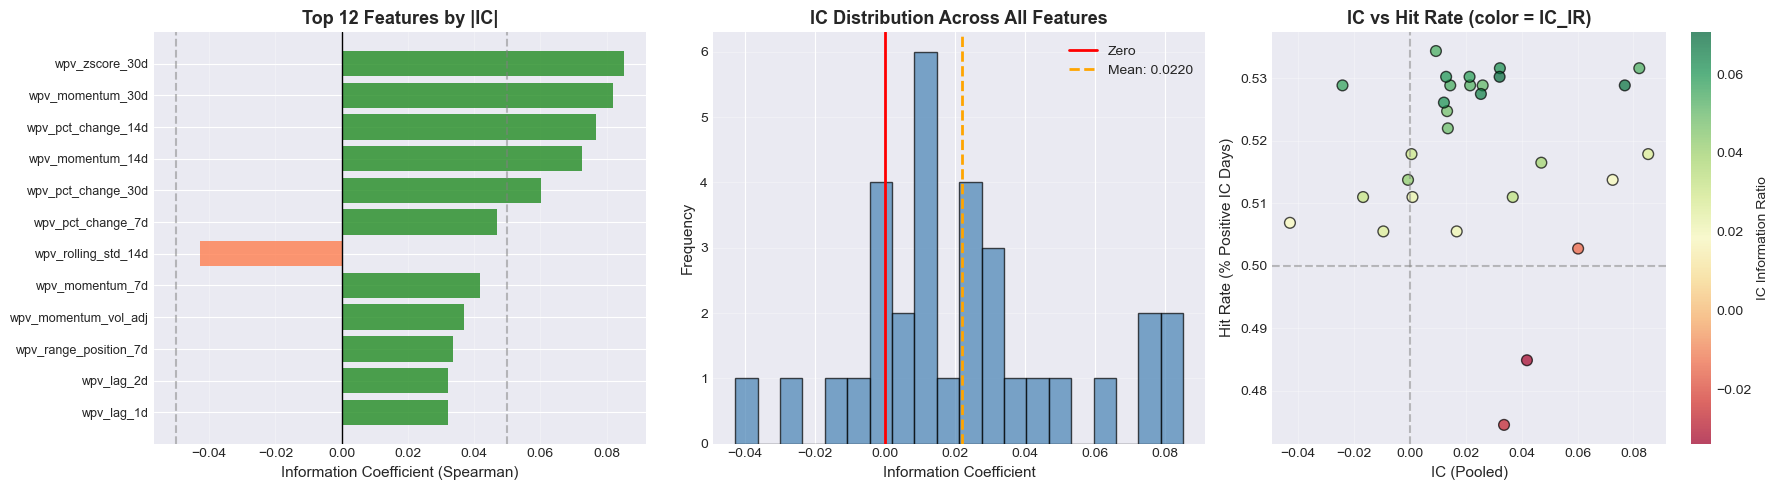

✅ IC visualization complete.


In [77]:
# ============================================================================
# VISUALIZATION: IC ANALYSIS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. IC Bar Chart (Top Features)
ax1 = axes[0]
top_features = ic_df.head(12)
colors = ['forestgreen' if ic > 0 else 'coral' for ic in top_features['IC_Pooled']]
bars = ax1.barh(range(len(top_features)), top_features['IC_Pooled'], color=colors, alpha=0.8)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=9)
ax1.set_xlabel('Information Coefficient (Spearman)', fontsize=11)
ax1.set_title('Top 12 Features by |IC|', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.axvline(x=0.05, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=-0.05, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2. IC Distribution
ax2 = axes[1]
ax2.hist(ic_df['IC_Pooled'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linewidth=2, label='Zero')
ax2.axvline(x=ic_df['IC_Pooled'].mean(), color='orange', linewidth=2, linestyle='--', 
            label=f'Mean: {ic_df["IC_Pooled"].mean():.4f}')
ax2.set_xlabel('Information Coefficient', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('IC Distribution Across All Features', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. IC vs Hit Rate
ax3 = axes[2]
valid_ir = ic_df.dropna(subset=['IC_IR', 'IC_HitRate'])
scatter = ax3.scatter(valid_ir['IC_Pooled'], valid_ir['IC_HitRate'], 
                      c=valid_ir['IC_IR'], cmap='RdYlGn', s=60, alpha=0.7, edgecolors='black')
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('IC (Pooled)', fontsize=11)
ax3.set_ylabel('Hit Rate (% Positive IC Days)', fontsize=11)
ax3.set_title('IC vs Hit Rate (color = IC_IR)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='IC Information Ratio')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('✅ IC visualization complete.')

---
## 📈 Section 17: OLS Regression Analysis

In [79]:
# ============================================================================
# SIGNAL TEST 2: OLS REGRESSION ANALYSIS
# ============================================================================

print('=' * 70)
print('SIGNAL TEST 2: OLS REGRESSION ANALYSIS')
print('=' * 70)

"""
OLS Regression to assess linear relationship between WPV features and returns.

We run:
1. Univariate regressions (each feature separately)
2. Multivariate regression (all features together)
3. Regularized regression (Ridge) to handle multicollinearity
"""

# Prepare data
X_scaled = StandardScaler().fit_transform(X)
X_with_const = sm.add_constant(X_scaled)

# 1. UNIVARIATE REGRESSIONS
print(f'\n📊 UNIVARIATE REGRESSION RESULTS:')
print(f'{'─' * 70}')
print(f'{'Feature':30} | {'Coef':>9} | {'t-stat':>8} | {'p-value':>8} | {'R²':>7}')
print(f'{'-' * 70}')

univariate_results = []

for i, feature in enumerate(WPV_FEATURES):
    X_uni = sm.add_constant(X_scaled[:, i])
    model = sm.OLS(y_reg, X_uni).fit()
    
    coef = model.params[1]
    tstat = model.tvalues[1]
    pval = model.pvalues[1]
    r2 = model.rsquared
    
    univariate_results.append({
        'Feature': feature,
        'Coefficient': coef,
        't_stat': tstat,
        'p_value': pval,
        'R_squared': r2,
        'Significant': pval < 0.05
    })

univar_df = pd.DataFrame(univariate_results)
univar_df = univar_df.sort_values('p_value')

for _, row in univar_df.head(12).iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f"{row['Feature']:30} | {row['Coefficient']:+.6f} | {row['t_stat']:+.4f} | {row['p_value']:.4f} | {row['R_squared']:.5f} {sig}")

# 2. MULTIVARIATE REGRESSION
print(f'\n📊 MULTIVARIATE REGRESSION (All Features):')
print(f'{'─' * 70}')

model_multi = sm.OLS(y_reg, X_with_const).fit()

print(f'   • R² (in-sample): {model_multi.rsquared:.6f}')
print(f'   • Adjusted R²: {model_multi.rsquared_adj:.6f}')
print(f'   • F-statistic: {model_multi.fvalue:.4f}')
print(f'   • F p-value: {model_multi.f_pvalue:.2e}')
print(f'   • AIC: {model_multi.aic:.2f}')
print(f'   • BIC: {model_multi.bic:.2f}')

# Top significant coefficients
print(f'\n   Top 10 Significant Coefficients:')
coef_df = pd.DataFrame({
    'Feature': ['const'] + WPV_FEATURES,
    'Coefficient': model_multi.params,
    't_stat': model_multi.tvalues,
    'p_value': model_multi.pvalues
})
coef_df_sorted = coef_df[coef_df['Feature'] != 'const'].sort_values('p_value').head(10)

for _, row in coef_df_sorted.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f"      {row['Feature']:28} | coef={row['Coefficient']:+.5f} | p={row['p_value']:.4f} {sig}")

# Store for later
OLS_RESULTS = {
    'univariate': univar_df,
    'multivariate': model_multi,
    'coef_df': coef_df
}

print('\n✅ OLS regression analysis complete.')

SIGNAL TEST 2: OLS REGRESSION ANALYSIS

📊 UNIVARIATE REGRESSION RESULTS:
──────────────────────────────────────────────────────────────────────
Feature                        |      Coef |   t-stat |  p-value |      R²
----------------------------------------------------------------------
wpv_zscore_30d                 | +0.002764 | +3.2456 | 0.0012 | 0.00480 **
wpv_lag_14d                    | +0.002376 | +2.7880 | 0.0053 | 0.00355 **
wpv_rolling_min_14d            | +0.002197 | +2.5770 | 0.0100 | 0.00303 *
wpv_rolling_mean_14d           | +0.002182 | +2.5590 | 0.0106 | 0.00299 *
wpv_momentum_vol_adj           | +0.002101 | +2.4638 | 0.0138 | 0.00277 *
wpv_lag_2d                     | +0.002042 | +2.3951 | 0.0167 | 0.00262 *
wpv_lag_7d                     | +0.002028 | +2.3786 | 0.0175 | 0.00259 *
wpv_rolling_min_7d             | +0.002012 | +2.3591 | 0.0184 | 0.00254 *
wpv_rolling_mean_30d           | +0.001977 | +2.3180 | 0.0205 | 0.00246 *
wpv_lag_1d                     | +0.001956

---
## 🎯 Section 18: Logistic Regression (Direction Prediction)

In [81]:
# ============================================================================
# SIGNAL TEST 3: LOGISTIC REGRESSION (DIRECTION PREDICTION)
# ============================================================================

print('=' * 70)
print('SIGNAL TEST 3: LOGISTIC REGRESSION (DIRECTION PREDICTION)')
print('=' * 70)

"""
Logistic regression to predict direction (up/down) of 5-day forward returns.

In-sample analysis to assess feature discriminative power.
"""

# Fit logistic regression
X_scaled = StandardScaler().fit_transform(X)

logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
logreg.fit(X_scaled, y_clf)

# In-sample predictions
y_pred_proba = logreg.predict_proba(X_scaled)[:, 1]
y_pred = logreg.predict(X_scaled)

# Metrics
accuracy = accuracy_score(y_clf, y_pred)
precision = precision_score(y_clf, y_pred)
recall = recall_score(y_clf, y_pred)
f1 = f1_score(y_clf, y_pred)
roc_auc = roc_auc_score(y_clf, y_pred_proba)

print(f'\n📊 IN-SAMPLE CLASSIFICATION METRICS:')
print(f'{'─' * 50}')
print(f'   • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'   • Precision: {precision:.4f}')
print(f'   • Recall:    {recall:.4f}')
print(f'   • F1 Score:  {f1:.4f}')
print(f'   • ROC-AUC:   {roc_auc:.4f}')

# Baseline comparison
baseline_accuracy = max(y_clf.mean(), 1 - y_clf.mean())
lift = accuracy / baseline_accuracy

print(f'\n📋 BASELINE COMPARISON:')
print(f'   • Baseline accuracy (majority class): {baseline_accuracy:.4f}')
print(f'   • Lift over baseline: {lift:.4f}x')

# Feature importance (coefficients)
print(f'\n📊 TOP 10 FEATURE COEFFICIENTS (Logistic):')
print(f'{'─' * 50}')

logreg_coef_df = pd.DataFrame({
    'Feature': WPV_FEATURES,
    'Coefficient': logreg.coef_[0],
    'Abs_Coef': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

for _, row in logreg_coef_df.head(10).iterrows():
    direction = '↑' if row['Coefficient'] > 0 else '↓'
    print(f"   {direction} {row['Feature']:30} | {row['Coefficient']:+.5f}")

# Confusion matrix
print(f'\n📊 CONFUSION MATRIX:')
cm = confusion_matrix(y_clf, y_pred)
print(f'   Predicted:    Down    Up')
print(f'   Actual Down: {cm[0,0]:5d}  {cm[0,1]:5d}')
print(f'   Actual Up:   {cm[1,0]:5d}  {cm[1,1]:5d}')

# Store for later
LOGREG_RESULTS = {
    'model': logreg,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'coef_df': logreg_coef_df
}

print('\n✅ Logistic regression analysis complete.')

SIGNAL TEST 3: LOGISTIC REGRESSION (DIRECTION PREDICTION)

📊 IN-SAMPLE CLASSIFICATION METRICS:
──────────────────────────────────────────────────
   • Accuracy:  0.5980 (59.80%)
   • Precision: 0.6022
   • Recall:    0.9282
   • F1 Score:  0.7305
   • ROC-AUC:   0.5887

📋 BASELINE COMPARISON:
   • Baseline accuracy (majority class): 0.5870
   • Lift over baseline: 1.0187x

📊 TOP 10 FEATURE COEFFICIENTS (Logistic):
──────────────────────────────────────────────────
   ↑ wpv_rolling_mean_14d           | +0.71047
   ↓ wpv_rolling_max_14d            | -0.64822
   ↓ wpv_rolling_min_7d             | -0.45075
   ↑ wpv_rolling_mean_30d           | +0.44306
   ↓ wpv_rolling_min_30d            | -0.33154
   ↑ wpv_zscore_30d                 | +0.31610
   ↑ wpv_rolling_max_30d            | +0.26016
   ↓ wpv_rolling_mean_7d            | -0.24720
   ↓ wpv_momentum_7d                | -0.23553
   ↑ wpv_momentum_30d               | +0.22655

📊 CONFUSION MATRIX:
   Predicted:    Down    Up
   Actual Do

---
## ⏱️ Section 19: Time-Series Cross-Validation

In [83]:
# ============================================================================
# TIME-SERIES CROSS-VALIDATION 
# ============================================================================

print('=' * 70)
print('TIME-SERIES CROSS-VALIDATION (EXPANDING WINDOW)')
print('=' * 70)

"""
Proper time-series CV to avoid look-ahead bias:

1. Train on data from start to time t
2. Test on data from time t+1 to t+k
3. Expand training window and repeat

We use an expanding window approach:
- Minimum training period: 60% of data
- Test period: 20 trading days (1 month)
- Step forward: 20 trading days
"""

def time_series_cv_split(dates, min_train_pct=0.6, test_size=20, step_size=20):
    """
    Generate train/test splits for time-series CV.
    
    Returns list of (train_idx, test_idx) tuples.
    """
    unique_dates = np.sort(np.unique(dates))
    n_dates = len(unique_dates)
    min_train = int(n_dates * min_train_pct)
    
    splits = []
    train_end = min_train
    
    while train_end + test_size <= n_dates:
        train_dates = unique_dates[:train_end]
        test_dates = unique_dates[train_end:train_end + test_size]
        
        train_idx = np.where(np.isin(dates, train_dates))[0]
        test_idx = np.where(np.isin(dates, test_dates))[0]
        
        splits.append((train_idx, test_idx))
        train_end += step_size
    
    return splits

# Generate CV splits
cv_splits = time_series_cv_split(dates, min_train_pct=0.6, test_size=20, step_size=20)

print(f'\n📋 CV CONFIGURATION:')
print(f'   • Number of folds: {len(cv_splits)}')
print(f'   • Min training period: 60% of data')
print(f'   • Test period: 20 trading days per fold')
print(f'   • Step size: 20 trading days')

# Show split info
print(f'\n📋 FOLD DETAILS:')
for i, (train_idx, test_idx) in enumerate(cv_splits[:5]):
    train_start = pd.Timestamp(dates[train_idx[0]]).strftime('%Y-%m-%d')
    train_end = pd.Timestamp(dates[train_idx[-1]]).strftime('%Y-%m-%d')
    test_start = pd.Timestamp(dates[test_idx[0]]).strftime('%Y-%m-%d')
    test_end = pd.Timestamp(dates[test_idx[-1]]).strftime('%Y-%m-%d')
    print(f'   Fold {i+1}: Train [{train_start} to {train_end}] ({len(train_idx):,}) → Test [{test_start} to {test_end}] ({len(test_idx):,})')
if len(cv_splits) > 5:
    print(f'   ... and {len(cv_splits) - 5} more folds')

print('\n✅ CV splits generated.')

TIME-SERIES CROSS-VALIDATION (EXPANDING WINDOW)

📋 CV CONFIGURATION:
   • Number of folds: 14
   • Min training period: 60% of data
   • Test period: 20 trading days per fold
   • Step size: 20 trading days

📋 FOLD DETAILS:
   Fold 1: Train [2023-01-05 to 2024-09-30] (1,308) → Test [2024-10-01 to 2024-10-28] (60)
   Fold 2: Train [2023-01-05 to 2024-10-28] (1,368) → Test [2024-10-29 to 2024-11-25] (60)
   Fold 3: Train [2023-01-05 to 2024-11-25] (1,428) → Test [2024-11-26 to 2024-12-24] (60)
   Fold 4: Train [2023-01-05 to 2024-12-24] (1,488) → Test [2024-12-26 to 2025-01-27] (60)
   Fold 5: Train [2023-01-05 to 2025-01-27] (1,548) → Test [2025-01-28 to 2025-02-25] (60)
   ... and 9 more folds

✅ CV splits generated.


In [84]:
# ============================================================================
# RUN TIME-SERIES CV: REGRESSION MODELS
# ============================================================================

print('=' * 70)
print('TIME-SERIES CV: REGRESSION MODELS')
print('=' * 70)

def run_regression_cv(X, y, cv_splits, model_class, **model_kwargs):
    """Run time-series CV for regression model."""
    results = []
    all_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit model
        model = model_class(**model_kwargs)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Compute metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        ic, _ = spearmanr(y_test, y_pred)
        
        results.append({
            'Fold': fold + 1,
            'Train_Size': len(train_idx),
            'Test_Size': len(test_idx),
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'IC': ic
        })
        
        # Store predictions
        for i, idx in enumerate(test_idx):
            all_predictions.append({
                'idx': idx,
                'y_true': y_test[i],
                'y_pred': y_pred[i],
                'fold': fold + 1
            })
    
    return pd.DataFrame(results), pd.DataFrame(all_predictions)

# Run CV for different regression models
print('\n🔄 Running Linear Regression CV...')
lr_results, lr_preds = run_regression_cv(X, y_reg, cv_splits, LinearRegression)

print('🔄 Running Ridge Regression CV...')
ridge_results, ridge_preds = run_regression_cv(X, y_reg, cv_splits, Ridge, alpha=1.0)

# Summarize results
print(f'\n📊 REGRESSION CV RESULTS:')
print(f'{'─' * 70}')

def summarize_cv_results(results_df, model_name):
    print(f'\n   {model_name}:')
    print(f'      MAE:  {results_df["MAE"].mean():.6f} ± {results_df["MAE"].std():.6f}')
    print(f'      RMSE: {results_df["RMSE"].mean():.6f} ± {results_df["RMSE"].std():.6f}')
    print(f'      R²:   {results_df["R2"].mean():.6f} ± {results_df["R2"].std():.6f}')
    print(f'      IC:   {results_df["IC"].mean():.4f} ± {results_df["IC"].std():.4f}')
    return {
        'model': model_name,
        'MAE_mean': results_df['MAE'].mean(),
        'MAE_std': results_df['MAE'].std(),
        'RMSE_mean': results_df['RMSE'].mean(),
        'RMSE_std': results_df['RMSE'].std(),
        'R2_mean': results_df['R2'].mean(),
        'R2_std': results_df['R2'].std(),
        'IC_mean': results_df['IC'].mean(),
        'IC_std': results_df['IC'].std()
    }

reg_summary = [
    summarize_cv_results(lr_results, 'Linear Regression'),
    summarize_cv_results(ridge_results, 'Ridge Regression')
]

REG_CV_RESULTS = {
    'linear': {'results': lr_results, 'predictions': lr_preds},
    'ridge': {'results': ridge_results, 'predictions': ridge_preds},
    'summary': pd.DataFrame(reg_summary)
}

print('\n✅ Regression CV complete.')

TIME-SERIES CV: REGRESSION MODELS

🔄 Running Linear Regression CV...
🔄 Running Ridge Regression CV...

📊 REGRESSION CV RESULTS:
──────────────────────────────────────────────────────────────────────

   Linear Regression:
      MAE:  0.034477 ± 0.011775
      RMSE: 0.043893 ± 0.015323
      R²:   -0.367941 ± 0.528972
      IC:   0.0088 ± 0.3645

   Ridge Regression:
      MAE:  0.034267 ± 0.011667
      RMSE: 0.043655 ± 0.015203
      R²:   -0.347855 ± 0.494872
      IC:   0.0042 ± 0.3607

✅ Regression CV complete.


In [85]:
# ============================================================================
# RUN TIME-SERIES CV: CLASSIFICATION MODELS
# ============================================================================

print('=' * 70)
print('TIME-SERIES CV: CLASSIFICATION MODELS')
print('=' * 70)

def run_classification_cv(X, y, cv_splits, model_class, **model_kwargs):
    """Run time-series CV for classification model."""
    results = []
    all_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit model
        model = model_class(**model_kwargs)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # ROC-AUC (handle edge cases)
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except ValueError:
            roc_auc = 0.5  # Default if only one class present
        
        results.append({
            'Fold': fold + 1,
            'Train_Size': len(train_idx),
            'Test_Size': len(test_idx),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'ROC_AUC': roc_auc
        })
        
        # Store predictions
        for i, idx in enumerate(test_idx):
            all_predictions.append({
                'idx': idx,
                'y_true': y_test[i],
                'y_pred': y_pred[i],
                'y_proba': y_pred_proba[i],
                'fold': fold + 1
            })
    
    return pd.DataFrame(results), pd.DataFrame(all_predictions)

# Run CV for logistic regression
print('\n🔄 Running Logistic Regression CV...')
logreg_cv_results, logreg_cv_preds = run_classification_cv(
    X, y_clf, cv_splits, LogisticRegression, max_iter=1000, solver='lbfgs', random_state=42
)

# Summarize results
print(f'\n📊 CLASSIFICATION CV RESULTS:')
print(f'{'─' * 70}')

def summarize_clf_cv_results(results_df, model_name):
    print(f'\n   {model_name}:')
    print(f'      Accuracy:  {results_df["Accuracy"].mean():.4f} ± {results_df["Accuracy"].std():.4f}')
    print(f'      Precision: {results_df["Precision"].mean():.4f} ± {results_df["Precision"].std():.4f}')
    print(f'      Recall:    {results_df["Recall"].mean():.4f} ± {results_df["Recall"].std():.4f}')
    print(f'      F1 Score:  {results_df["F1"].mean():.4f} ± {results_df["F1"].std():.4f}')
    print(f'      ROC-AUC:   {results_df["ROC_AUC"].mean():.4f} ± {results_df["ROC_AUC"].std():.4f}')
    return {
        'model': model_name,
        'Accuracy_mean': results_df['Accuracy'].mean(),
        'Accuracy_std': results_df['Accuracy'].std(),
        'Precision_mean': results_df['Precision'].mean(),
        'Recall_mean': results_df['Recall'].mean(),
        'F1_mean': results_df['F1'].mean(),
        'ROC_AUC_mean': results_df['ROC_AUC'].mean(),
        'ROC_AUC_std': results_df['ROC_AUC'].std()
    }

clf_summary = [summarize_clf_cv_results(logreg_cv_results, 'Logistic Regression')]

# Baseline comparison
baseline_acc = max(y_clf.mean(), 1 - y_clf.mean())
cv_acc = logreg_cv_results['Accuracy'].mean()
lift = cv_acc / baseline_acc

print(f'\n📋 BASELINE COMPARISON:')
print(f'   • Baseline accuracy: {baseline_acc:.4f}')
print(f'   • CV accuracy: {cv_acc:.4f}')
print(f'   • Lift over baseline: {lift:.4f}x')

CLF_CV_RESULTS = {
    'logistic': {'results': logreg_cv_results, 'predictions': logreg_cv_preds},
    'summary': pd.DataFrame(clf_summary)
}

print('\n✅ Classification CV complete.')

TIME-SERIES CV: CLASSIFICATION MODELS

🔄 Running Logistic Regression CV...

📊 CLASSIFICATION CV RESULTS:
──────────────────────────────────────────────────────────────────────

   Logistic Regression:
      Accuracy:  0.5702 ± 0.1193
      Precision: 0.5785 ± 0.1243
      Recall:    0.9401 ± 0.0775
      F1 Score:  0.7090 ± 0.1005
      ROC-AUC:   0.5022 ± 0.1551

📋 BASELINE COMPARISON:
   • Baseline accuracy: 0.5870
   • CV accuracy: 0.5702
   • Lift over baseline: 0.9715x

✅ Classification CV complete.


---
## 📊 Section 20: CV Results Visualization

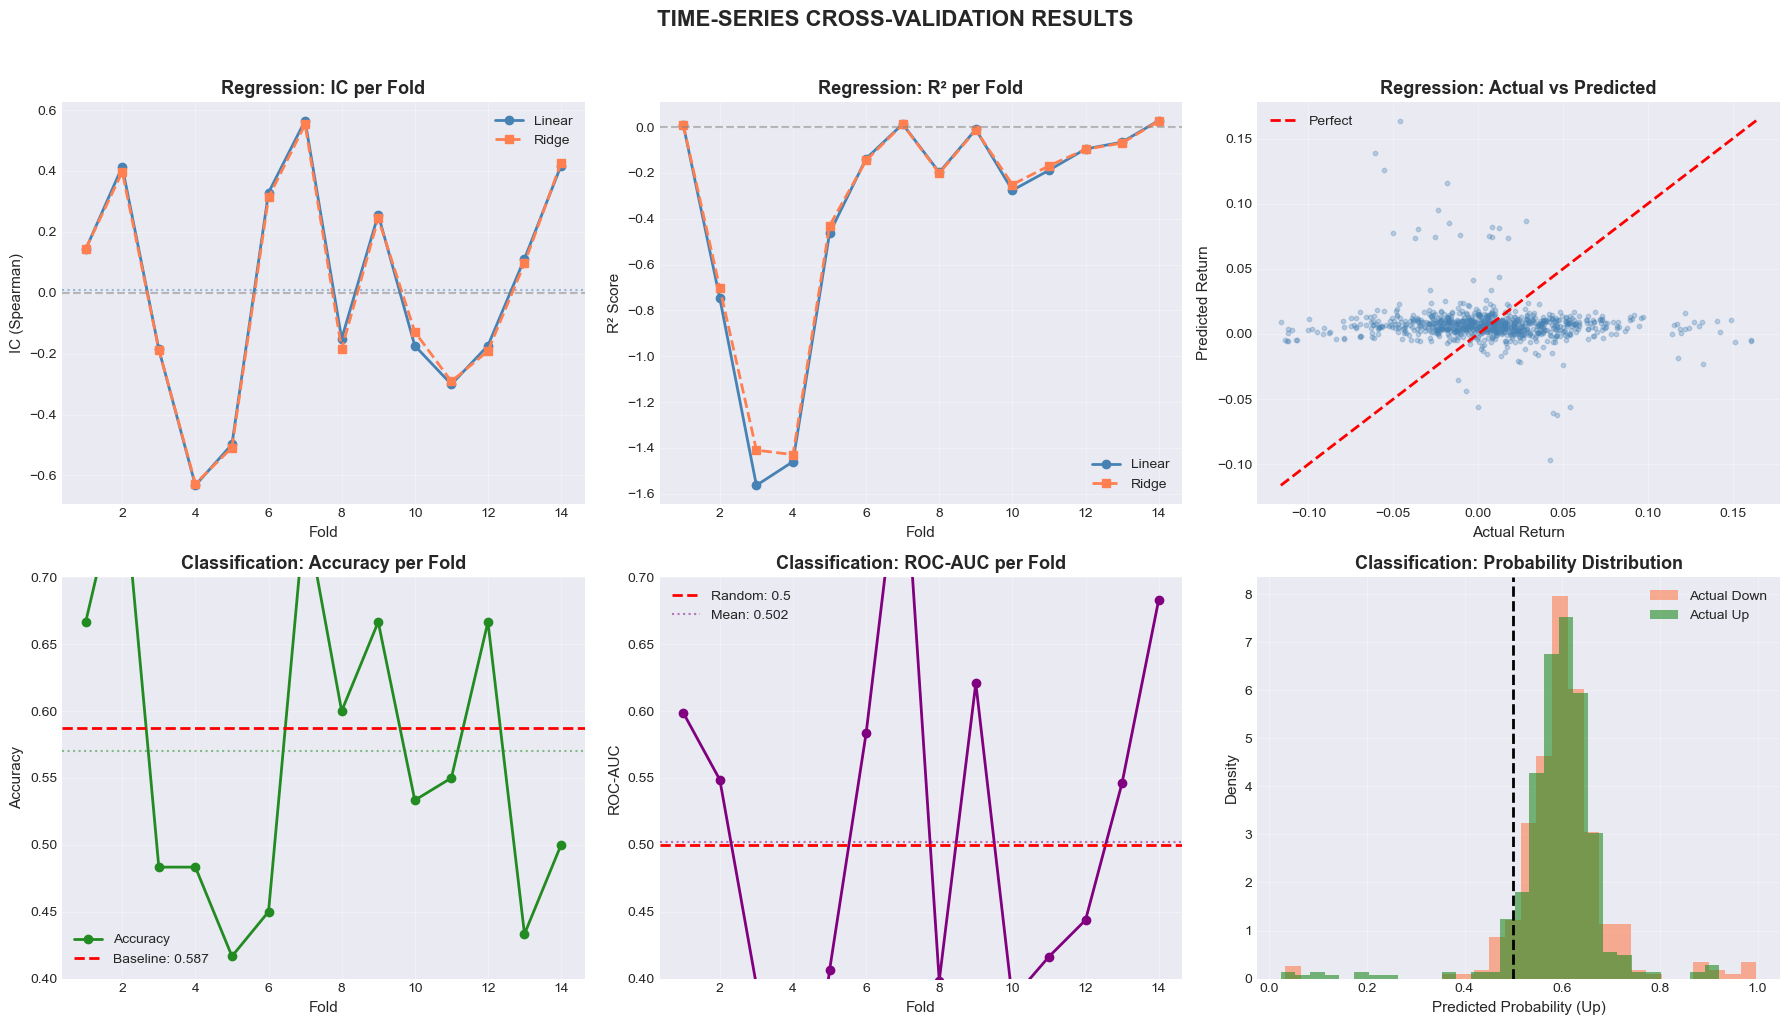

✅ CV visualization complete.


In [87]:
# ============================================================================
# VISUALIZATION: CV RESULTS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Regression: IC per fold
ax1 = axes[0, 0]
folds = lr_results['Fold']
ax1.plot(folds, lr_results['IC'], 'o-', label='Linear', color='steelblue', linewidth=2)
ax1.plot(folds, ridge_results['IC'], 's--', label='Ridge', color='coral', linewidth=2)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=lr_results['IC'].mean(), color='steelblue', linestyle=':', alpha=0.5)
ax1.set_xlabel('Fold', fontsize=11)
ax1.set_ylabel('IC (Spearman)', fontsize=11)
ax1.set_title('Regression: IC per Fold', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Regression: R² per fold
ax2 = axes[0, 1]
ax2.plot(folds, lr_results['R2'], 'o-', label='Linear', color='steelblue', linewidth=2)
ax2.plot(folds, ridge_results['R2'], 's--', label='Ridge', color='coral', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Fold', fontsize=11)
ax2.set_ylabel('R² Score', fontsize=11)
ax2.set_title('Regression: R² per Fold', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Regression: Actual vs Predicted (scatter)
ax3 = axes[0, 2]
ax3.scatter(lr_preds['y_true'], lr_preds['y_pred'], alpha=0.3, s=10, color='steelblue')
min_val = min(lr_preds['y_true'].min(), lr_preds['y_pred'].min())
max_val = max(lr_preds['y_true'].max(), lr_preds['y_pred'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
ax3.set_xlabel('Actual Return', fontsize=11)
ax3.set_ylabel('Predicted Return', fontsize=11)
ax3.set_title('Regression: Actual vs Predicted', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Classification: Accuracy per fold
ax4 = axes[1, 0]
ax4.plot(logreg_cv_results['Fold'], logreg_cv_results['Accuracy'], 'o-', 
         color='forestgreen', linewidth=2, label='Accuracy')
ax4.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline: {baseline_acc:.3f}')
ax4.axhline(y=logreg_cv_results['Accuracy'].mean(), color='forestgreen', linestyle=':', alpha=0.5)
ax4.set_xlabel('Fold', fontsize=11)
ax4.set_ylabel('Accuracy', fontsize=11)
ax4.set_title('Classification: Accuracy per Fold', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_ylim(0.4, 0.7)

# 5. Classification: ROC-AUC per fold
ax5 = axes[1, 1]
ax5.plot(logreg_cv_results['Fold'], logreg_cv_results['ROC_AUC'], 'o-', 
         color='purple', linewidth=2)
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random: 0.5')
ax5.axhline(y=logreg_cv_results['ROC_AUC'].mean(), color='purple', linestyle=':', alpha=0.5,
           label=f'Mean: {logreg_cv_results["ROC_AUC"].mean():.3f}')
ax5.set_xlabel('Fold', fontsize=11)
ax5.set_ylabel('ROC-AUC', fontsize=11)
ax5.set_title('Classification: ROC-AUC per Fold', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim(0.4, 0.7)

# 6. Classification: Probability distribution
ax6 = axes[1, 2]
pred_df = logreg_cv_preds
ax6.hist(pred_df[pred_df['y_true'] == 0]['y_proba'], bins=30, alpha=0.6, 
         label='Actual Down', color='coral', density=True)
ax6.hist(pred_df[pred_df['y_true'] == 1]['y_proba'], bins=30, alpha=0.6, 
         label='Actual Up', color='forestgreen', density=True)
ax6.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax6.set_xlabel('Predicted Probability (Up)', fontsize=11)
ax6.set_ylabel('Density', fontsize=11)
ax6.set_title('Classification: Probability Distribution', fontsize=13, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.suptitle('TIME-SERIES CROSS-VALIDATION RESULTS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('✅ CV visualization complete.')

---
## 📋 Section 21: Evaluation Report

In [89]:
# ============================================================================
# COMPREHENSIVE EVALUATION REPORT
# ============================================================================

print('=' * 80)
print('📋 PHASE 4: COMPREHENSIVE EVALUATION REPORT')
print('=' * 80)

print(f'''
┌─────────────────────────────────────────────────────────────────────────────┐
│                     SIGNAL TESTING + BASELINE MODELS                        │
│                           EVALUATION REPORT                                 │
└─────────────────────────────────────────────────────────────────────────────┘

📊 DATASET SUMMARY
{'─' * 75}
   Records:         {len(df_model):,}
   Companies:       {df_model['company'].nunique()} ({', '.join(df_model['company'].unique())})
   Date Range:      {df_model['date'].min().strftime('%Y-%m-%d')} to {df_model['date'].max().strftime('%Y-%m-%d')}
   WPV Features:    {len(WPV_FEATURES)}
   CV Folds:        {len(cv_splits)}


📈 1. INFORMATION COEFFICIENT (IC) ANALYSIS
{'─' * 75}
   • Features tested:        {len(IC_RESULTS)}
   • Significant (p<0.05):   {IC_RESULTS['Significant'].sum()} ({IC_RESULTS['Significant'].mean()*100:.0f}%)
   • Average |IC|:           {IC_RESULTS['IC_Pooled'].abs().mean():.4f}
   • Max |IC|:               {IC_RESULTS['IC_Pooled'].abs().max():.4f}
   • Best feature:           {IC_RESULTS.iloc[0]['Feature']} (IC={IC_RESULTS.iloc[0]['IC_Pooled']:.4f})

   INTERPRETATION:
   {'✅ Positive' if IC_RESULTS['IC_Pooled'].abs().max() > 0.03 else '⚠️ Weak'}: {'Some features show predictive signal' if IC_RESULTS['IC_Pooled'].abs().max() > 0.03 else 'Signals are very weak'}


📉 2. OLS REGRESSION ANALYSIS (In-Sample)
{'─' * 75}
   Multivariate Model:
   • R² (in-sample):         {OLS_RESULTS['multivariate'].rsquared:.6f}
   • Adjusted R²:            {OLS_RESULTS['multivariate'].rsquared_adj:.6f}
   • F-statistic:            {OLS_RESULTS['multivariate'].fvalue:.4f} (p={OLS_RESULTS['multivariate'].f_pvalue:.2e})
   
   Univariate Significance:
   • Features with p<0.05:   {(OLS_RESULTS['univariate']['p_value'] < 0.05).sum()}
   • Features with p<0.01:   {(OLS_RESULTS['univariate']['p_value'] < 0.01).sum()}


🎯 3. LOGISTIC REGRESSION (In-Sample)
{'─' * 75}
   • Accuracy:               {LOGREG_RESULTS['accuracy']:.4f} ({LOGREG_RESULTS['accuracy']*100:.2f}%)
   • Precision:              {LOGREG_RESULTS['precision']:.4f}
   • Recall:                 {LOGREG_RESULTS['recall']:.4f}
   • F1 Score:               {LOGREG_RESULTS['f1']:.4f}
   • ROC-AUC:                {LOGREG_RESULTS['roc_auc']:.4f}
   • Baseline (majority):    {baseline_acc:.4f}
   • Lift over baseline:     {LOGREG_RESULTS['accuracy']/baseline_acc:.4f}x


⏱️ 4. TIME-SERIES CROSS-VALIDATION RESULTS
{'─' * 75}
   
   REGRESSION (Predicting 5-day returns):
   ┌───────────────────┬────────────────────┬────────────────────┐
   │ Metric            │ Linear Regression  │ Ridge Regression   │
   ├───────────────────┼────────────────────┼────────────────────┤
   │ MAE               │ {lr_results['MAE'].mean():.6f} ± {lr_results['MAE'].std():.4f} │ {ridge_results['MAE'].mean():.6f} ± {ridge_results['MAE'].std():.4f} │
   │ RMSE              │ {lr_results['RMSE'].mean():.6f} ± {lr_results['RMSE'].std():.4f} │ {ridge_results['RMSE'].mean():.6f} ± {ridge_results['RMSE'].std():.4f} │
   │ R²                │ {lr_results['R2'].mean():+.6f} ± {lr_results['R2'].std():.4f} │ {ridge_results['R2'].mean():+.6f} ± {ridge_results['R2'].std():.4f} │
   │ IC                │ {lr_results['IC'].mean():+.4f} ± {lr_results['IC'].std():.4f}   │ {ridge_results['IC'].mean():+.4f} ± {ridge_results['IC'].std():.4f}   │
   └───────────────────┴────────────────────┴────────────────────┘
   
   CLASSIFICATION (Predicting 5-day direction):
   ┌───────────────────┬────────────────────────────┐
   │ Metric            │ Logistic Regression        │
   ├───────────────────┼────────────────────────────┤
   │ Accuracy          │ {logreg_cv_results['Accuracy'].mean():.4f} ± {logreg_cv_results['Accuracy'].std():.4f}          │
   │ Precision         │ {logreg_cv_results['Precision'].mean():.4f} ± {logreg_cv_results['Precision'].std():.4f}          │
   │ Recall            │ {logreg_cv_results['Recall'].mean():.4f} ± {logreg_cv_results['Recall'].std():.4f}          │
   │ F1 Score          │ {logreg_cv_results['F1'].mean():.4f} ± {logreg_cv_results['F1'].std():.4f}          │
   │ ROC-AUC           │ {logreg_cv_results['ROC_AUC'].mean():.4f} ± {logreg_cv_results['ROC_AUC'].std():.4f}          │
   └───────────────────┴────────────────────────────┘
   
   Baseline Accuracy: {baseline_acc:.4f}
   CV Lift: {logreg_cv_results['Accuracy'].mean()/baseline_acc:.4f}x

''')

print('\n✅ Evaluation report complete.')

📋 PHASE 4: COMPREHENSIVE EVALUATION REPORT

┌─────────────────────────────────────────────────────────────────────────────┐
│                     SIGNAL TESTING + BASELINE MODELS                        │
│                           EVALUATION REPORT                                 │
└─────────────────────────────────────────────────────────────────────────────┘

📊 DATASET SUMMARY
───────────────────────────────────────────────────────────────────────────
   Records:         2,184
   Companies:       3 (Amazon, Netflix, Walmart)
   Date Range:      2023-01-05 to 2025-11-28
   WPV Features:    33
   CV Folds:        14


📈 1. INFORMATION COEFFICIENT (IC) ANALYSIS
───────────────────────────────────────────────────────────────────────────
   • Features tested:        33
   • Significant (p<0.05):   7 (21%)
   • Average |IC|:           0.0280
   • Max |IC|:               0.0853
   • Best feature:           wpv_zscore_30d (IC=0.0853)

   INTERPRETATION:
   ✅ Positive: Some features show pre

In [90]:
# ============================================================================
# KEY FINDINGS & RECOMMENDATIONS
# ============================================================================

print('=' * 80)
print('💡 KEY FINDINGS & RECOMMENDATIONS')
print('=' * 80)

# Determine signal strength
avg_ic = IC_RESULTS['IC_Pooled'].abs().mean()
max_ic = IC_RESULTS['IC_Pooled'].abs().max()
cv_auc = logreg_cv_results['ROC_AUC'].mean()
cv_acc = logreg_cv_results['Accuracy'].mean()

signal_strength = 'Strong' if max_ic > 0.10 else 'Moderate' if max_ic > 0.05 else 'Weak'
predictive_value = 'Promising' if cv_auc > 0.55 else 'Limited' if cv_auc > 0.52 else 'Minimal'

print(f'''
🔍 KEY FINDINGS
{'─' * 75}

1. SIGNAL STRENGTH: {signal_strength.upper()}
   • Average |IC| = {avg_ic:.4f} (threshold: 0.05 for actionable signal)
   • Max |IC| = {max_ic:.4f}
   • {IC_RESULTS['Significant'].sum()}/{len(IC_RESULTS)} features show statistical significance

2. PREDICTIVE VALUE: {predictive_value.upper()}
   • Out-of-sample ROC-AUC = {cv_auc:.4f} (random = 0.50)
   • Out-of-sample Accuracy = {cv_acc:.4f} (baseline = {baseline_acc:.4f})
   • Lift over random: {cv_auc/0.5:.2f}x

3. TOP PREDICTIVE FEATURES:
''')

for i, row in IC_RESULTS.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']:30} (IC = {row['IC_Pooled']:+.4f})")

print(f'''

📋 RECOMMENDATIONS
{'─' * 75}

{'✅' if signal_strength != 'Weak' else '⚠️'} 1. SIGNAL QUALITY:
   {'WPV features show some predictive signal. Worth further investigation.' if signal_strength != 'Weak' else 'WPV signals are weak. Consider additional features or data sources.'}

{'✅' if cv_auc > 0.52 else '⚠️'} 2. MODEL PERFORMANCE:
   {'Models beat random baseline. Consider ensemble methods or feature engineering.' if cv_auc > 0.52 else 'Models barely beat baseline. More sophisticated approaches may be needed.'}

📌 3. NEXT STEPS:
   • Try non-linear models (Random Forest, XGBoost)
   • Add interaction features between WPV metrics
   • Include market-wide features (VIX, sector indices)
   • Test on longer time horizons (10-day, 20-day returns)
   • Consider regime-conditional models
   ''')

💡 KEY FINDINGS & RECOMMENDATIONS

🔍 KEY FINDINGS
───────────────────────────────────────────────────────────────────────────

1. SIGNAL STRENGTH: MODERATE
   • Average |IC| = 0.0280 (threshold: 0.05 for actionable signal)
   • Max |IC| = 0.0853
   • 7/33 features show statistical significance

2. PREDICTIVE VALUE: MINIMAL
   • Out-of-sample ROC-AUC = 0.5022 (random = 0.50)
   • Out-of-sample Accuracy = 0.5702 (baseline = 0.5870)
   • Lift over random: 1.00x

3. TOP PREDICTIVE FEATURES:

   27. wpv_zscore_30d                 (IC = +0.0853)
   25. wpv_momentum_30d               (IC = +0.0821)
   24. wpv_pct_change_14d             (IC = +0.0769)
   23. wpv_momentum_14d               (IC = +0.0726)
   26. wpv_pct_change_30d             (IC = +0.0602)


📋 RECOMMENDATIONS
───────────────────────────────────────────────────────────────────────────

✅ 1. SIGNAL QUALITY:
   WPV features show some predictive signal. Worth further investigation.

⚠️ 2. MODEL PERFORMANCE:
   Models barely beat bas